In [1]:
# Install torchaudio
!pip install torchaudio==0.9.1 -q
import librosa
import torchaudio
from torchaudio import transforms

     |████████████████████████████████| 1.9 MB 4.3 MB/s 
     |████████████████████████████████| 831.4 MB 2.6 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.11.1+cu111 requires torch==1.10.0, but you have torch 1.9.1 which is incompatible.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.9.1 which is incompatible.


In [2]:
import datetime
import os

import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau, ExponentialLR
from torch.utils.data import Dataset, DataLoader, IterableDataset

import numpy as np
import pandas as pd

from collections import Counter, defaultdict, OrderedDict

from sklearn.metrics import precision_score, f1_score, recall_score, classification_report, confusion_matrix, make_scorer, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Consider ragas that have at least 10 samples.
RAGAM_MIN_COUNT = 10

In [6]:
data = pd.read_json('/content/drive/MyDrive/song_lyric_map.json')
adata = pd.read_json('/content/drive/MyDrive/mp3_data_genres.json')

In [7]:
AUD_PATH = '/content/drive/MyDrive/Annamayya'
data['exists'] = data.apply(lambda x:os.path.exists(os.path.join(AUD_PATH,x['MP3 File'])),axis=1)
data = data[data.exists]

In [8]:
def get_offset(adata, id):
  l = adata[adata.Samputi==id]['Offset'].tolist()
  return 60 if len(l) == 0 else l[0]
data['Offset'] = data.apply(lambda x:get_offset(adata, x.Samputi), axis=1)

data['Offset'].fillna(60,inplace=True)

In [9]:
all_samples = data.Ragam.value_counts().index
low_samples = all_samples[data.Ragam.value_counts()<RAGAM_MIN_COUNT]
# Drop these rows.
for s in low_samples:
  data = data[data.Ragam!=s]

In [10]:
le = LabelEncoder()
le.fit_transform(data['Ragam'])
data['RagamCode'] = data.apply(lambda x:le.transform([x.Ragam])[0],axis=1)
n_labels = len(data['RagamCode'].unique())

In [11]:
data['Ragam'].value_counts()

లలిత            98
సాళంగనాట        94
సామంతం          89
బౌళి            70
శంకరాభరణం       68
శ్రీరాగం        65
రామక్రియ        61
ముఖారి          55
పాడి            50
ఆహిరి           45
దేసాళం          40
దేవగాంధారి      35
శుద్ధవసంతం      33
భూపాలం          32
దేసాక్షి        29
గుండుక్రియ      28
భైరవి           27
నాట             25
వరాళి           22
మలహరి           20
ధన్నాసి         20
కాంబోది         19
మాళవిగౌళ        18
మాళవి           18
కన్నడగౌళ        15
గుజ్జరి         15
గౌళ             14
బౌళిరామక్రియ    13
నాదరామక్రియ     11
సాళంగం          11
Name: Ragam, dtype: int64

In [12]:
print(f'Unique Ragas : {n_labels}')

Unique Ragas : 30


ఆహిరి : [0]
కన్నడగౌళ : [1]
కాంబోది : [2]
గుండుక్రియ : [3]
గుజ్జరి : [4]
గౌళ : [5]
దేవగాంధారి : [6]
దేసాక్షి : [7]
దేసాళం : [8]
ధన్నాసి : [9]
నాట : [10]
నాదరామక్రియ : [11]
పాడి : [12]
బౌళి : [13]
బౌళిరామక్రియ : [14]
భూపాలం : [15]
భైరవి : [16]
మలహరి : [17]
మాళవి : [18]
మాళవిగౌళ : [19]
ముఖారి : [20]
రామక్రియ : [21]
లలిత : [22]
వరాళి : [23]
శంకరాభరణం : [24]
శుద్ధవసంతం : [25]
శ్రీరాగం : [26]
సామంతం : [27]
సాళంగం : [28]
సాళంగనాట : [29]


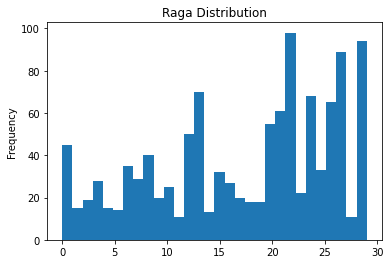

In [13]:
for c in le.classes_: print(f'{c} : {le.transform([c])}')
data['RagamCode'].plot.hist(bins=n_labels)
plt.title('Raga Distribution')
plt.show()

In [14]:
def get_devices():
    if torch.cuda.is_available():
        gpu = torch.device("cuda")
    else:
        gpu = torch.device("cpu")
    cpu = torch.device("cpu")
    return gpu, cpu
gpu, cpu = get_devices()

In [15]:
def get_loss_function(balance_classes, labels, run_on, loss_fcn=nn.CrossEntropyLoss):
    if balance_classes:
        class_wts = compute_class_weight(class_weight = 'balanced',
                                         classes = np.unique(labels),
                                         y = labels
                                         )
        print(f'Class Weights : {class_wts}')
        # convert class weights to tensor
        weights = torch.tensor(class_wts, dtype=torch.float)
        weights = weights.to(run_on)
        # loss function
        loss_fcn = loss_fcn(weight=weights)
    else:
        loss_fcn = loss_fcn()
    return loss_fcn

In [16]:
def update_best_result(best_scores, valid_loss, train_labels, train_predictions, test_labels, test_predictions,
                       model=None, model_file_name=f'saved_weights_Fold_0.pt'):
    if valid_loss < best_scores['valid_loss']:
        best_scores['valid_loss'] = valid_loss
        best_scores['train_predictions'] = train_predictions
        best_scores['test_predictions'] = test_predictions
        best_scores['train_labels'] = train_labels
        best_scores['test_labels'] = test_labels
        if model:
            torch.save(model.state_dict(), model_file_name)
    return best_scores

In [17]:
def update_results_dict(results, train_labels, train_predictions, test_labels, test_predictions, s='micro'):
    results['train_precision'].append(precision_score(train_labels, train_predictions,average=s))
    results['train_recall'].append(recall_score(train_labels, train_predictions,average=s))
    results['train_f1'].append(f1_score(train_labels, train_predictions,average=s))
    results['validation_precision'].append(precision_score(test_labels, test_predictions,average=s))
    results['validation_recall'].append(recall_score(test_labels, test_predictions,average=s))
    results['validation_f1'].append(f1_score(test_labels, test_predictions,average=s))
    return results

In [18]:
def run_model(model, dataset, loss_fcn, optimizer, is_training, run_on, clip_at=None, lstm_model=False, report_at=20):
  predict = lambda model, data, hidden: model(data, hidden) if hidden else model(data)
  hid = lambda model, data, run_on, lstm_model: model.init_hidden(data.shape[0], run_on) if lstm_model else None
  if is_training:
      model.train()
  else:
      model.eval()
  total_loss, total_accuracy, model_predictions, model_labels, aud_data = 0, 0, [], [], None
  for step, batch in enumerate(dataset):
      if step % report_at == 0 and not step == 0:
          print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(dataset)))
      # push the batch to gpu
      batch = [r.to(run_on) for r in batch]        
      aud_data, labels = batch
      h = hid(model, aud_data, run_on, lstm_model)
      if is_training:
          for o in optimizer: o.zero_grad()
          model.zero_grad()
          predictions = predict(model, aud_data, h)
      else:
          with torch.no_grad():
            predictions = predict(model, aud_data, h)
      # compute the loss between actual and predicted values
      loss = loss_fcn(predictions, labels)
      predictions = predictions.detach().cpu().numpy()
      total_loss = total_loss + loss.item()
      if is_training:
          loss.backward()  # backward pass to calculate the gradients
          if clip_at: torch.nn.utils.clip_grad_norm_(model.parameters(), clip_at)
          # update parameters
          for o in optimizer: o.step()
      # append the model predictions
      model_predictions.append(predictions)
      model_labels.append(labels.detach().cpu().numpy())
      del batch
  # compute the training loss of the epoch
  avg_loss = total_loss / len(dataset)
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  model_predictions = np.concatenate(model_predictions, axis=0)
  model_labels = np.concatenate(model_labels, axis=0)
  # returns the loss and predictions
  model_predictions = np.argmax(model_predictions, axis=1)
  return avg_loss, model_predictions, model_labels, model

In [19]:
def plot_results(results, model_name):
    fig = plt.figure(figsize=[20, 10])
    epochs = len(results[0]['train_precision'])
    x_label = f'{len(results)} Fold and {epochs} Epochs'
    legend_labels = ['Train', 'Val']

    def subplot_routine(key1, key2, title, loss=False):
        plt.plot([x for k in results for x in results[k][key1]])
        plt.plot([x for k in results for x in results[k][key2]])
        plt.grid()
        plt.xlabel(x_label)
        plt.legend([f'{x} {title}' for x in legend_labels])
        if not loss:
            plt.ylim([0, 1.1])
        else:
            b, t = plt.ylim()
            plt.ylim(np.floor(b), np.ceil(t))

    gs = GridSpec(2, 3, figure=fig)
    plt.subplot(gs.new_subplotspec((0, 0), colspan=3))
    subplot_routine('train_losses', 'validation_losses', 'Losses', True)
    plt.subplot(2, 3, 4)
    subplot_routine('train_precision', 'validation_precision', 'Precision')
    plt.subplot(2, 3, 5)
    subplot_routine('train_recall', 'validation_recall', 'Recall')
    plt.subplot(2, 3, 6)
    subplot_routine('train_f1', 'validation_f1', 'F1')
    plt.suptitle(f'Metrics for {model_name}')
    plt.tight_layout()
    plt.show()

In [20]:
class AbsDataset(IterableDataset):
  def __init__(self):
    super().__init__()
  
  def get_data_loader(self, batch_size=32, random_seed=42):
    g = torch.Generator()
    g.manual_seed(random_seed)
    return DataLoader(self, batch_size=batch_size, generator=g)

In [21]:
def train_model(data, prepare_data_hnd, gpu, **kwargs):
  torch.manual_seed(42)
  start_time = datetime.datetime.now()

  n_labels = kwargs['n_labels']
  title = kwargs['title']
  report = kwargs['report'] if 'report' in kwargs else 20
  lstm = kwargs['lstm'] if 'lstm' in kwargs else False
  lr = kwargs['lr'] if 'lr' in kwargs else 1e-4
  clip_at = kwargs['clip_at'] if 'clip_at' in kwargs else None
  k_folds = kwargs['k_folds'] if 'k_folds' in kwargs else 5
  balance_classes = kwargs['balance_classes'] if 'balance_classes' in kwargs else True
  dropout = kwargs['dropout'] if 'dropout' in kwargs else 0.25
  plot = kwargs['plot'] if 'plot' in kwargs else True
  epochs = kwargs['epochs'] if 'epochs' in kwargs else 5
  mdlargs = kwargs['mdlargs'] if 'mdlargs' in kwargs else {}
  feature = kwargs['feature'] if 'feature' in kwargs else ['mfcc_mean']
  target = kwargs['target'] if 'target' in kwargs else 'RagamCode'
  
  k_fold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
  results = {x: {} for x in range(k_folds)}
  labels = data[target]
  ovl_best_scores = {'valid_loss': float('inf'),
                    'train_predictions': [],
                    'test_predictions': [],
                    'train_labels': [],
                    'test_labels': []
                    }
  for fold, (train_ids, test_ids) in enumerate(k_fold.split(data[feature], data[target])):
    print(f'FOLD {fold + 1} \n Data Sizes (Train/Test) : {len(train_ids)}/{len(test_ids)}')
    fold_start = datetime.datetime.now()
    # empty lists to store training and validation loss of each epoch
    train_losses, valid_losses = [], []
    best_scores = {'valid_loss': float('inf'),
                    'train_predictions': [],
                    'test_predictions': [],
                    'train_labels': [],
                    'test_labels': []
                    }
    # for each epoch
    results[fold] = {
        'train_f1': [],
        'validation_f1': [],
        'train_precision': [],
        'validation_precision': [],
        'train_recall': [],
        'validation_recall': []
    }
    train_data, test_data, train_lbls, test_lbls = prepare_data_hnd(data, train_ids, test_ids)
    model = kwargs['model'](n_labels,dropout=dropout,**mdlargs)
    model.to(gpu)
    loss_fcn = get_loss_function(balance_classes, data[target].tolist(), gpu, nn.CrossEntropyLoss)
    # define the optimizer
    optimizer = [torch.optim.Adam(model.parameters(), lr=lr)]
    lr_schedulers = [ReduceLROnPlateau(optimizer[0], patience=3,factor=0.1,threshold=1e-9,mode='min'),
                     ExponentialLR(optimizer[0],gamma=0.9)]
    for epoch in range(epochs):
        e_start = datetime.datetime.now()
        # train model
        train_loss, train_predictions, train_labels, model = run_model(model, train_data.get_data_loader(batch_size=32),
                                                                        loss_fcn, optimizer, run_on=gpu,
                                                                        is_training=True, clip_at=clip_at,
                                                                       lstm_model=lstm, report_at=report)
        # evaluate model
        valid_loss, test_predictions, test_labels, model = run_model(model, test_data.get_data_loader(batch_size=32),
                                                                      loss_fcn, optimizer, run_on=gpu,
                                                                      is_training=False, clip_at=clip_at,
                                                                     lstm_model=lstm, report_at=report)
        for lr_scheduler in lr_schedulers:
            lr_scheduler.step(valid_loss)
        torch.cuda.empty_cache()
        # save the best model
        best_scores = update_best_result(best_scores,
                                          valid_loss,
                                          train_labels, train_predictions,
                                          test_labels, test_predictions,
                                          model=model,
                                          model_file_name=f'saved_weights_Fold_{fold}.pt')
        ovl_best_scores = update_best_result(ovl_best_scores,
                                          valid_loss,
                                          train_labels, train_predictions,
                                          test_labels, test_predictions)
        # append training and validation loss
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        results[fold] = update_results_dict(results[fold],
                                            train_labels, train_predictions,
                                            test_labels, test_predictions)
        e_end = datetime.datetime.now()
        print(f'Epoch {epoch+1}/{epochs} : Training Loss: {train_loss:.3f} / Validation Loss : {valid_loss:.3f} [Time Taken : {(e_end - e_start).total_seconds()} seconds]')
    print('*** Confusion Matrix - Training ***')
    print(confusion_matrix(best_scores['train_labels'],best_scores['train_predictions']))
    print('*** Confusion Matrix - Validation ***')
    print(confusion_matrix(best_scores['test_labels'],best_scores['test_predictions']))
    results[fold]['train_losses'] = train_losses
    results[fold]['validation_losses'] = valid_losses
    print(f'Fold {fold+1} : {(datetime.datetime.now() - fold_start).total_seconds()} seconds')
  end_time = datetime.datetime.now()
  print(f'Overall Time : {(end_time - start_time).total_seconds()} seconds')
  print('*** Confusion Matrix - Training ***')
  print(confusion_matrix(ovl_best_scores['train_labels'],ovl_best_scores['train_predictions']))
  print('*** Confusion Matrix - Validation ***')
  print(confusion_matrix(ovl_best_scores['test_labels'],ovl_best_scores['test_predictions']))
  if plot: plot_results(results, title)
  return results

In [22]:
def results_to_df(results):
    p = pd.DataFrame(results[0])
    for i in range(1, len(results)):
        p = pd.concat([p, pd.DataFrame(results[i])], axis=0)
    p.sort_values(by='validation_f1', ascending=False, inplace=True)
    return p

# OVR Experiment 1 - MELS Feed Forward

In [23]:
FREQ = 16000
DURATION = 120
mel_tx = transforms.MelSpectrogram(FREQ,n_mels=40)
def get_mels(x, aud_path, mel_tx):
  aud_path = os.path.join(aud_path, x['MP3 File'])
  i = torchaudio.info(aud_path)
  waveform, sample_rate = torchaudio.load(aud_path, 
                                          frame_offset=int(x['Offset']*i.sample_rate), 
                                          num_frames= DURATION*i.sample_rate)
  waveform = librosa.to_mono(waveform)
  resampler = transforms.Resample(sample_rate, FREQ)
  if len(waveform) > 0 :
    waveform = resampler(torch.tensor(waveform))
    mel = mel_tx(waveform)
  else:
    mel = []
  return mel
data['mel_spec'] = data.apply(lambda x:get_mels(x, AUD_PATH, mel_tx),axis=1)

In [30]:
data = data[data.apply(lambda x:not isinstance(x['mel_spec'],list),axis=1)]

In [24]:
class MelMatrixDataset(AbsDataset):
    def __init__(self, labels, mels):
        super().__init__()
        self.labels = labels
        self.mels = mels

    def __get__(self,index):
      if self.mels[index].shape[1] < 9601:
        self.mels[index] = torch.hstack((self.mels[index],torch.zeros(40,9601-self.mels[index].shape[1])))
      return self.mels[index].reshape((1,)+self.mels[index].shape)

    def __len__(self):
        return len(self.labels)

    def __iter__(self):
        for index, _ in enumerate(self.labels):
            yield self.__get__(index), self.labels[index]

    def __getitem__(self, index):
        return self.__get__(index), self.labels[index]

    @staticmethod
    def prepare_data(data, train_ids, test_ids):
      train_lbls = torch.tensor([data['RagamCode'].iloc[x] for x in train_ids])
      test_lbls = torch.tensor([data['RagamCode'].iloc[x] for x in test_ids])
      train_vals = [data['mel_spec'].iloc[x] for x in train_ids]
      test_vals = [data['mel_spec'].iloc[x] for x in test_ids]
      train_data = MelMatrixDataset(train_lbls, train_vals)
      test_data = MelMatrixDataset(test_lbls, test_vals)
      return train_data, test_data, train_lbls, test_lbls

In [25]:
class MelRaga(nn.Module):
    def __init__(self, n_labels, dropout=0.25):
        super().__init__()
        self.height = 40
        self.width = 9601
        # Fully connected audio layer with MEL Spectrogram Matrix 40x9601 (120secs)
        pool_kernel = 2
        kernel = (2,2)
        self.layers1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=kernel, padding='same'),            
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=pool_kernel),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=kernel, padding='same'),            
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.AvgPool2d(kernel_size=pool_kernel),
            nn.Flatten()
        )
        self.final = nn.Linear(384000,n_labels)
        
    def forward(self,x):
        x = self.layers1(x)
        x = self.final(x)
        return x

In [26]:
def ovr_train_model(data, dataset, mdl, title, labels, label_classes, lbl_encoder=None, target='RagamCode', feature='mfcc', lr=5e-3,
                    lstm=False, dropout=0.1, epochs=15, n_folds=2):
  results = {}
  for i in labels:
    # Create new data    
    nsamples = data[data[target]==i].shape[0]
    if lbl_encoder: 
      lbl = lbl_encoder.inverse_transform([i])
      print(f'Training for {lbl} with {nsamples} positive samples')
    else:
      lbl = i
    ndata = pd.DataFrame()
    ndata[target] = data.apply(lambda x:1 if x[target] == i else 0, axis=1)
    ndata[feature] = data[feature]
    results[i] = train_model(ndata, dataset.prepare_data, gpu, 
                                  **{'n_labels' : 2,
                                   'report' : 50,
                                   'lstm' : lstm,
                                   'lr' : lr,
                                   'clip_at' : None,
                                   'k_folds' : n_folds,
                                   'balance_classes' : True,
                                   'dropout' : dropout,
                                   'title' : title,
                                   'plot' : True,
                                   'epochs' : epochs,
                                   'model' : mdl,
                                   'feature' : feature,
                                   'target' : target})
    print(results_to_df(results[i]))
  return results

Training for ['ఆహిరి'] with 45 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 569/570
Class Weights : [ 0.52056673 12.65555556]
Epoch 1/15 : Training Loss: 3.843 / Validation Loss : 5.925 [Time Taken : 2.73628 seconds]
Epoch 2/15 : Training Loss: 2.436 / Validation Loss : 5.190 [Time Taken : 2.73061 seconds]
Epoch 3/15 : Training Loss: 1.625 / Validation Loss : 5.946 [Time Taken : 2.724466 seconds]
Epoch 4/15 : Training Loss: 1.426 / Validation Loss : 6.411 [Time Taken : 2.73129 seconds]
Epoch 5/15 : Training Loss: 1.409 / Validation Loss : 5.682 [Time Taken : 2.716823 seconds]
Epoch 6/15 : Training Loss: 0.952 / Validation Loss : 6.591 [Time Taken : 2.70794 seconds]
Epoch 7/15 : Training Loss: 0.996 / Validation Loss : 6.294 [Time Taken : 2.698296 seconds]
Epoch 8/15 : Training Loss: 0.921 / Validation Loss : 6.430 [Time Taken : 2.722006 seconds]
Epoch 9/15 : Training Loss: 0.764 / Validation Loss : 6.755 [Time Taken : 2.727736 seconds]
Epoch 10/15 : Training Loss: 0.742 / Valida

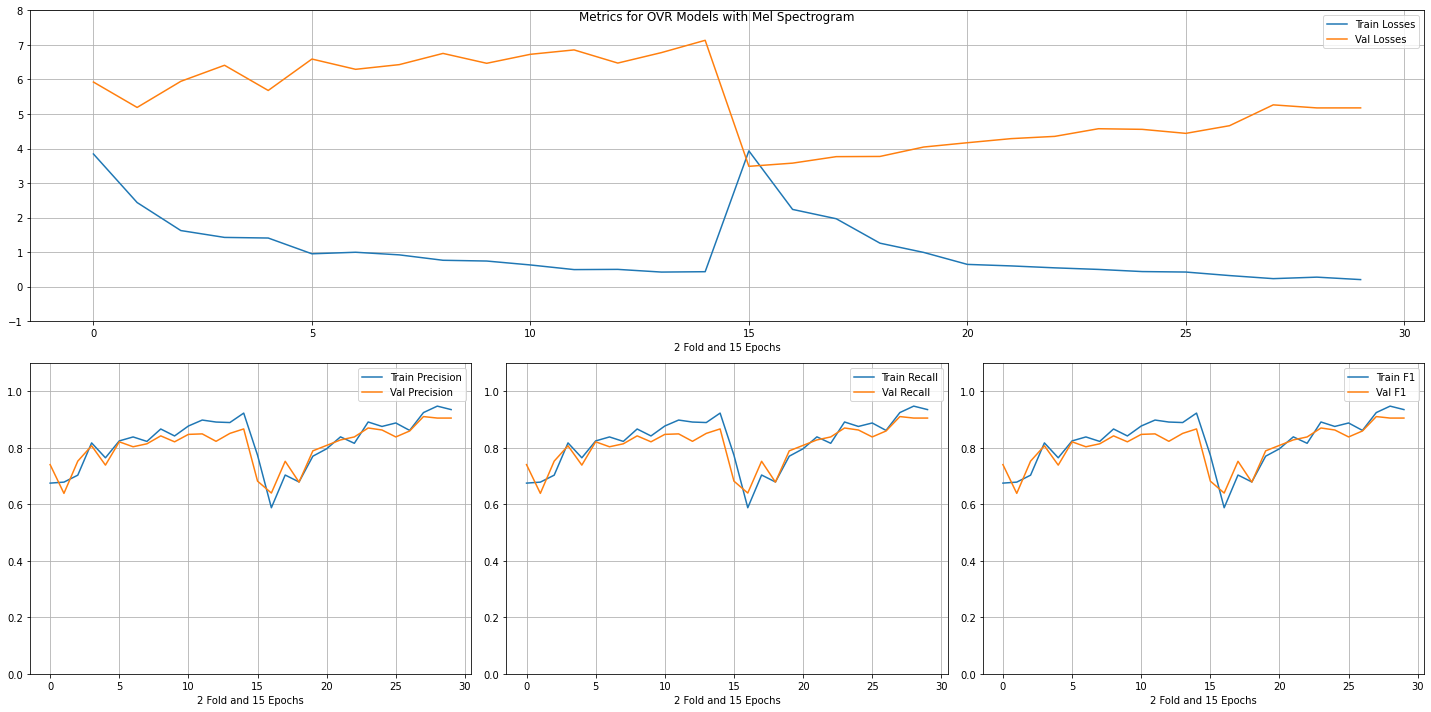

    train_f1  validation_f1  ...  train_losses  validation_losses
12  0.924561       0.910369  ...      0.232412           5.264531
14  0.935088       0.905097  ...      0.204759           5.177031
13  0.947368       0.905097  ...      0.275600           5.176164
8   0.891228       0.869947  ...      0.499497           4.573637
14  0.922671       0.866667  ...      0.433305           7.133884
9   0.875439       0.862917  ...      0.437176           4.555711
11  0.861404       0.859402  ...      0.321427           4.661178
13  0.889279       0.850877  ...      0.422544           6.778073
11  0.898067       0.849123  ...      0.494219           6.855656
10  0.876977       0.847368  ...      0.628660           6.728673
8   0.866432       0.842105  ...      0.764278           6.754524
7   0.815789       0.838313  ...      0.545068           4.352171
10  0.887719       0.838313  ...      0.423474           4.439210
6   0.838596       0.827768  ...      0.601093           4.286543
12  0.8910

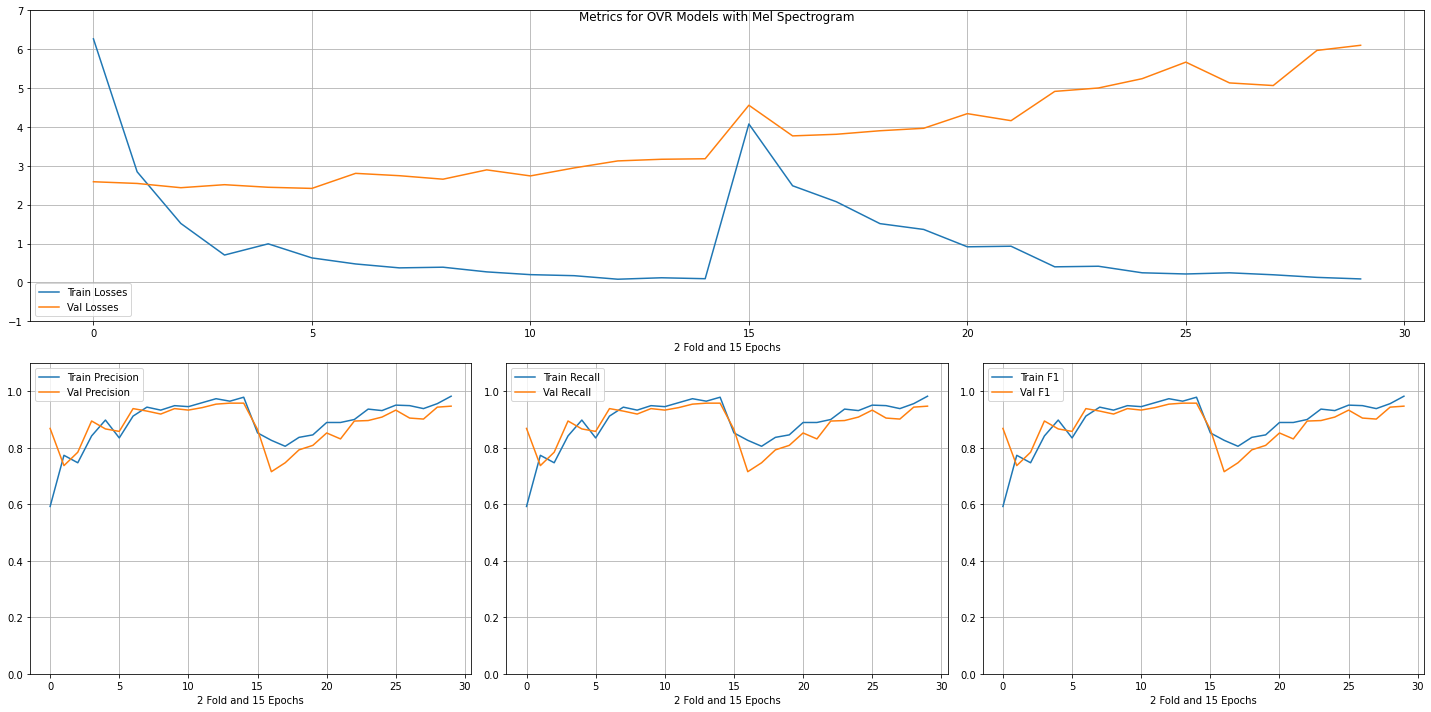

    train_f1  validation_f1  ...  train_losses  validation_losses
14  0.978910       0.957895  ...      0.093701           3.181474
13  0.964851       0.957895  ...      0.117804           3.168217
12  0.973638       0.954386  ...      0.080560           3.125750
14  0.982456       0.947276  ...      0.088246           6.101958
13  0.956140       0.943761  ...      0.127998           5.970183
11  0.959578       0.942105  ...      0.171727           2.945227
9   0.949033       0.938596  ...      0.269547           2.895059
6   0.912127       0.938596  ...      0.473339           2.805559
10  0.945518       0.933333  ...      0.198355           2.739643
10  0.950877       0.933216  ...      0.215532           5.668234
7   0.943761       0.929825  ...      0.372756           2.745412
8   0.933216       0.919298  ...      0.389925           2.655272
9   0.931579       0.908612  ...      0.246059           5.242316
11  0.949123       0.905097  ...      0.245309           5.133209
12  0.9385

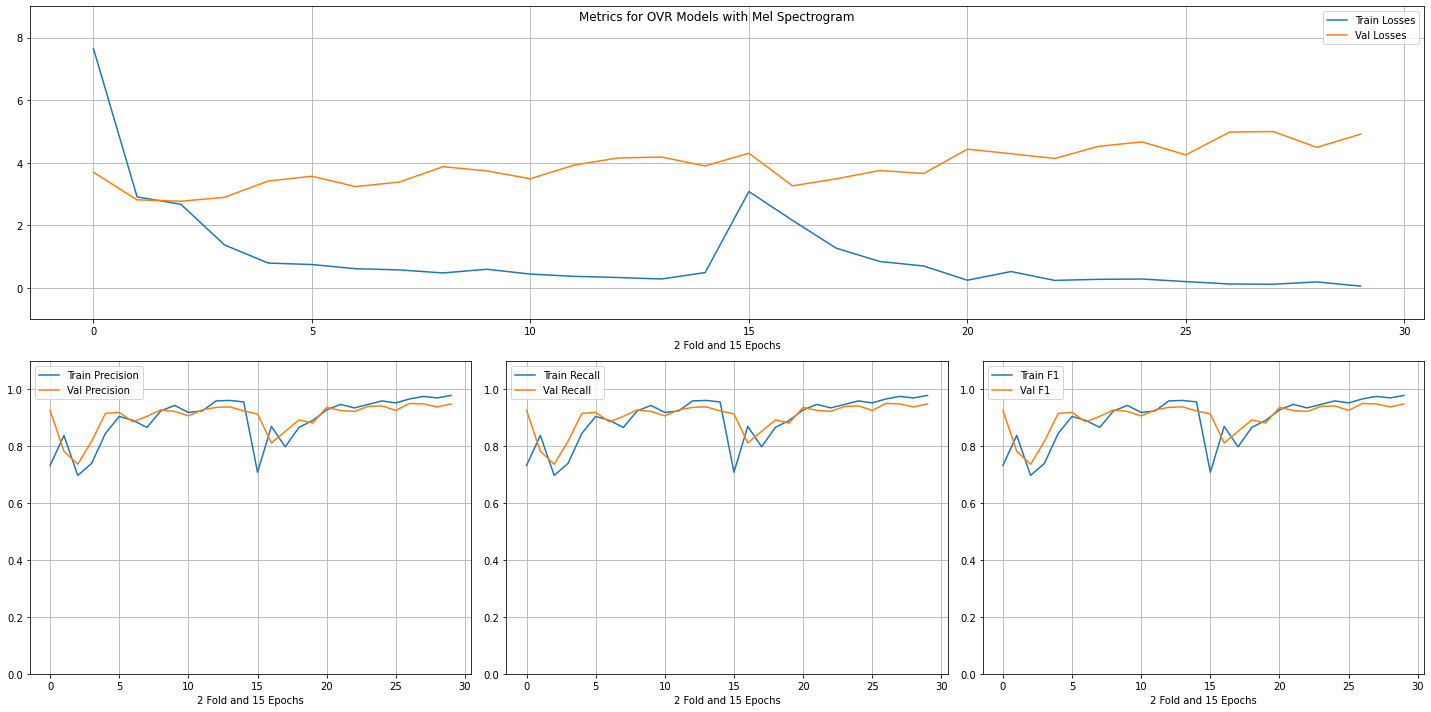

    train_f1  validation_f1  ...  train_losses  validation_losses
11  0.966667       0.950791  ...      0.125544           4.980825
14  0.978947       0.949033  ...      0.056698           4.915923
12  0.975439       0.949033  ...      0.117769           4.999619
9   0.959649       0.942004  ...      0.284458           4.669110
8   0.947368       0.940246  ...      0.274748           4.525652
13  0.961336       0.938596  ...      0.286013           4.183782
13  0.970175       0.938489  ...      0.192226           4.494404
12  0.959578       0.936842  ...      0.332980           4.153791
5   0.928070       0.936731  ...      0.245768           4.436096
11  0.924429       0.928070  ...      0.369760           3.927203
8   0.924429       0.928070  ...      0.478666           3.875316
0   0.732865       0.926316  ...      7.653030           3.697268
6   0.947368       0.926186  ...      0.523509           4.291022
10  0.952632       0.926186  ...      0.202003           4.252222
14  0.9560

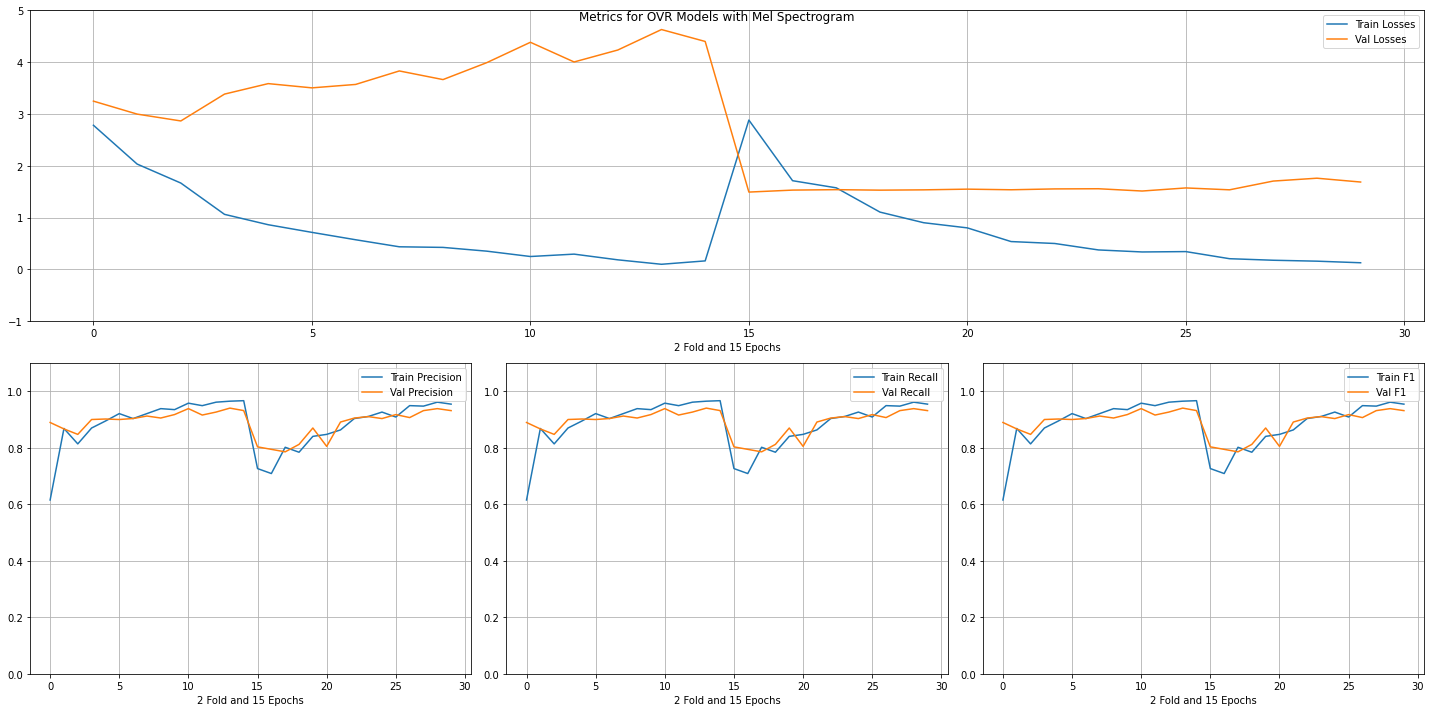

    train_f1  validation_f1  ...  train_losses  validation_losses
13  0.964851       0.940351  ...      0.098915           4.630501
10  0.957821       0.938596  ...      0.248843           4.384610
13  0.961404       0.938489  ...      0.158867           1.760555
14  0.966608       0.931579  ...      0.164138           4.400367
12  0.947368       0.931459  ...      0.176747           1.705219
14  0.954386       0.931459  ...      0.128149           1.686615
12  0.961336       0.926316  ...      0.184734           4.235084
9   0.934974       0.917544  ...      0.352284           3.990618
10  0.908772       0.917399  ...      0.343678           1.572554
11  0.949033       0.915789  ...      0.294752           4.004570
7   0.920914       0.912281  ...      0.436413           3.831163
8   0.910526       0.910369  ...      0.375682           1.557102
11  0.949123       0.906854  ...      0.206468           1.536318
8   0.938489       0.905263  ...      0.424747           3.664463
7   0.9035

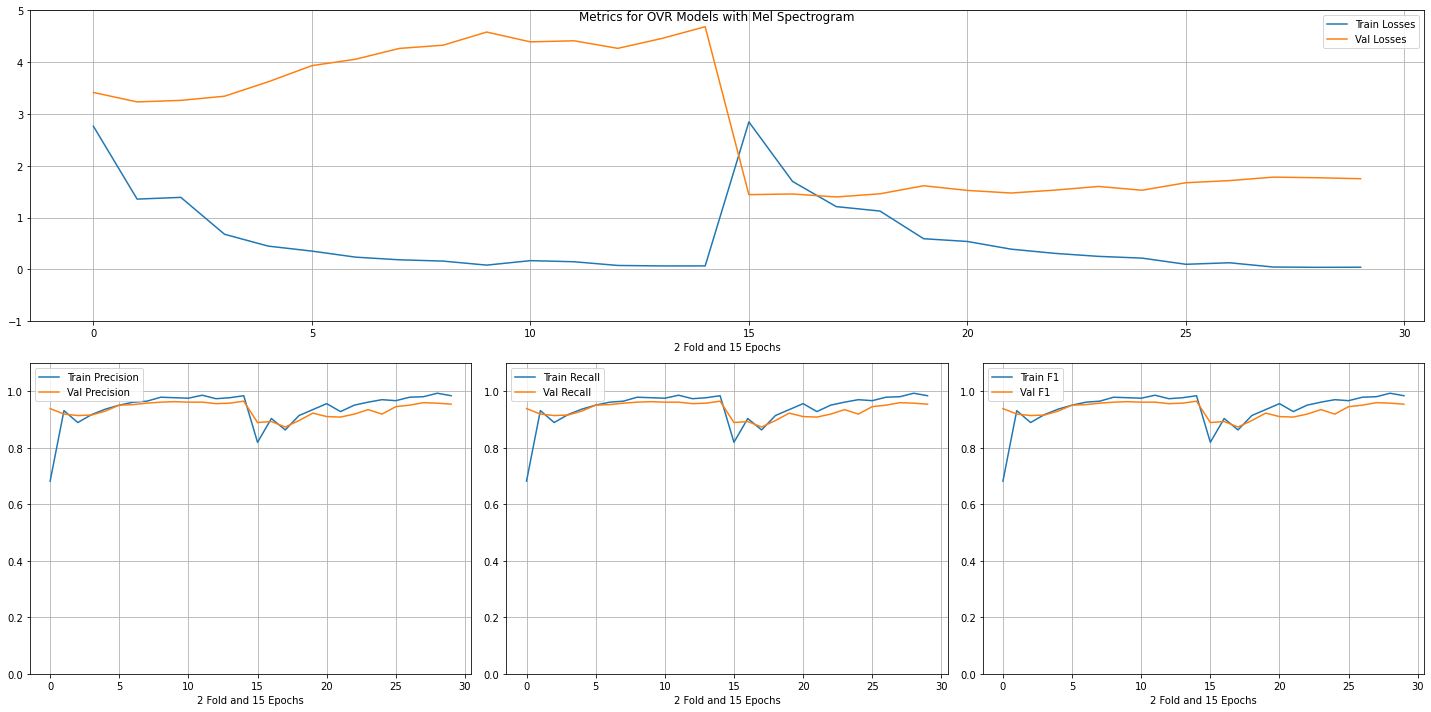

    train_f1  validation_f1  ...  train_losses  validation_losses
14  0.984183       0.964912  ...      0.067180           4.684821
9   0.977153       0.963158  ...      0.082562           4.581812
8   0.978910       0.961404  ...      0.160409           4.328063
10  0.975395       0.961404  ...      0.168967           4.392514
11  0.985940       0.961404  ...      0.147722           4.413192
12  0.980702       0.959578  ...      0.045937           1.781241
7   0.964851       0.957895  ...      0.185253           4.265745
13  0.977153       0.957895  ...      0.066802           4.456485
13  0.992982       0.957821  ...      0.040272           1.769741
12  0.973638       0.956140  ...      0.076236           4.267204
14  0.984211       0.954306  ...      0.041960           1.750474
6   0.961336       0.952632  ...      0.236458           4.057735
5   0.950791       0.950877  ...      0.353270           3.933618
11  0.978947       0.950791  ...      0.128127           1.714353
10  0.9666

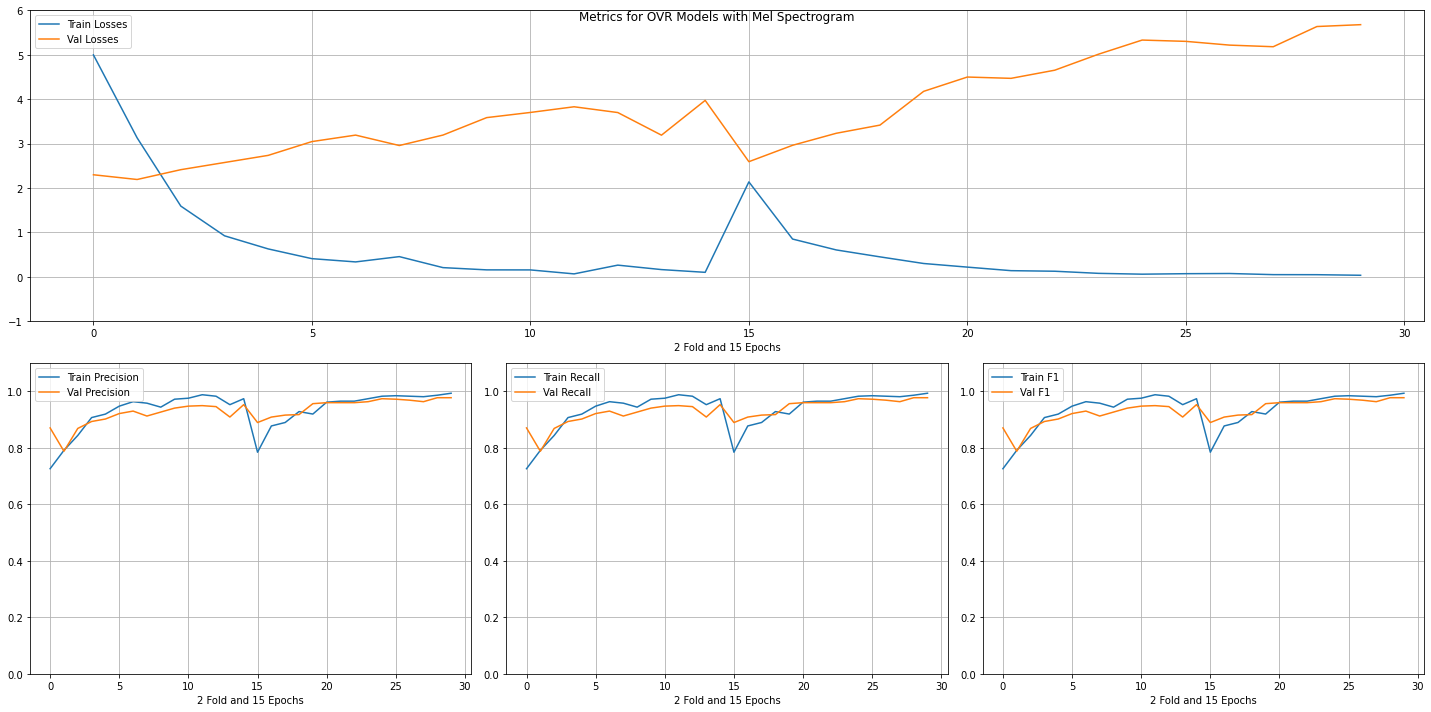

    train_f1  validation_f1  ...  train_losses  validation_losses
14  0.992982       0.977153  ...      0.034407           5.678726
13  0.985965       0.977153  ...      0.047483           5.636807
9   0.982456       0.973638  ...      0.058988           5.331767
10  0.984211       0.971880  ...      0.070138           5.302651
11  0.982456       0.968366  ...      0.074256           5.218155
8   0.973684       0.963093  ...      0.077788           5.013046
12  0.980702       0.963093  ...      0.048851           5.181787
7   0.964912       0.959578  ...      0.125281           4.653177
5   0.961404       0.959578  ...      0.218013           4.499127
6   0.964912       0.959578  ...      0.138290           4.469812
4   0.919298       0.956063  ...      0.299607           4.176944
14  0.973638       0.952632  ...      0.100680           3.973232
11  0.987698       0.949123  ...      0.065759           3.829469
10  0.975395       0.947368  ...      0.154974           3.701610
12  0.9824

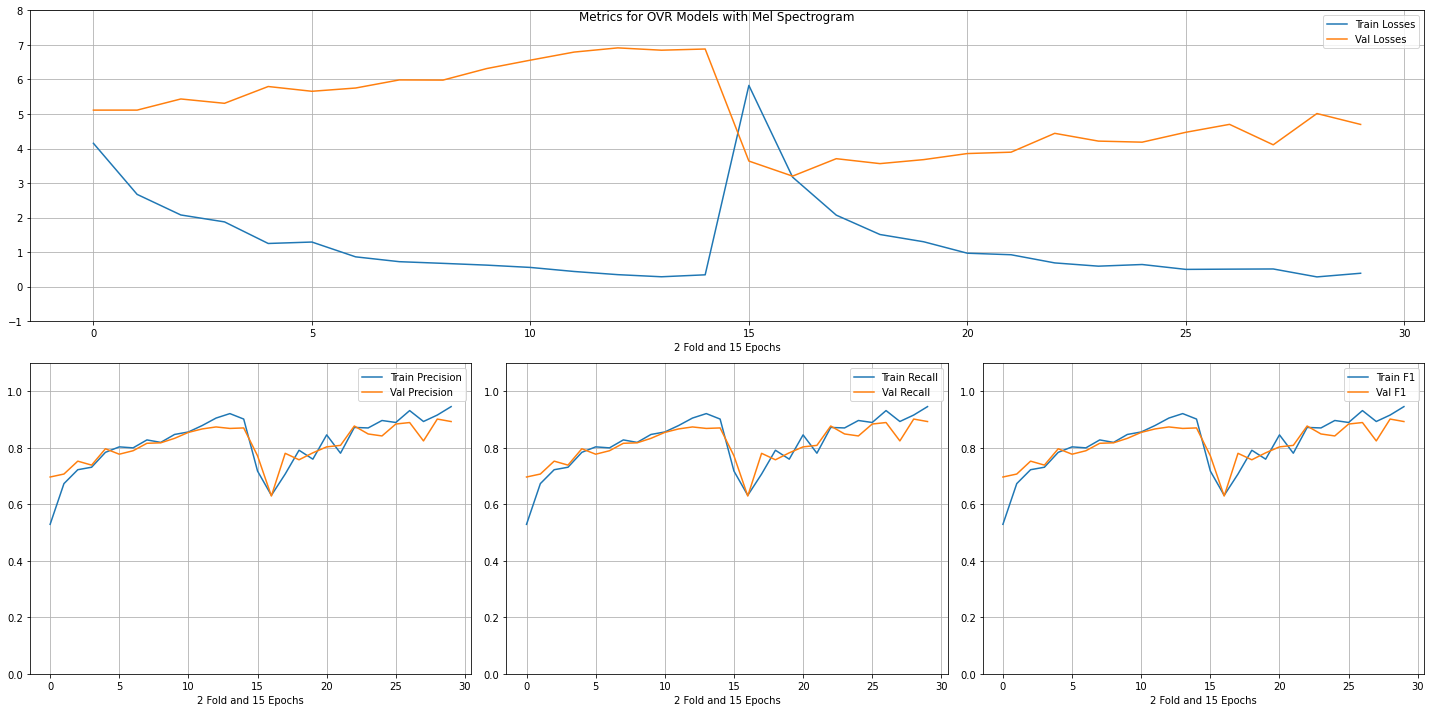

    train_f1  validation_f1  ...  train_losses  validation_losses
13  0.915789       0.901582  ...      0.282697           5.013369
14  0.945614       0.892794  ...      0.388451           4.697791
11  0.931579       0.889279  ...      0.507243           4.699976
10  0.889474       0.884007  ...      0.500252           4.470524
7   0.871930       0.876977  ...      0.688008           4.440036
12  0.905097       0.873684  ...      0.347956           6.914702
14  0.901582       0.870175  ...      0.343117           6.881768
13  0.920914       0.868421  ...      0.286557           6.847580
11  0.878735       0.866667  ...      0.439717           6.792896
10  0.855888       0.854386  ...      0.556860           6.559259
8   0.870175       0.848858  ...      0.593521           4.215157
9   0.896491       0.841828  ...      0.641534           4.184224
9   0.847100       0.833333  ...      0.623651           6.315697
12  0.892982       0.824253  ...      0.512611           4.107993
8   0.8189

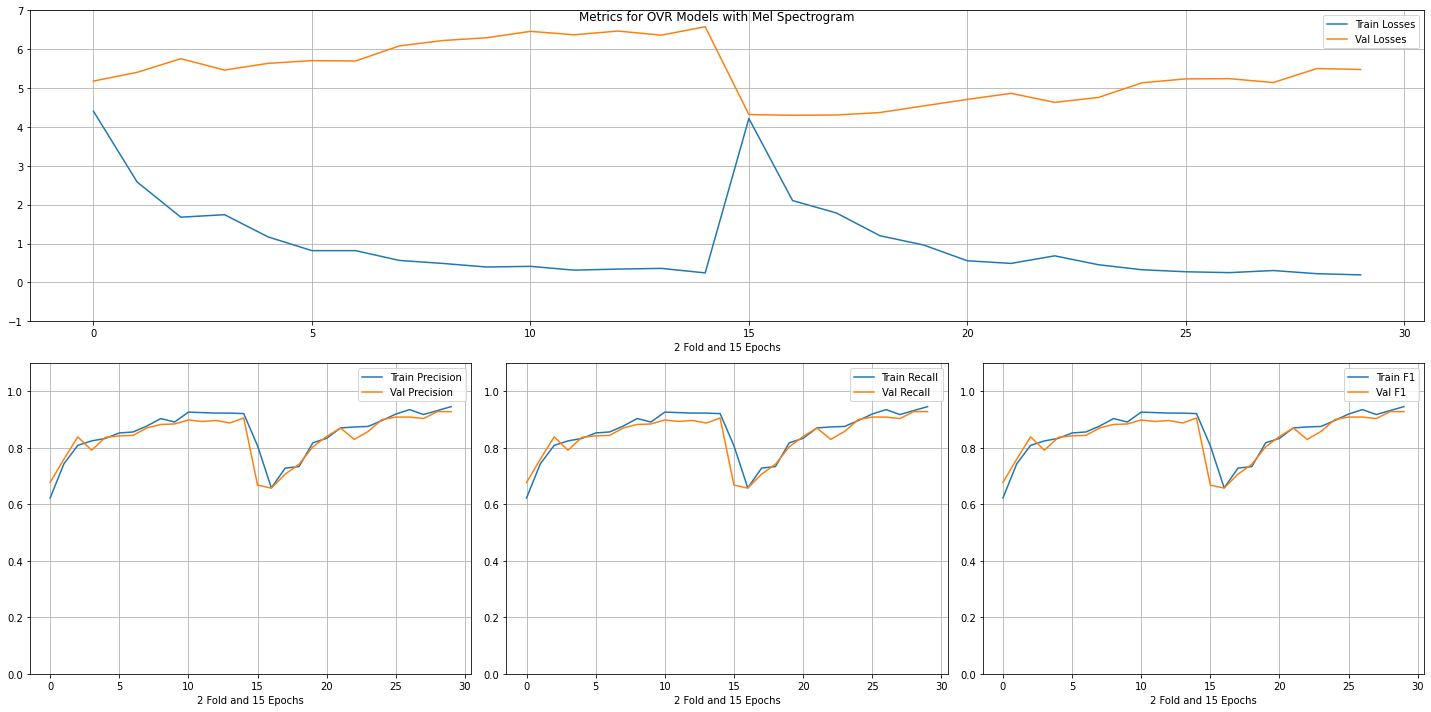

    train_f1  validation_f1  ...  train_losses  validation_losses
14  0.945614       0.927944  ...      0.192575           5.479618
13  0.931579       0.927944  ...      0.222698           5.503029
10  0.919298       0.908612  ...      0.272166           5.237317
11  0.935088       0.908612  ...      0.250217           5.242419
14  0.920914       0.905263  ...      0.243189           6.579251
12  0.917544       0.903339  ...      0.304124           5.143092
9   0.896491       0.899824  ...      0.324117           5.137127
10  0.926186       0.898246  ...      0.411582           6.460864
12  0.922671       0.896491  ...      0.341407           6.468317
11  0.924429       0.892982  ...      0.314016           6.372012
13  0.922671       0.887719  ...      0.359193           6.362961
9   0.891037       0.884211  ...      0.394961           6.295650
8   0.903339       0.882456  ...      0.486298           6.224994
7   0.876977       0.870175  ...      0.564119           6.085883
6   0.8701

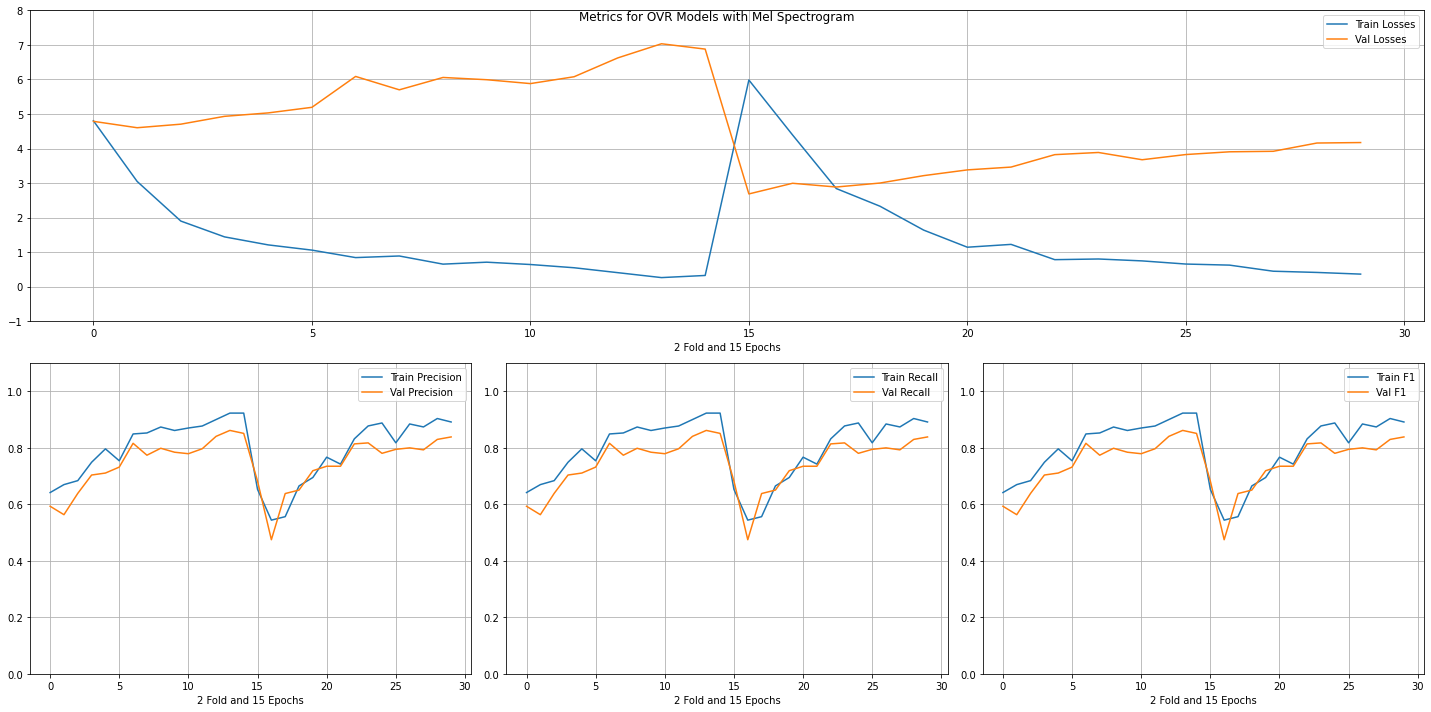

    train_f1  validation_f1  ...  train_losses  validation_losses
13  0.922671       0.861404  ...      0.262649           7.034050
14  0.922671       0.850877  ...      0.324342           6.879190
12  0.899824       0.840351  ...      0.405668           6.624425
14  0.891228       0.838313  ...      0.363445           4.173250
13  0.903509       0.829525  ...      0.412002           4.159507
8   0.877193       0.817223  ...      0.801443           3.885693
6   0.848858       0.815789  ...      0.841837           6.087691
7   0.831579       0.813708  ...      0.782074           3.822932
11  0.884211       0.799649  ...      0.623735           3.905416
8   0.873462       0.798246  ...      0.652513           6.057949
11  0.876977       0.796491  ...      0.547780           6.078762
10  0.817544       0.794376  ...      0.654959           3.826011
12  0.873684       0.792619  ...      0.447326           3.919935
9   0.861160       0.784211  ...      0.708984           5.992755
9   0.8877

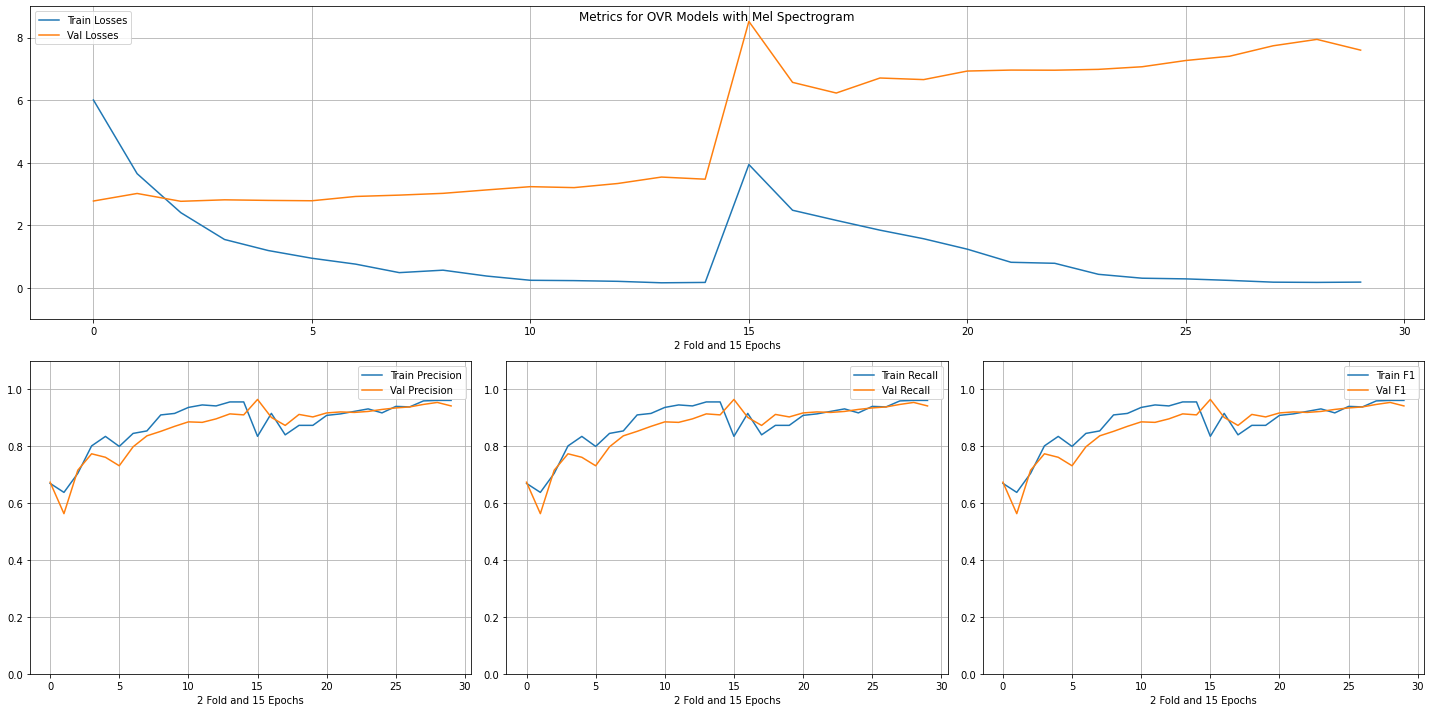

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.835088       0.964851  ...      3.944273           8.519289
13  0.961404       0.954306  ...      0.176548           7.945373
12  0.959649       0.947276  ...      0.183871           7.741511
14  0.961404       0.942004  ...      0.185909           7.601602
11  0.938596       0.938489  ...      0.240543           7.406347
10  0.940351       0.934974  ...      0.288891           7.270441
9   0.917544       0.929701  ...      0.310418           7.070596
8   0.931579       0.922671  ...      0.434774           6.987144
6   0.914035       0.920914  ...      0.819495           6.964439
7   0.922807       0.919156  ...      0.787148           6.960392
5   0.908772       0.917399  ...      1.238020           6.933458
13  0.956063       0.914035  ...      0.163926           3.544125
3   0.873684       0.912127  ...      1.846633           6.710790
14  0.956063       0.910526  ...      0.175644           3.476054
4   0.8736

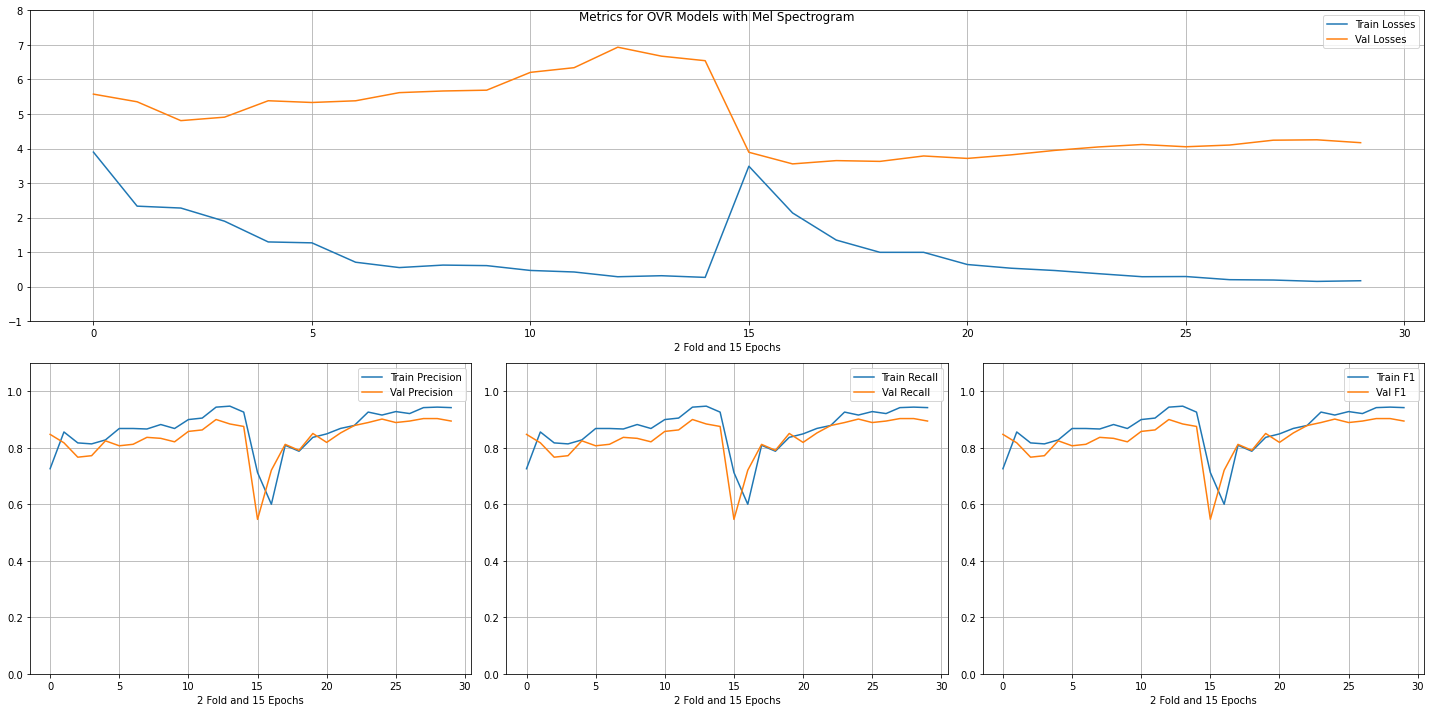

    train_f1  validation_f1  ...  train_losses  validation_losses
13  0.943860       0.903339  ...      0.152590           4.252751
12  0.942105       0.903339  ...      0.192141           4.241493
9   0.915789       0.901582  ...      0.288065           4.116926
12  0.943761       0.900000  ...      0.287321           6.934566
14  0.942105       0.894552  ...      0.171708           4.169218
11  0.921053       0.894552  ...      0.202347           4.101040
10  0.928070       0.889279  ...      0.293547           4.051496
8   0.926316       0.889279  ...      0.376029           4.045959
13  0.947276       0.884211  ...      0.317036           6.674796
7   0.878947       0.878735  ...      0.467796           3.946158
14  0.926186       0.875439  ...      0.268711           6.543497
11  0.905097       0.863158  ...      0.425099           6.341048
10  0.899824       0.857895  ...      0.469608           6.206091
6   0.868421       0.852373  ...      0.534412           3.816579
4   0.8368

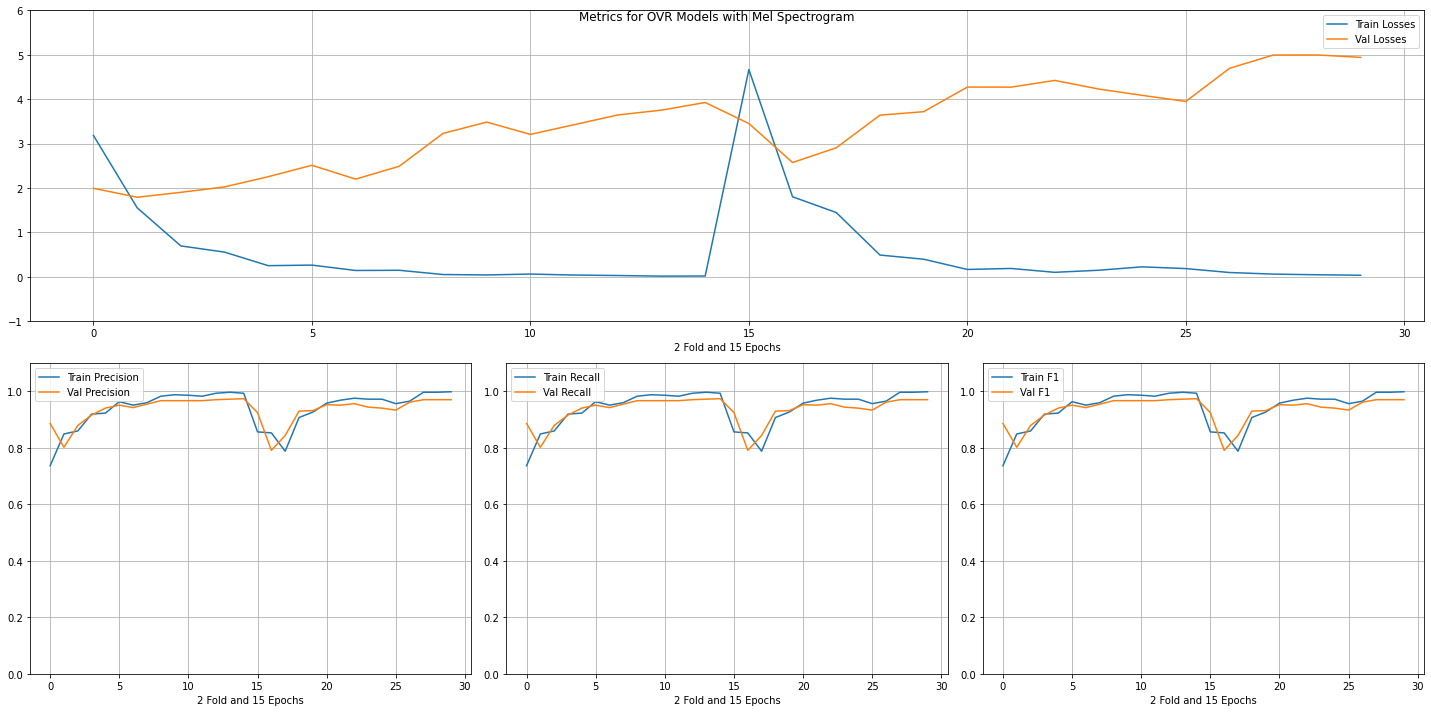

    train_f1  validation_f1  ...  train_losses  validation_losses
14  0.992970       0.973684  ...      0.017630           3.926064
13  0.996485       0.971930  ...      0.015016           3.753779
12  0.992970       0.970175  ...      0.028797           3.644890
14  0.998246       0.970123  ...      0.034808           4.942860
13  0.996491       0.970123  ...      0.046031           4.996592
12  0.996491       0.970123  ...      0.060459           4.994502
9   0.987698       0.966667  ...      0.041656           3.484140
10  0.985940       0.966667  ...      0.061572           3.207413
11  0.982425       0.966667  ...      0.039605           3.425679
8   0.982425       0.966667  ...      0.051339           3.229408
11  0.964912       0.961336  ...      0.096536           4.695770
7   0.975439       0.956063  ...      0.100929           4.423129
7   0.959578       0.954386  ...      0.146550           2.490630
5   0.957895       0.952548  ...      0.165262           4.273030
5   0.9630

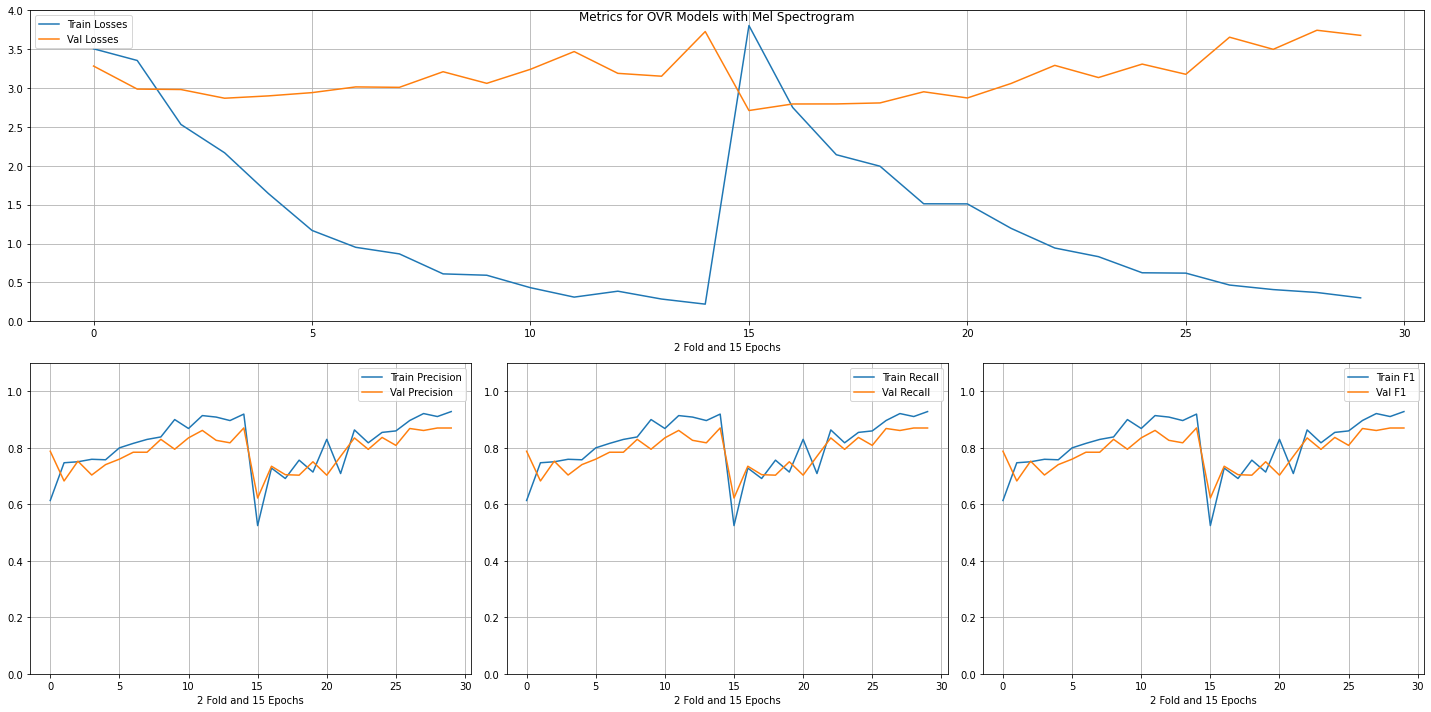

    train_f1  validation_f1  ...  train_losses  validation_losses
14  0.919156       0.870175  ...      0.219478           3.727981
14  0.928070       0.869947  ...      0.300473           3.678657
13  0.910526       0.869947  ...      0.369503           3.744542
11  0.896491       0.868190  ...      0.465292           3.655131
11  0.913884       0.861404  ...      0.309995           3.470247
12  0.921053       0.861160  ...      0.406903           3.499021
9   0.854386       0.836555  ...      0.623226           3.308951
10  0.868190       0.835088  ...      0.431112           3.242104
7   0.863158       0.834798  ...      0.942066           3.292451
8   0.838313       0.829825  ...      0.608999           3.210728
12  0.908612       0.826316  ...      0.386208           3.189837
13  0.896309       0.817544  ...      0.285091           3.153027
10  0.859649       0.808436  ...      0.618614           3.177696
9   0.899824       0.794737  ...      0.591542           3.061216
8   0.8175

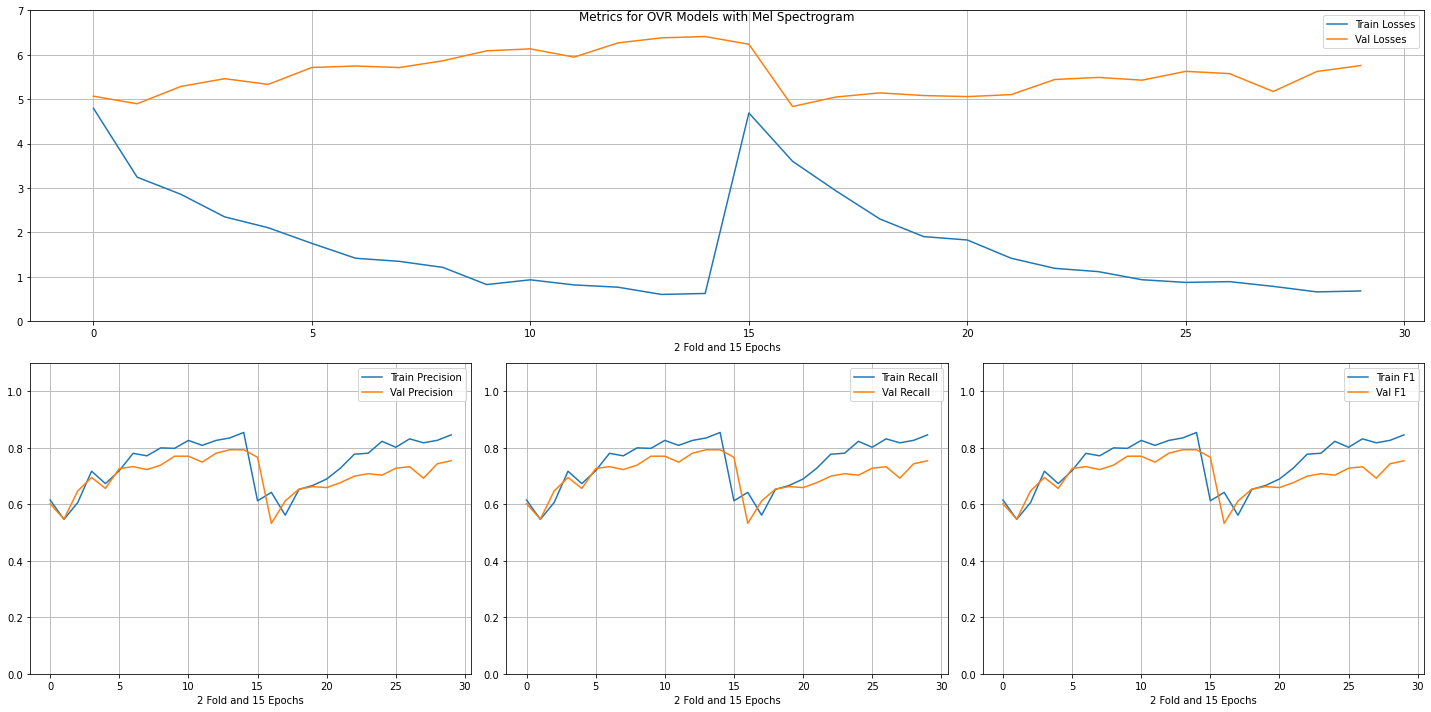

    train_f1  validation_f1  ...  train_losses  validation_losses
14  0.854130       0.792982  ...      0.624496           6.411163
13  0.834798       0.792982  ...      0.602707           6.381792
12  0.826011       0.780702  ...      0.766322           6.267187
9   0.797891       0.770175  ...      0.825201           6.089667
10  0.826011       0.770175  ...      0.932085           6.133404
0   0.612281       0.766257  ...      4.690219           6.237943
14  0.845614       0.753954  ...      0.680804           5.758042
11  0.808436       0.749123  ...      0.817057           5.947743
13  0.826316       0.743409  ...      0.659894           5.624394
8   0.799649       0.738596  ...      1.211233           5.865943
6   0.780316       0.733333  ...      1.418030           5.747251
11  0.831579       0.732865  ...      0.890953           5.575926
10  0.801754       0.727592  ...      0.873318           5.627557
5   0.718805       0.726316  ...      1.752263           5.714695
7   0.7715

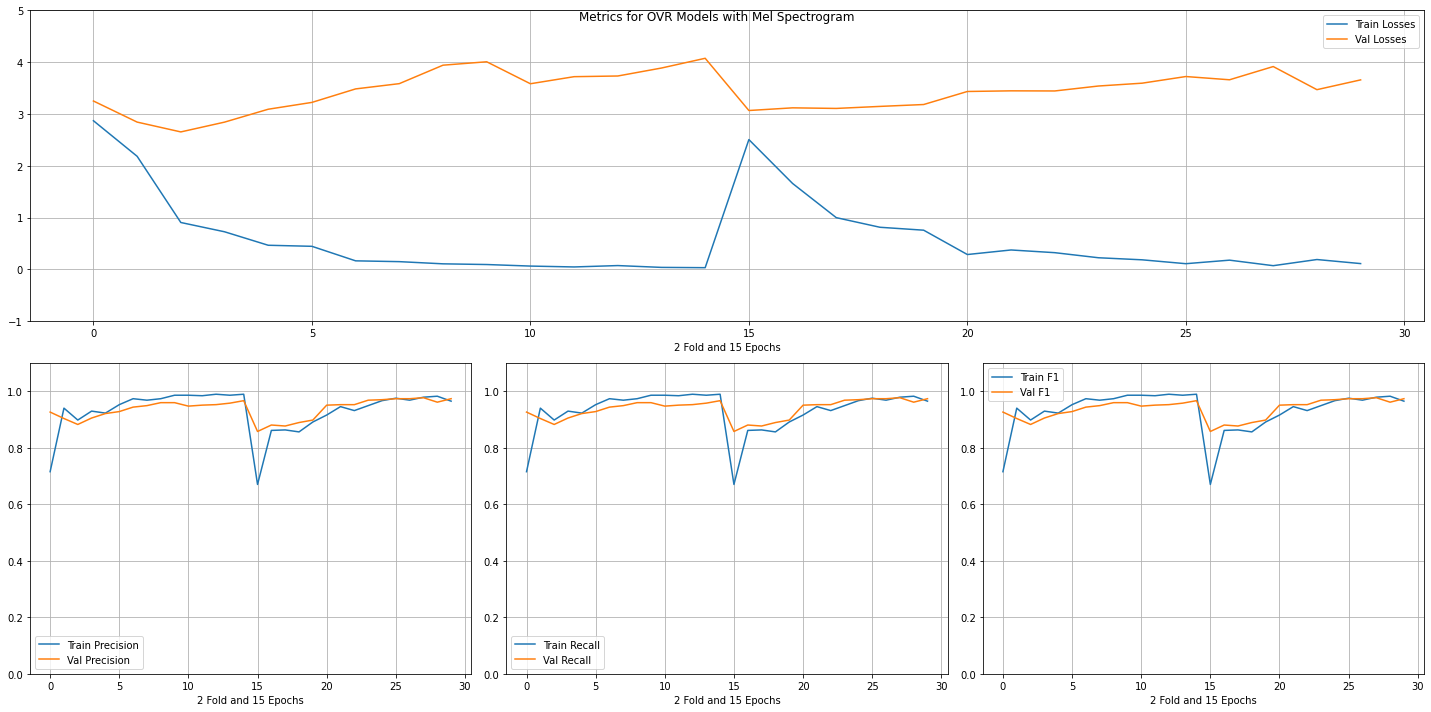

    train_f1  validation_f1  ...  train_losses  validation_losses
12  0.978947       0.977153  ...      0.071761           3.916156
14  0.964912       0.973638  ...      0.112182           3.658592
11  0.968421       0.973638  ...      0.178362           3.660627
10  0.975439       0.973638  ...      0.110188           3.723261
9   0.966667       0.970123  ...      0.184947           3.594986
8   0.949123       0.968366  ...      0.224937           3.540211
14  0.989455       0.966667  ...      0.033245           4.075503
13  0.982456       0.961336  ...      0.190571           3.469638
8   0.973638       0.959649  ...      0.107468           3.942421
9   0.985940       0.959649  ...      0.094073           4.008205
13  0.985940       0.957895  ...      0.038796           3.887554
12  0.989455       0.952632  ...      0.073959           3.733601
7   0.931579       0.952548  ...      0.322962           3.444748
6   0.945614       0.952548  ...      0.375058           3.447109
11  0.9841

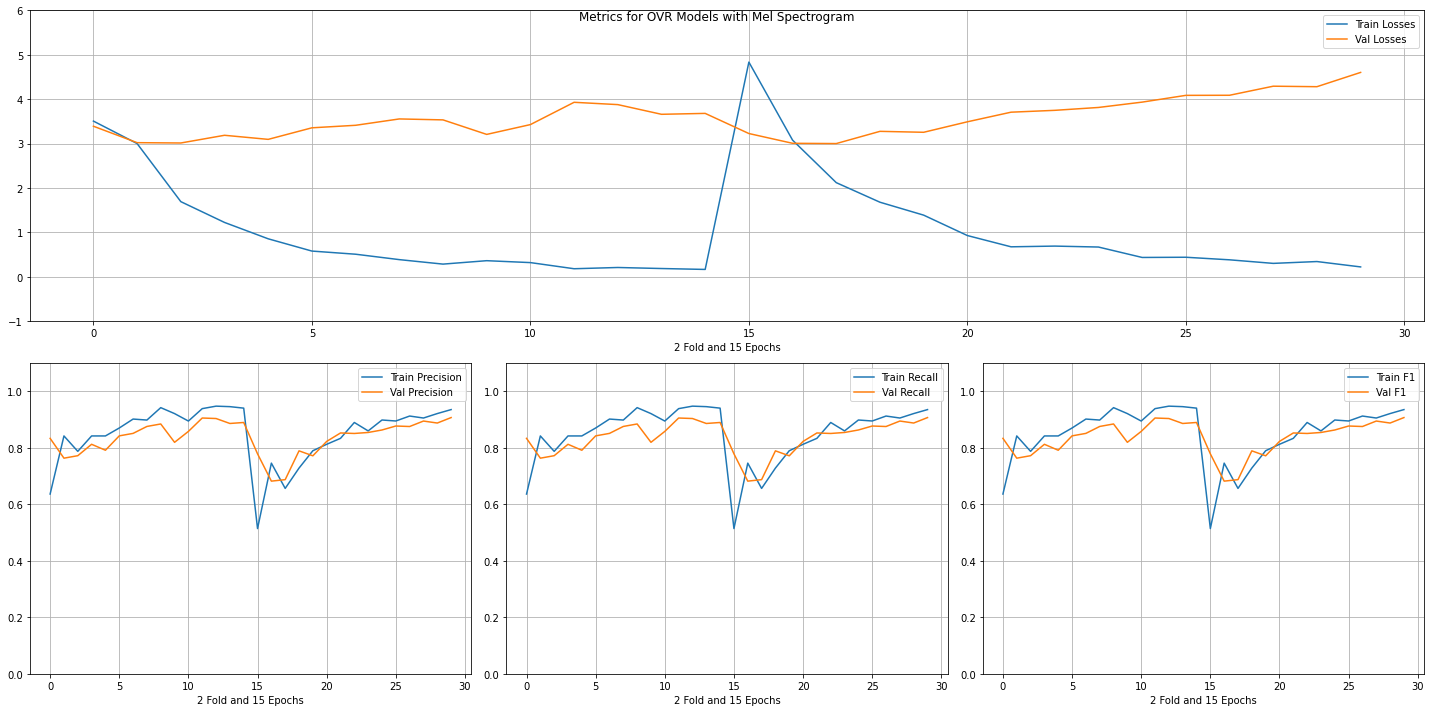

    train_f1  validation_f1  ...  train_losses  validation_losses
14  0.935088       0.906854  ...      0.222550           4.603215
11  0.938489       0.905263  ...      0.181556           3.930230
12  0.947276       0.903509  ...      0.209712           3.878130
12  0.905263       0.894552  ...      0.302212           4.292742
14  0.940246       0.889474  ...      0.165991           3.680339
13  0.921053       0.887522  ...      0.343572           4.281638
13  0.945518       0.885965  ...      0.186391           3.659908
8   0.942004       0.884211  ...      0.285822           3.534218
10  0.894737       0.876977  ...      0.440317           4.086461
7   0.898067       0.875439  ...      0.386793           3.555507
11  0.912281       0.875220  ...      0.382455           4.088631
9   0.898246       0.862917  ...      0.435691           3.934246
10  0.894552       0.857895  ...      0.319810           3.428164
8   0.859649       0.854130  ...      0.670344           3.813993
6   0.8333

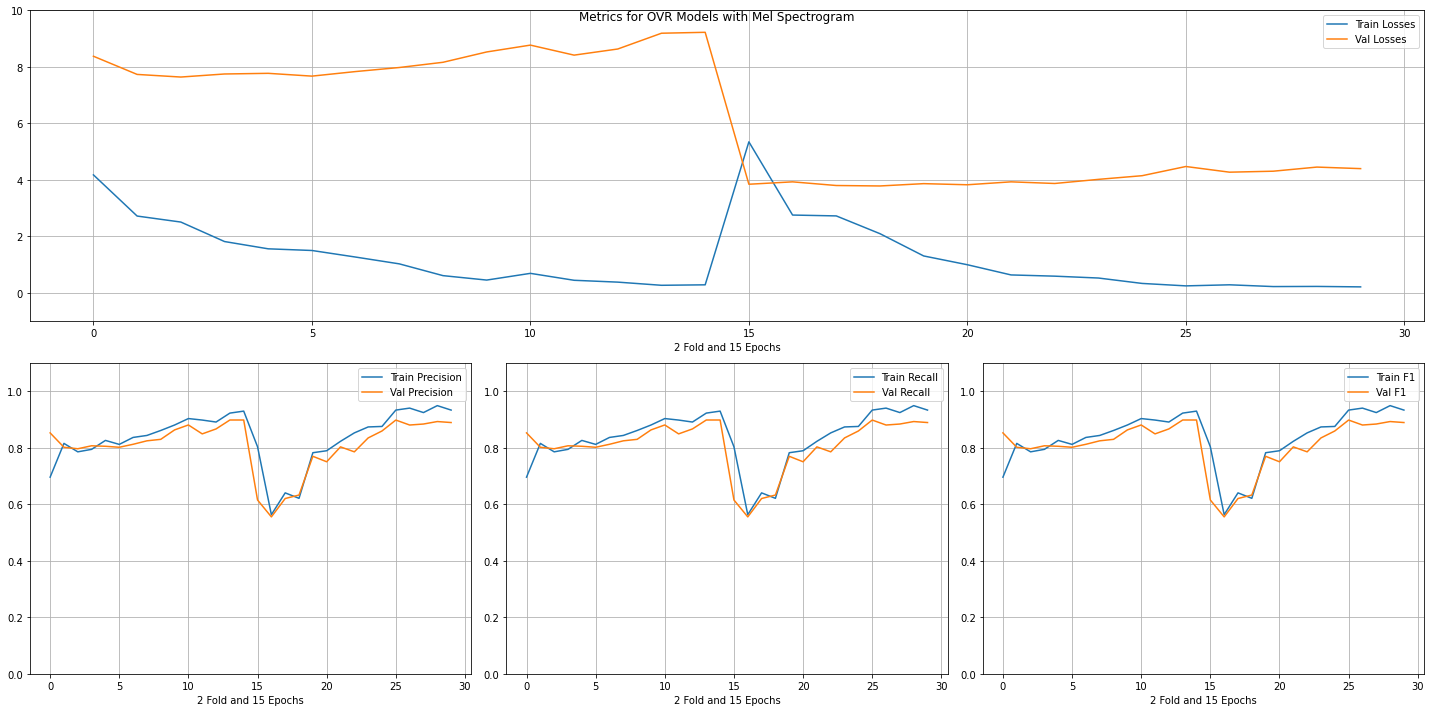

    train_f1  validation_f1  ...  train_losses  validation_losses
14  0.929701       0.898246  ...      0.287497           9.224684
13  0.922671       0.898246  ...      0.270908           9.192229
10  0.933333       0.898067  ...      0.250195           4.475094
13  0.949123       0.892794  ...      0.230766           4.454599
14  0.933333       0.889279  ...      0.214728           4.400022
12  0.924561       0.884007  ...      0.225812           4.308754
10  0.903339       0.880702  ...      0.693365           8.771484
11  0.940351       0.880492  ...      0.288121           4.274190
12  0.891037       0.866667  ...      0.382716           8.633970
9   0.880492       0.863158  ...      0.455582           8.529250
9   0.875439       0.859402  ...      0.336807           4.149743
0   0.695958       0.852632  ...      4.178760           8.377415
11  0.898067       0.849123  ...      0.448117           8.416832
8   0.873684       0.834798  ...      0.527972           4.019969
8   0.8611

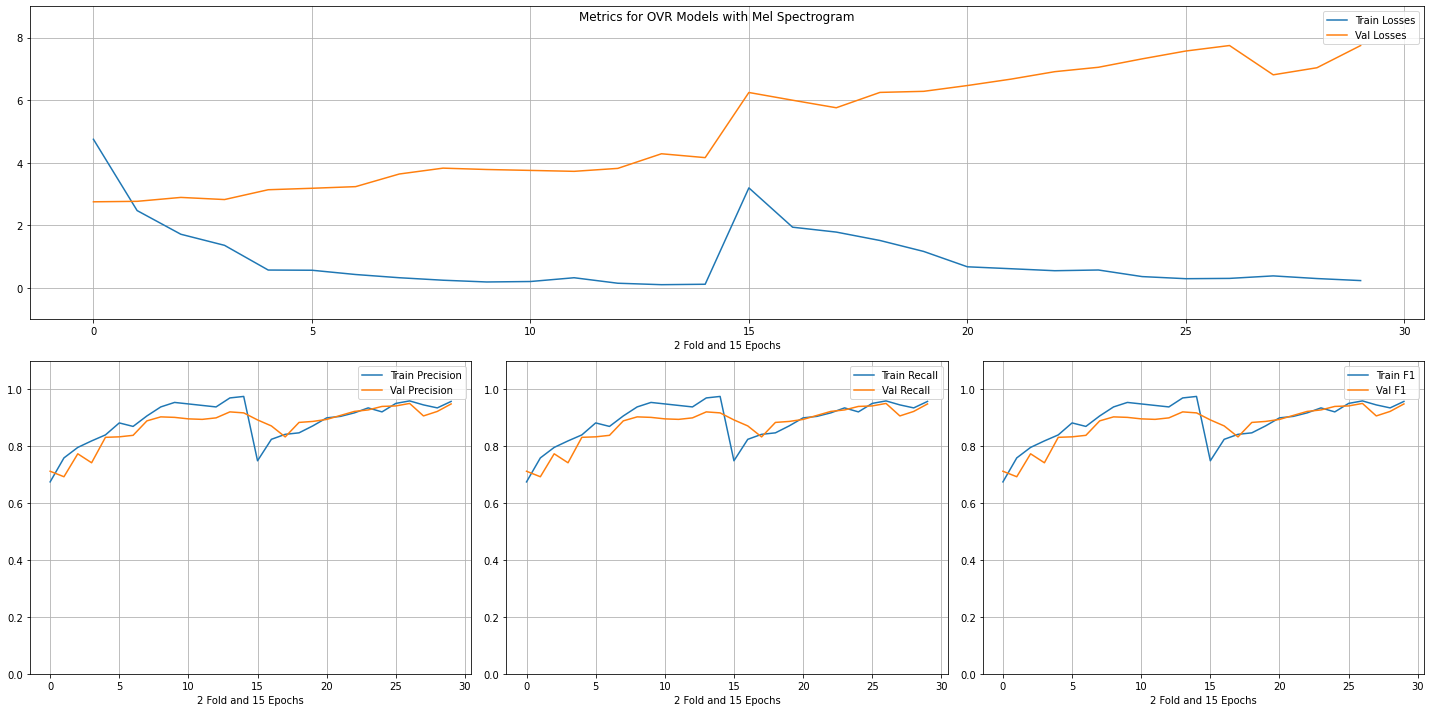

    train_f1  validation_f1  ...  train_losses  validation_losses
11  0.959649       0.950791  ...      0.304497           7.749039
14  0.957895       0.949033  ...      0.234640           7.748479
10  0.950877       0.942004  ...      0.294765           7.573613
9   0.921053       0.940246  ...      0.362298           7.322921
8   0.935088       0.927944  ...      0.572886           7.053878
13  0.935088       0.922671  ...      0.299667           7.038760
7   0.917544       0.922671  ...      0.550064           6.913241
13  0.970123       0.921053  ...      0.103496           4.288965
14  0.975395       0.917544  ...      0.117380           4.165211
6   0.905263       0.908612  ...      0.613342           6.675020
12  0.945614       0.906854  ...      0.384402           6.812758
8   0.938489       0.903509  ...      0.246264           3.829228
9   0.954306       0.901754  ...      0.190099           3.785847
12  0.938489       0.900000  ...      0.149885           3.821366
10  0.9490

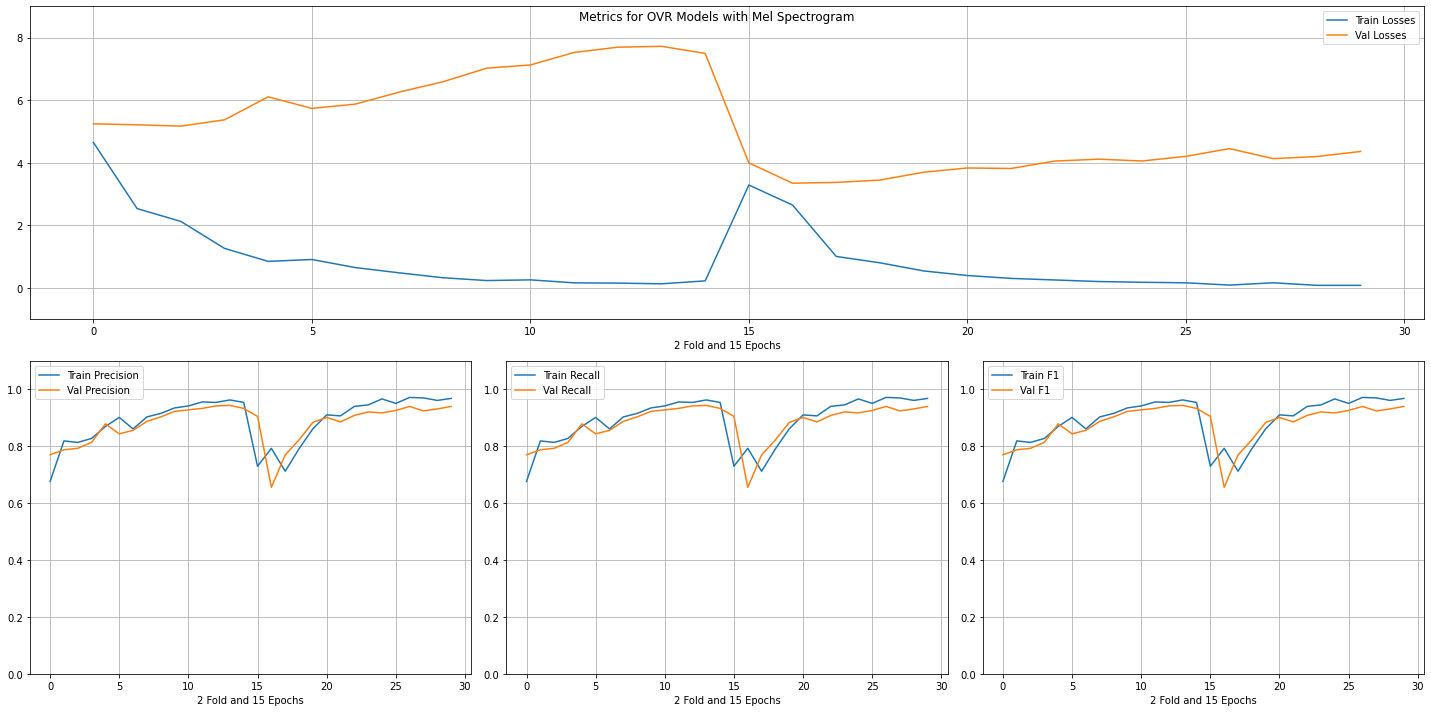

    train_f1  validation_f1  ...  train_losses  validation_losses
13  0.963093       0.943860  ...      0.131470           7.724029
12  0.954306       0.942105  ...      0.153492           7.696113
14  0.968421       0.940246  ...      0.082538           4.362347
11  0.971930       0.940246  ...      0.090915           4.453466
14  0.954306       0.933333  ...      0.225085           7.497133
11  0.956063       0.933333  ...      0.162006           7.527731
13  0.961404       0.931459  ...      0.082518           4.201195
10  0.942004       0.928070  ...      0.257573           7.127323
10  0.950877       0.926186  ...      0.163615           4.205853
12  0.970175       0.924429  ...      0.163776           4.132920
9   0.934974       0.922807  ...      0.235182           7.025857
8   0.945614       0.920914  ...      0.204240           4.116148
9   0.966667       0.917399  ...      0.180059           4.057388
7   0.940351       0.908612  ...      0.254297           4.055034
0   0.7298

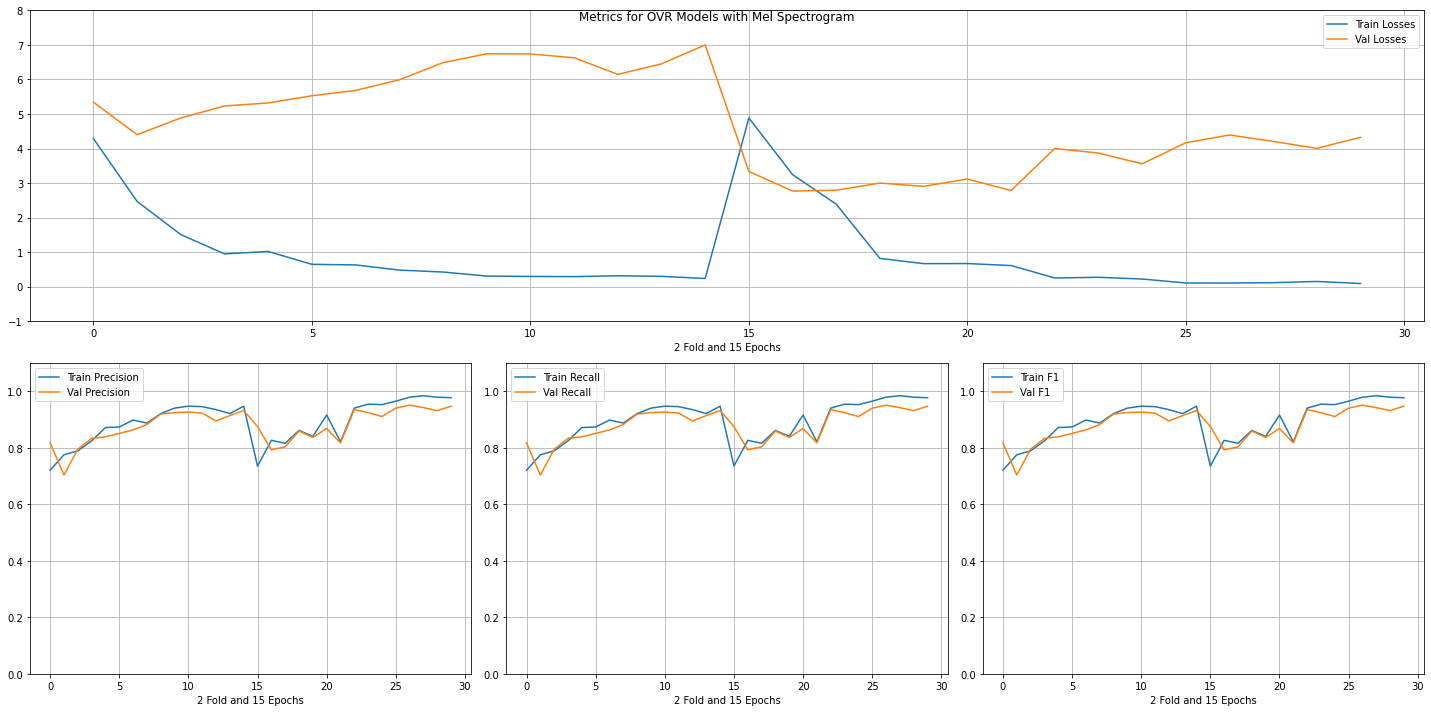

    train_f1  validation_f1  ...  train_losses  validation_losses
11  0.978947       0.950791  ...      0.106169           4.392065
14  0.977193       0.947276  ...      0.090709           4.326186
12  0.984211       0.942004  ...      0.115054           4.206821
10  0.964912       0.940246  ...      0.106723           4.167054
7   0.940351       0.934974  ...      0.251613           4.001116
14  0.947276       0.931579  ...      0.236769           7.001825
13  0.978947       0.931459  ...      0.151119           4.005231
10  0.947276       0.926316  ...      0.296139           6.738635
9   0.940246       0.924561  ...      0.307296           6.744516
8   0.954386       0.924429  ...      0.271577           3.869269
11  0.945518       0.922807  ...      0.291021           6.628889
8   0.920914       0.919298  ...      0.423733           6.486366
13  0.920914       0.914035  ...      0.299075           6.451913
9   0.952632       0.910369  ...      0.220753           3.557760
12  0.9349

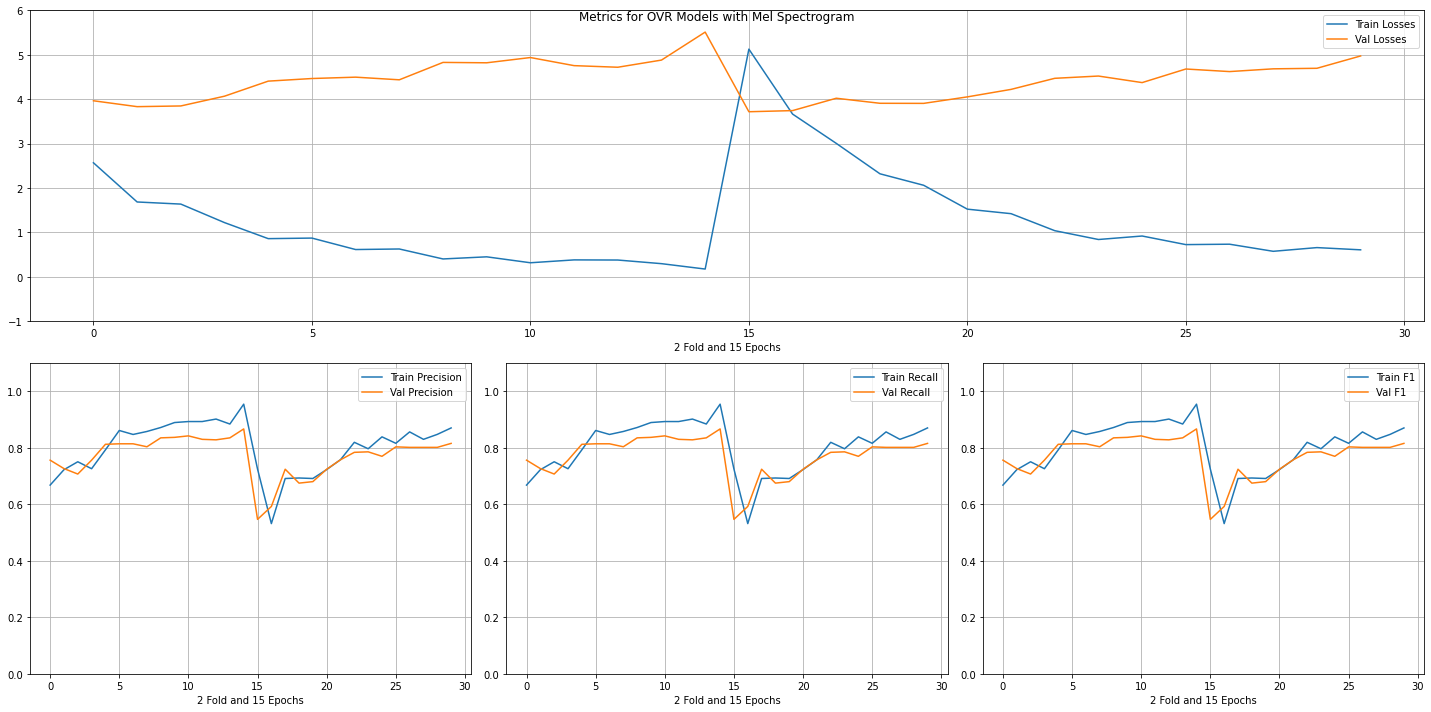

    train_f1  validation_f1  ...  train_losses  validation_losses
14  0.954306       0.866667  ...      0.174572           5.511450
10  0.892794       0.842105  ...      0.316271           4.938425
9   0.889279       0.836842  ...      0.449831           4.820004
8   0.871705       0.835088  ...      0.402017           4.828542
13  0.884007       0.835088  ...      0.295840           4.880996
11  0.892794       0.829825  ...      0.380793           4.755931
12  0.901582       0.828070  ...      0.377673           4.719829
14  0.870175       0.815466  ...      0.607454           4.973887
6   0.847100       0.814035  ...      0.614057           4.496324
5   0.861160       0.814035  ...      0.871987           4.465727
4   0.792619       0.812281  ...      0.859445           4.406824
7   0.857645       0.803509  ...      0.626496           4.436837
10  0.815789       0.803163  ...      0.725079           4.679975
12  0.829825       0.801406  ...      0.574210           4.683963
13  0.8473

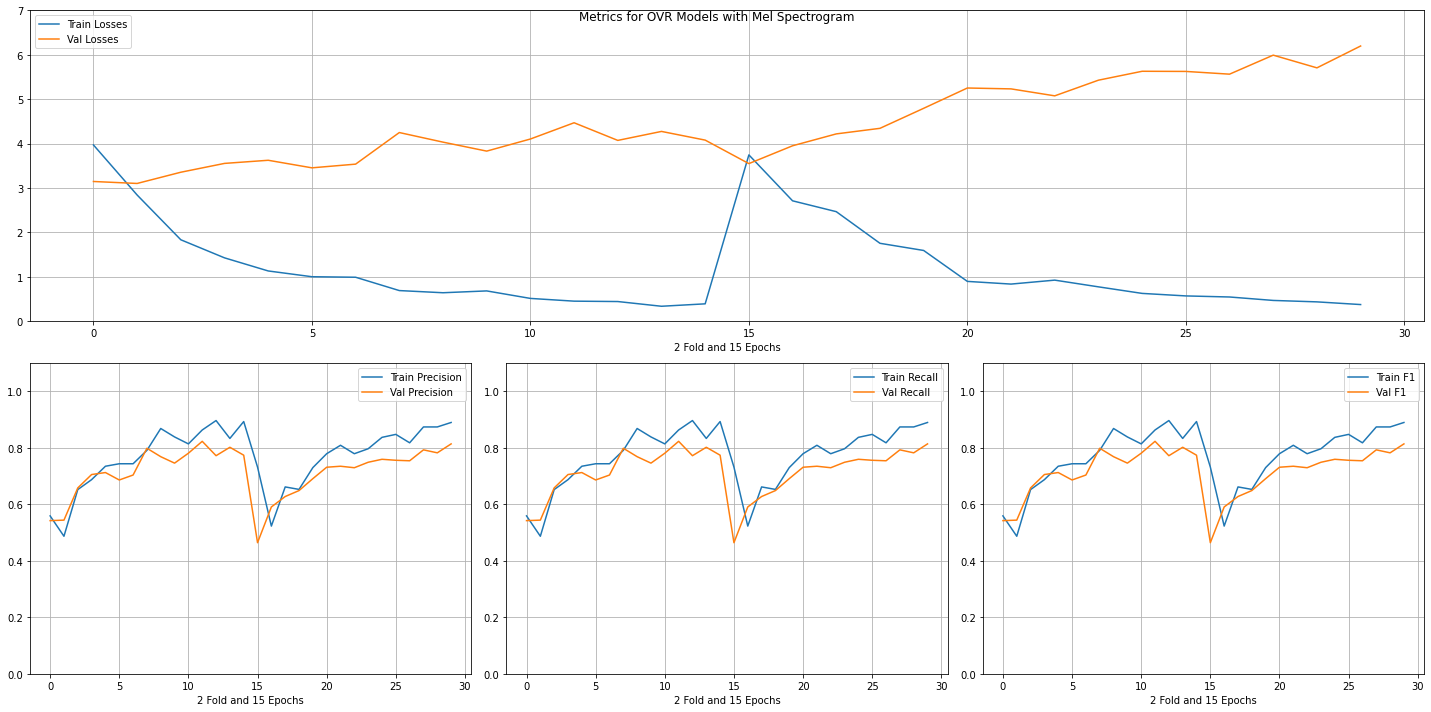

    train_f1  validation_f1  ...  train_losses  validation_losses
11  0.862917       0.822807  ...      0.451453           4.469342
14  0.889474       0.813708  ...      0.374820           6.198178
13  0.833040       0.801754  ...      0.336498           4.274212
7   0.790861       0.798246  ...      0.689856           4.249039
12  0.873684       0.792619  ...      0.467749           5.992090
13  0.873684       0.782074  ...      0.435380           5.706057
10  0.813708       0.780702  ...      0.513197           4.103368
14  0.892794       0.773684  ...      0.391038           4.078613
12  0.896309       0.771930  ...      0.442848           4.072028
8   0.868190       0.768421  ...      0.640935           4.032945
9   0.836842       0.759227  ...      0.626143           5.628979
10  0.847368       0.755712  ...      0.569431           5.625546
11  0.817544       0.753954  ...      0.545233           5.563880
8   0.796491       0.748682  ...      0.773651           5.428303
9   0.8383

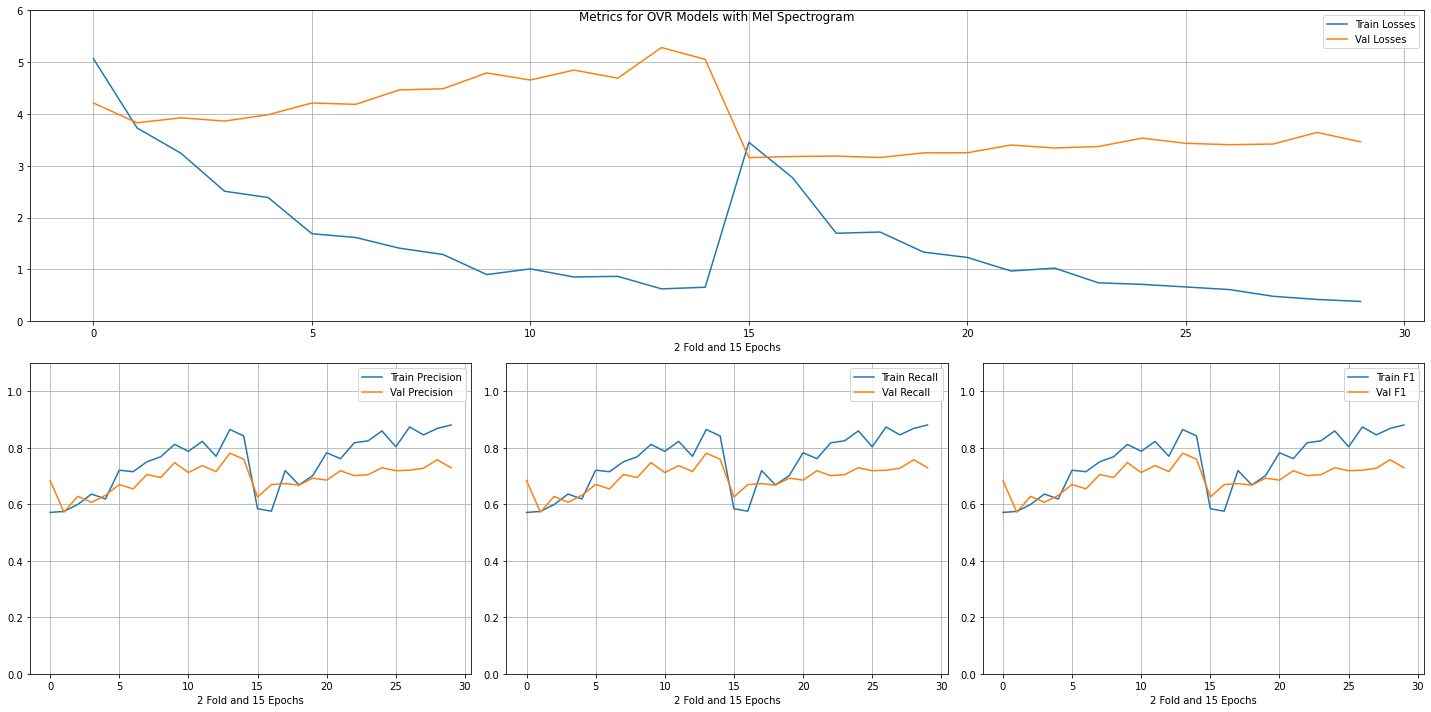

    train_f1  validation_f1  ...  train_losses  validation_losses
13  0.864675       0.780702  ...      0.624351           5.282729
14  0.841828       0.759649  ...      0.655220           5.054786
13  0.868421       0.757469  ...      0.419979           3.644475
9   0.811951       0.747368  ...      0.900316           4.792453
11  0.822496       0.736842  ...      0.852817           4.848312
9   0.859649       0.729350  ...      0.710948           3.534077
14  0.880702       0.729350  ...      0.381633           3.462689
12  0.845614       0.727592  ...      0.480370           3.420134
11  0.873684       0.720562  ...      0.610142           3.407542
10  0.803509       0.718805  ...      0.661068           3.434016
6   0.761404       0.718805  ...      0.968697           3.401445
12  0.769772       0.715789  ...      0.866035           4.691276
10  0.787346       0.712281  ...      1.009202           4.655916
7   0.750439       0.705263  ...      1.410008           4.464810
8   0.8245

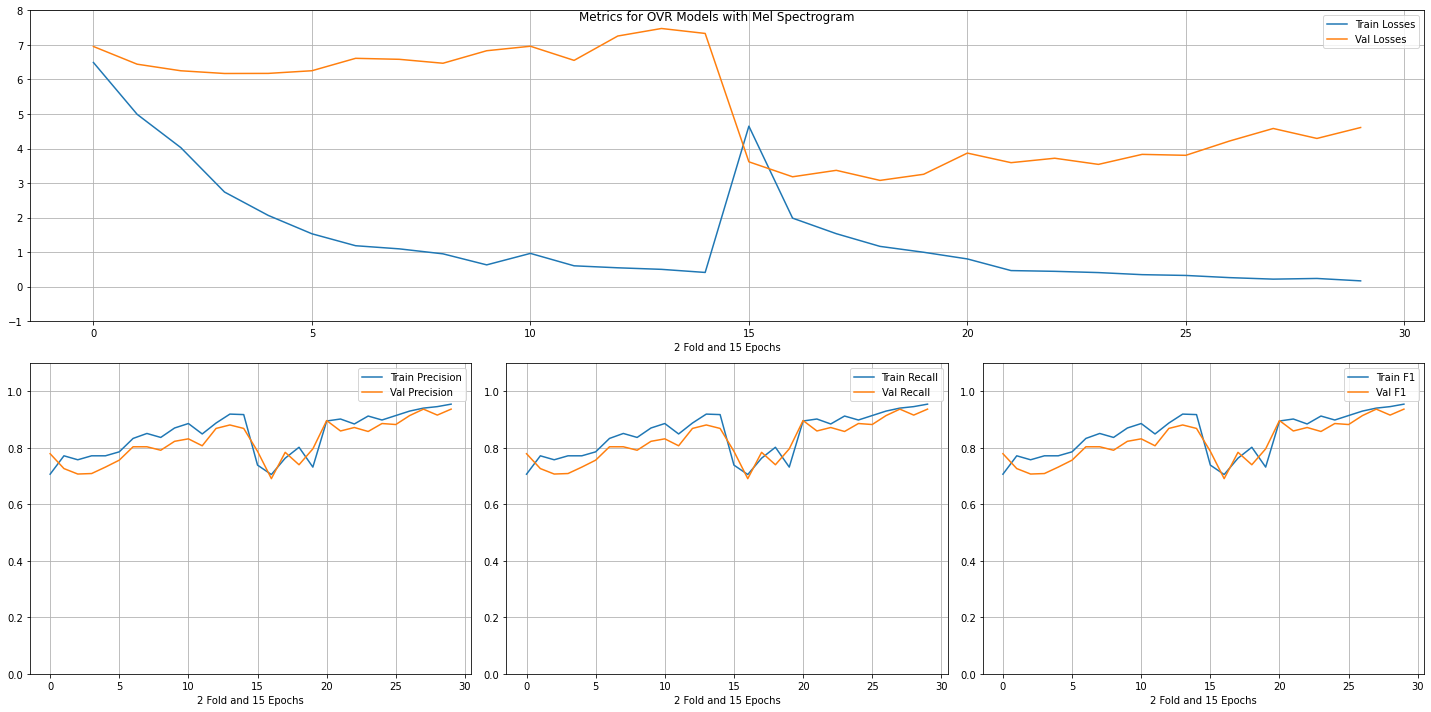

    train_f1  validation_f1  ...  train_losses  validation_losses
14  0.954386       0.936731  ...      0.167930           4.608754
12  0.940351       0.936731  ...      0.218019           4.580689
13  0.945614       0.915641  ...      0.237715           4.292180
11  0.929825       0.913884  ...      0.261803           4.217461
5   0.894737       0.896309  ...      0.803095           3.868187
9   0.898246       0.885764  ...      0.347507           3.830993
10  0.914035       0.882250  ...      0.324809           3.803820
13  0.919156       0.880702  ...      0.501468           7.476157
7   0.884211       0.871705  ...      0.444070           3.719052
14  0.917399       0.868421  ...      0.411759           7.332906
12  0.887522       0.868421  ...      0.546390           7.258280
6   0.901754       0.859402  ...      0.465873           3.590770
8   0.912281       0.857645  ...      0.407866           3.540892
10  0.885764       0.831579  ...      0.963526           6.962063
9   0.8699

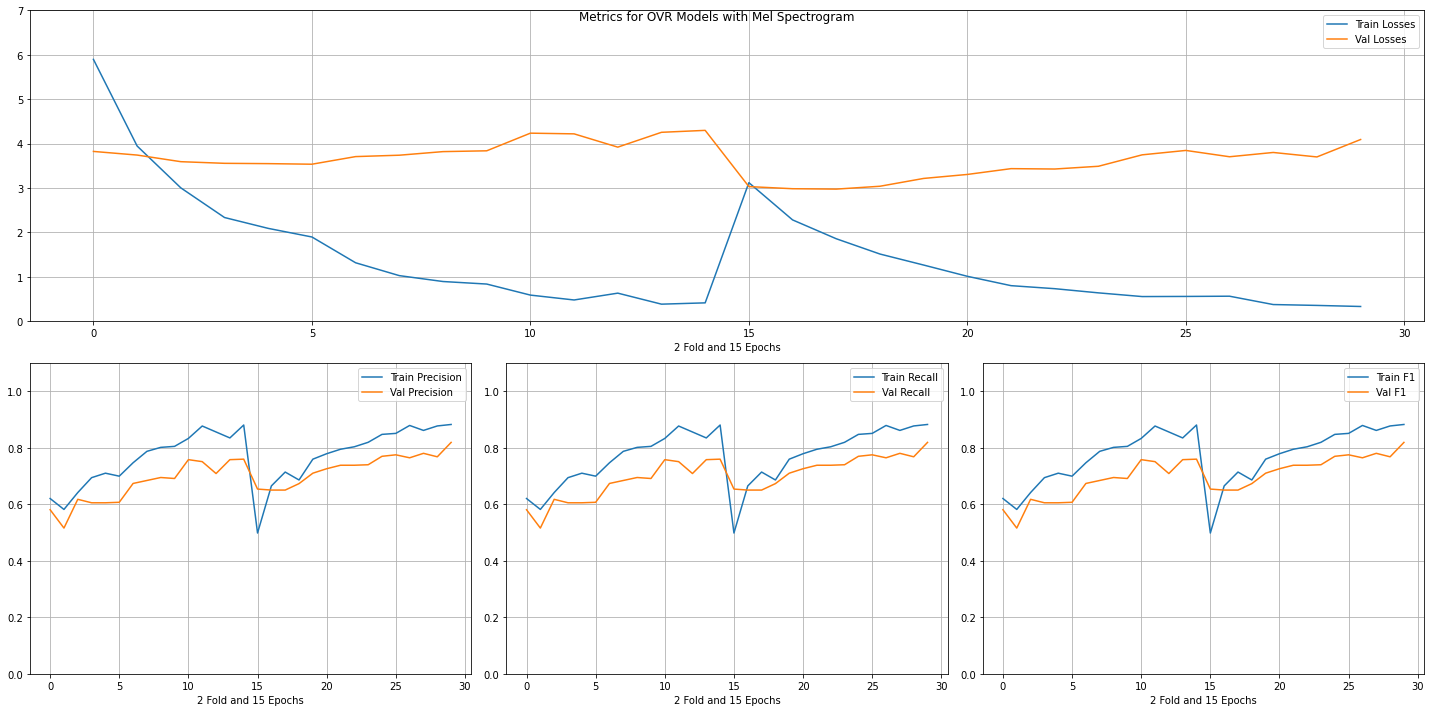

    train_f1  validation_f1  ...  train_losses  validation_losses
14  0.882456       0.818981  ...      0.331441           4.092173
12  0.861404       0.780316  ...      0.375039           3.800266
10  0.850877       0.775044  ...      0.557844           3.845987
9   0.847368       0.769772  ...      0.554864           3.746857
13  0.877193       0.768014  ...      0.355504           3.699576
11  0.878947       0.764499  ...      0.562978           3.703745
14  0.880492       0.759649  ...      0.413103           4.298027
13  0.834798       0.757895  ...      0.383838           4.254420
10  0.833040       0.757895  ...      0.587825           4.235057
11  0.876977       0.750877  ...      0.477986           4.219420
8   0.819298       0.739895  ...      0.638223           3.489360
6   0.794737       0.738137  ...      0.800453           3.435988
7   0.803509       0.738137  ...      0.732340           3.427596
5   0.778947       0.725835  ...      1.011196           3.305329
4   0.7596

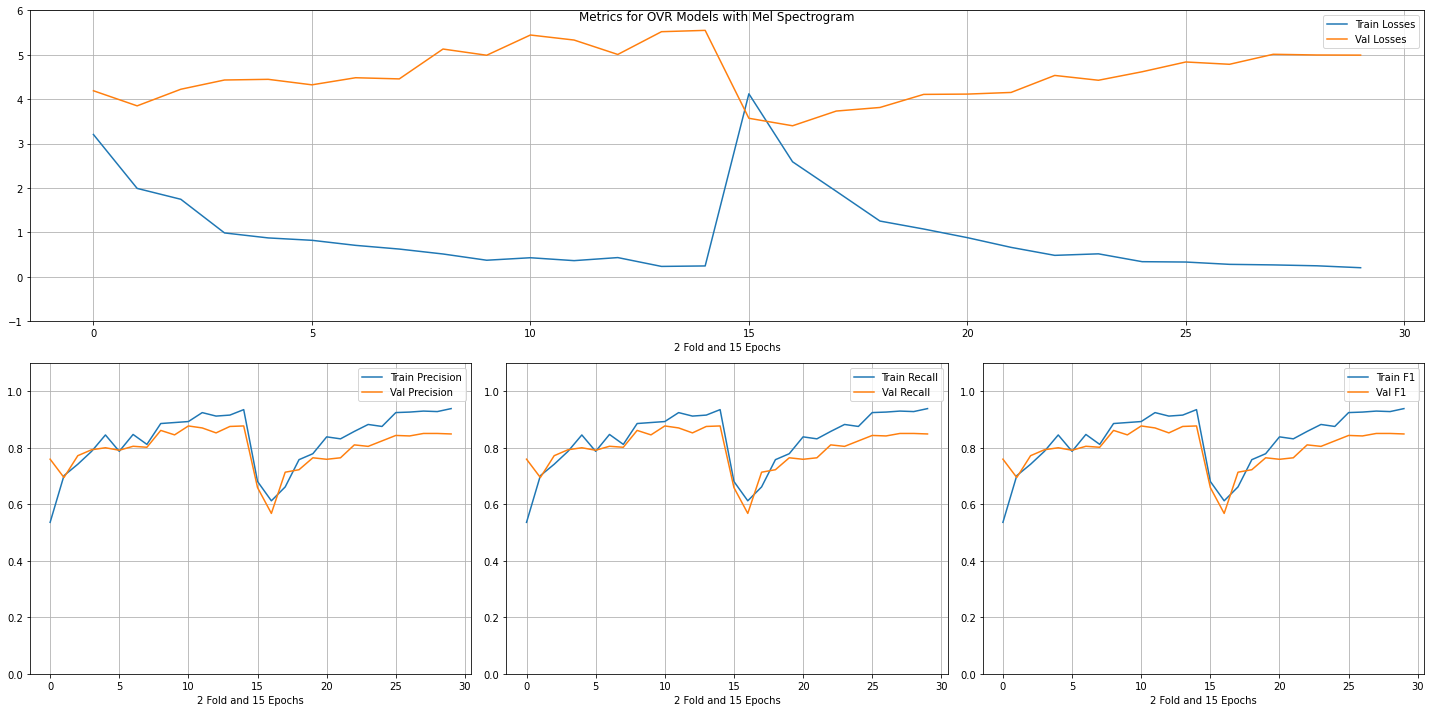

    train_f1  validation_f1  ...  train_losses  validation_losses
14  0.934974       0.877193  ...      0.244410           5.550162
10  0.892794       0.877193  ...      0.429382           5.445628
13  0.915641       0.875439  ...      0.233948           5.520467
11  0.924429       0.870175  ...      0.364038           5.332369
8   0.885764       0.861404  ...      0.513696           5.129808
12  0.912127       0.852632  ...      0.432820           5.007534
12  0.929825       0.850615  ...      0.267840           5.011483
13  0.928070       0.850615  ...      0.247749           4.995800
14  0.938596       0.848858  ...      0.204418           4.992672
9   0.889279       0.845614  ...      0.373127           4.989878
10  0.924561       0.843585  ...      0.332529           4.838278
11  0.926316       0.841828  ...      0.280363           4.786227
9   0.875439       0.824253  ...      0.340554           4.618065
7   0.857895       0.810193  ...      0.482903           4.535023
6   0.8471

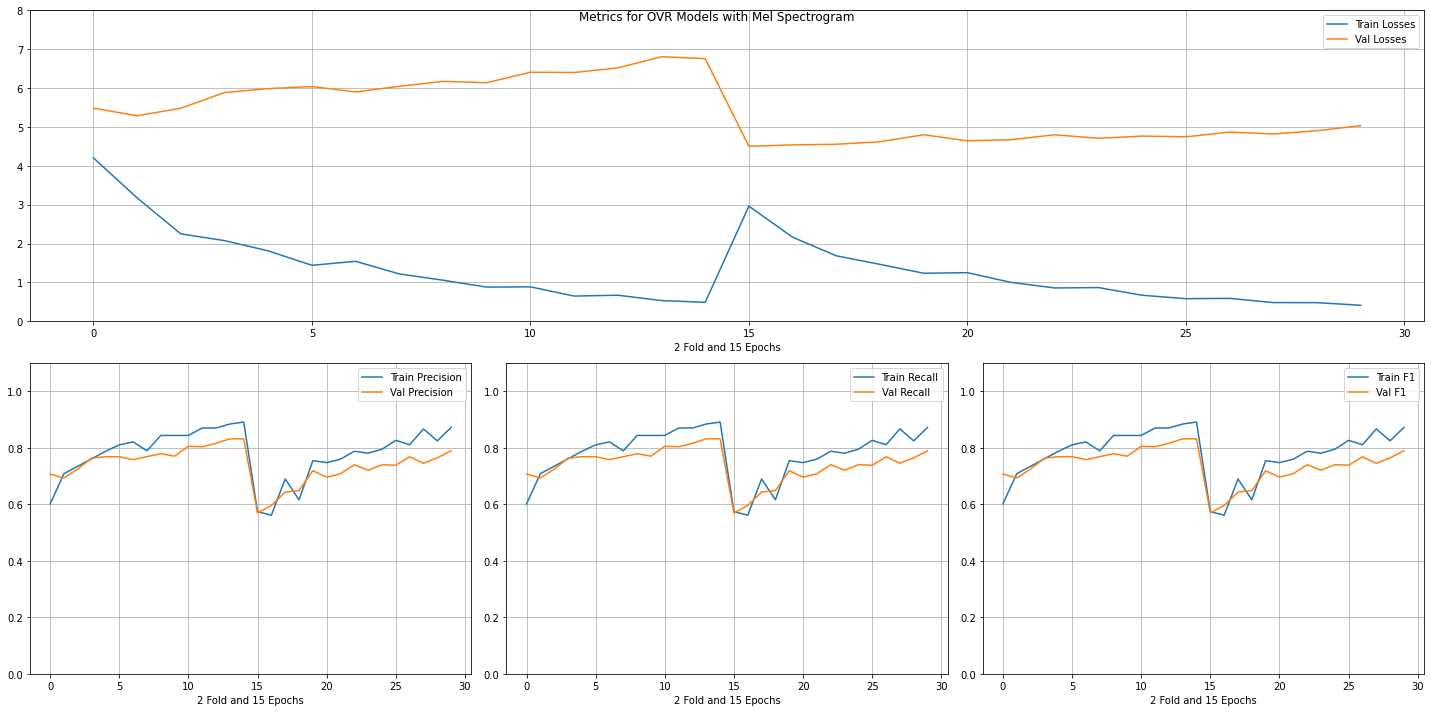

    train_f1  validation_f1  ...  train_losses  validation_losses
14  0.891037       0.831579  ...      0.486212           6.758525
13  0.884007       0.831579  ...      0.531498           6.807332
12  0.869947       0.815789  ...      0.669101           6.520329
10  0.843585       0.805263  ...      0.884166           6.408042
11  0.869947       0.803509  ...      0.646801           6.401339
14  0.871930       0.789104  ...      0.410664           5.033801
8   0.843585       0.778947  ...      1.055214           6.172881
9   0.843585       0.770175  ...      0.877559           6.139080
5   0.810193       0.768421  ...      1.438523           6.039924
4   0.787346       0.768421  ...      1.810740           5.985662
7   0.789104       0.768421  ...      1.216909           6.046463
11  0.810526       0.768014  ...      0.587425           4.867309
13  0.824561       0.764499  ...      0.477087           4.902369
3   0.760984       0.763158  ...      2.073999           5.886609
6   0.8207

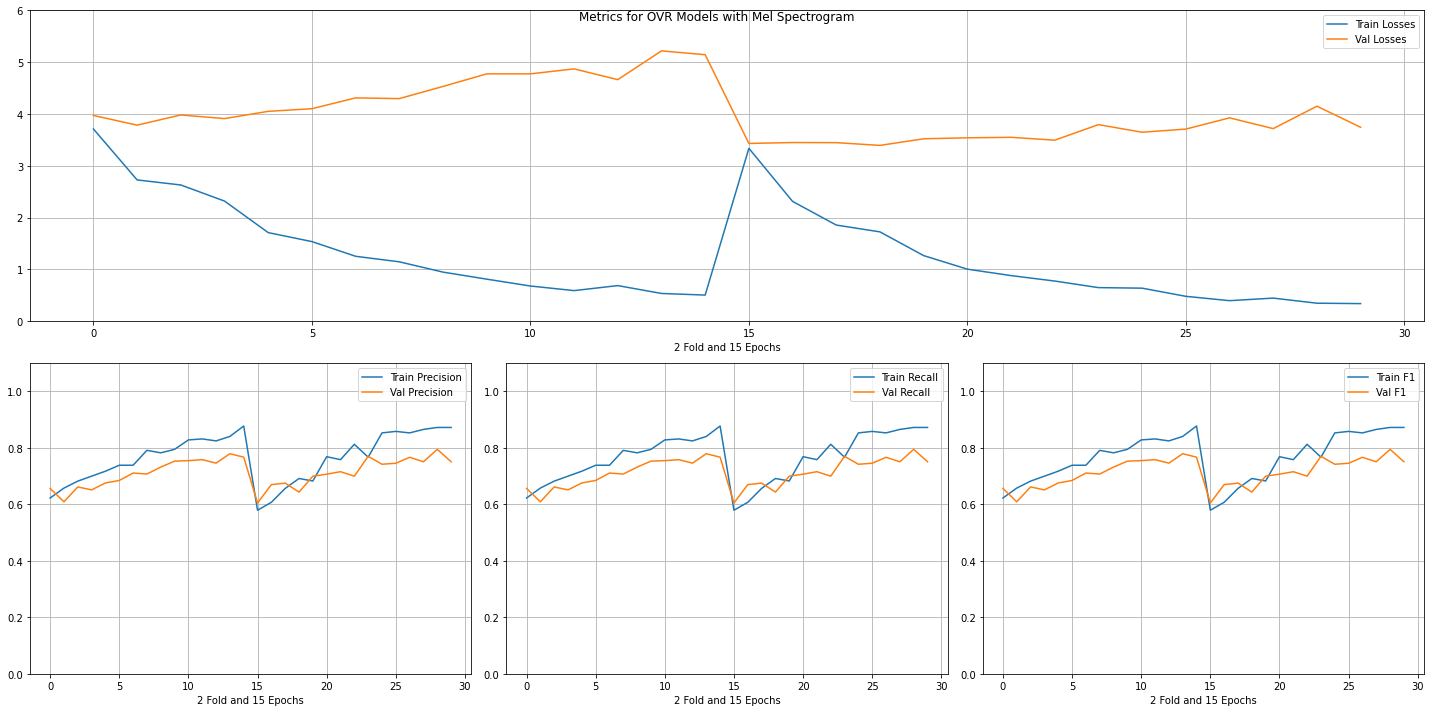

    train_f1  validation_f1  ...  train_losses  validation_losses
13  0.871930       0.794376  ...      0.347480           4.150721
13  0.840070       0.778947  ...      0.535375           5.218492
8   0.766667       0.769772  ...      0.648436           3.794569
14  0.876977       0.766667  ...      0.504483           5.144825
11  0.852632       0.766257  ...      0.396364           3.925708
11  0.831283       0.757895  ...      0.590430           4.871083
10  0.827768       0.754386  ...      0.679507           4.774976
9   0.794376       0.752632  ...      0.811839           4.775003
14  0.871930       0.750439  ...      0.339602           3.743669
12  0.864912       0.750439  ...      0.445811           3.717878
12  0.824253       0.745614  ...      0.687206           4.663077
10  0.857895       0.745167  ...      0.480270           3.708642
9   0.852632       0.741652  ...      0.637619           3.648054
8   0.782074       0.731579  ...      0.947590           4.531793
6   0.7578

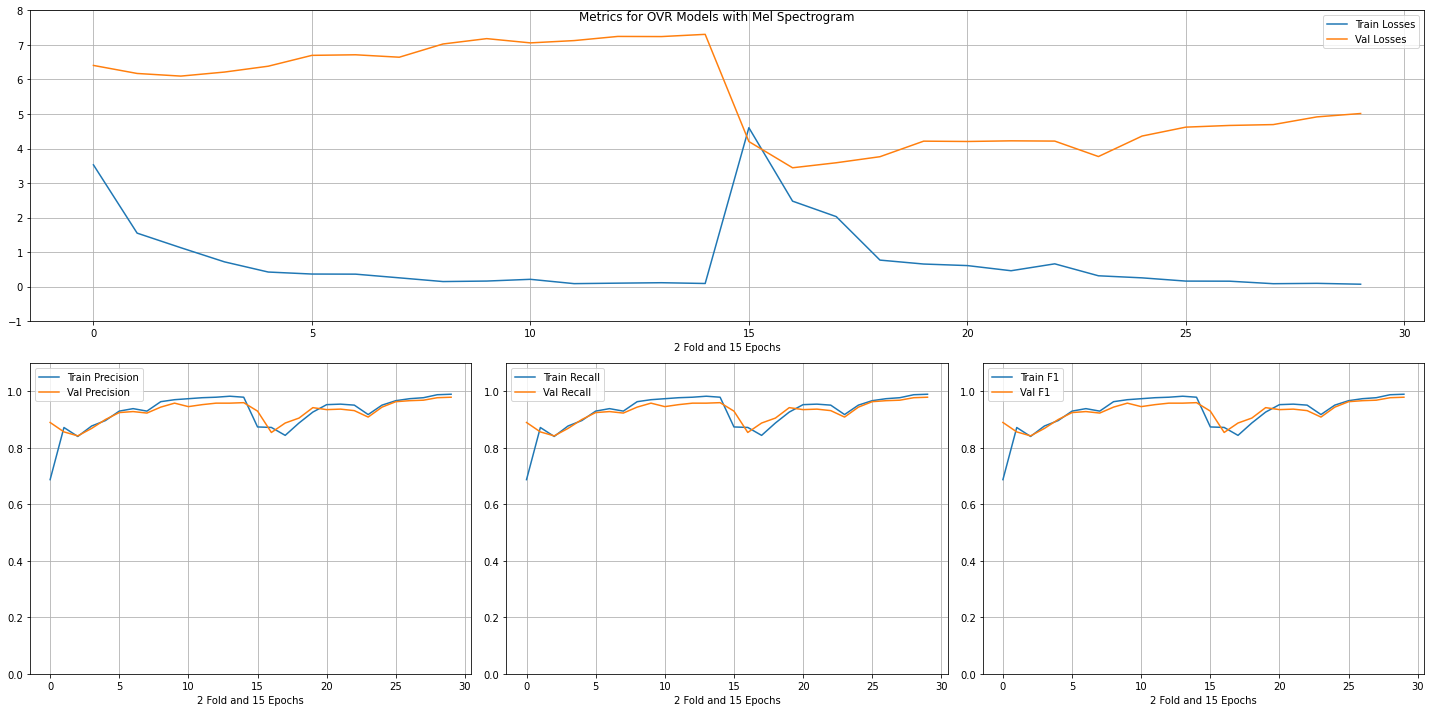

    train_f1  validation_f1  ...  train_losses  validation_losses
14  0.989474       0.978910  ...      0.070929           5.014498
13  0.987719       0.977153  ...      0.096114           4.916362
12  0.977193       0.968366  ...      0.086017           4.693440
11  0.973684       0.966608  ...      0.158525           4.668552
10  0.966667       0.963093  ...      0.161400           4.619521
14  0.978910       0.959649  ...      0.092035           7.306495
13  0.982425       0.957895  ...      0.114460           7.242223
12  0.978910       0.957895  ...      0.101726           7.246258
9   0.970123       0.957895  ...      0.162361           7.182552
11  0.977153       0.952632  ...      0.087678           7.125740
10  0.973638       0.945614  ...      0.212719           7.059461
8   0.963093       0.943860  ...      0.147896           7.027321
9   0.950877       0.943761  ...      0.254984           4.362248
4   0.926316       0.942004  ...      0.655416           4.213602
6   0.9543

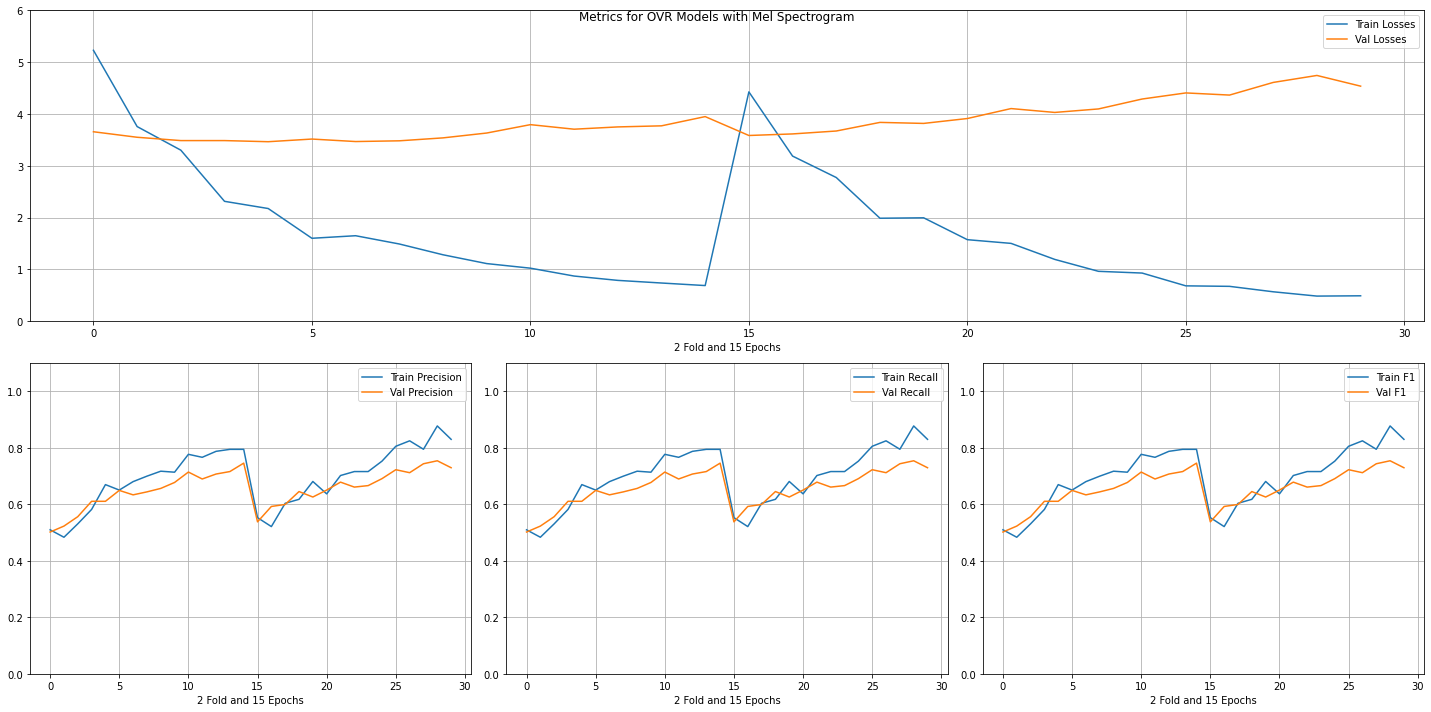

    train_f1  validation_f1  ...  train_losses  validation_losses
13  0.877193       0.753954  ...      0.484753           4.744196
14  0.794376       0.745614  ...      0.687923           3.949730
12  0.794737       0.743409  ...      0.567851           4.609488
14  0.829825       0.729350  ...      0.490389           4.537530
10  0.805263       0.722320  ...      0.682443           4.406826
13  0.794376       0.715789  ...      0.737161           3.771516
10  0.776801       0.714035  ...      1.023651           3.794417
11  0.824561       0.711775  ...      0.672827           4.365339
12  0.787346       0.707018  ...      0.788019           3.750591
9   0.752632       0.690685  ...      0.929383           4.289148
11  0.766257       0.689474  ...      0.871683           3.706629
6   0.701754       0.678383  ...      1.502247           4.104860
9   0.713533       0.677193  ...      1.112298           3.632583
8   0.715789       0.666081  ...      0.962917           4.097698
7   0.7157

In [35]:
le = LabelEncoder()
le.fit(data['Ragam'])
labels = le.transform(le.classes_)
ovr_res = ovr_train_model(data, MelMatrixDataset, MelRaga, "OVR Models with Mel Spectrogram", 
                          labels, le.classes_, lbl_encoder=le, lr=1e-6, epochs=15, n_folds=2, feature='mel_spec')

In [36]:
for k in ovr_res:
  print(le.inverse_transform([k]))
  print(results_to_df(ovr_res[k]).head())

['ఆహిరి']
    train_f1  validation_f1  ...  train_losses  validation_losses
12  0.924561       0.910369  ...      0.232412           5.264531
14  0.935088       0.905097  ...      0.204759           5.177031
13  0.947368       0.905097  ...      0.275600           5.176164
8   0.891228       0.869947  ...      0.499497           4.573637
14  0.922671       0.866667  ...      0.433305           7.133884

[5 rows x 8 columns]
['కన్నడగౌళ']
    train_f1  validation_f1  ...  train_losses  validation_losses
14  0.978910       0.957895  ...      0.093701           3.181474
13  0.964851       0.957895  ...      0.117804           3.168217
12  0.973638       0.954386  ...      0.080560           3.125750
14  0.982456       0.947276  ...      0.088246           6.101958
13  0.956140       0.943761  ...      0.127998           5.970183

[5 rows x 8 columns]
['కాంబోది']
    train_f1  validation_f1  ...  train_losses  validation_losses
11  0.966667       0.950791  ...      0.125544           4.9808

# Mapping each Raga with Janaka Ragam

In [37]:
janaka_raga_map ={'లలిత':'Mayamalavagowla',
'సాళంగనాట':'Mayamalavagowla',
'సామంతం':'Naganandini',
'బౌళి':'Mayamalavagowla',
'శంకరాభరణం':'Shankarabharanam',
'శ్రీరాగం':'Kharaharapriya',
'రామక్రియ':'Mayamalavagowla',
'ముఖారి':'Kharaharapriya',
'పాడి':'Mayamalavagowla',
'ఆహిరి':'Vakulabharanam',
'దేసాళం':'Unknown',
'దేవగాంధారి':'Shankarabharanam',
'శుద్ధవసంతం':'Shankarabharanam',
'భూపాలం':'Shubhapantuvarali',
'దేసాక్షి':'Harikambhoji',
'గుండుక్రియ':'Mayamalavagowla',
'భైరవి':'Natabhairavi',
'నాట':'Chalanata',
'వరాళి':'Jhalavarali',
'ధన్నాసి':'Hanumatodi',
'మలహరి':'Mayamalavagowla',
'కాంబోది':'Harikambhoji',
'మాళవిగౌళ':'Mayamalavagowla',
'మాళవి':'Harikambhoji',
'గుజ్జరి':'Unknown',
'కన్నడగౌళ':'Kharaharapriya',
'గౌళ':'Mayamalavagowla',
'బౌళిరామక్రియ':'Mayamalavagowla',
'నాదరామక్రియ':'Unknown',
'సాళంగం':'Kalyani'}

In [38]:
data['janaka_ragam'] = data.apply(lambda x:janaka_raga_map[x['Ragam']],axis=1)

In [39]:
jle = LabelEncoder()
jle.fit(data['janaka_ragam'])
data['JanakaRagamCode'] = data.apply(lambda x:jle.transform([x.janaka_ragam])[0],axis=1)
n_labels = len(data['RagamCode'].unique())

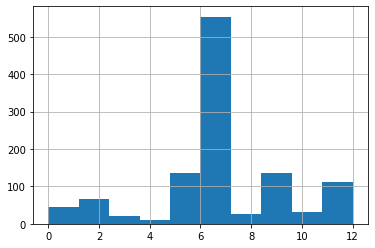

In [40]:
data['JanakaRagamCode'].hist()

In [44]:
class MelsJanakaRagaDataset(AbsDataset):
    def __init__(self, labels, mels):
        super().__init__()
        self.labels = labels
        self.mels = mels

    def __get__(self,index):
      if self.mels[index].shape[1] < 9601:
        self.mels[index] = torch.hstack((self.mels[index],torch.zeros(40,9601-self.mels[index].shape[1])))
      return self.mels[index].reshape((1,)+self.mels[index].shape)

    def __len__(self):
        return len(self.labels)

    def __iter__(self):
        for index, _ in enumerate(self.labels):
            yield self.__get__(index), self.labels[index]

    def __getitem__(self, index):
        return self.__get__(index), self.labels[index]

    @staticmethod
    def prepare_data(data, train_ids, test_ids):
      train_lbls = torch.tensor([data['JanakaRagamCode'].iloc[x] for x in train_ids])
      test_lbls = torch.tensor([data['JanakaRagamCode'].iloc[x] for x in test_ids])
      train_vals = [data['mel_spec'].iloc[x] for x in train_ids]
      test_vals = [data['mel_spec'].iloc[x] for x in test_ids]
      train_data = MelsJanakaRagaDataset(train_lbls, train_vals)
      test_data = MelsJanakaRagaDataset(test_lbls, test_vals)
      return train_data, test_data, train_lbls, test_lbls

Training for ['Chalanata'] with 25 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 569/570
Class Weights : [ 0.51122083 22.78      ]
Epoch 1/15 : Training Loss: 13.061 / Validation Loss : 7.919 [Time Taken : 2.753832 seconds]
Epoch 2/15 : Training Loss: 7.028 / Validation Loss : 15.895 [Time Taken : 2.73931 seconds]
Epoch 3/15 : Training Loss: 2.594 / Validation Loss : 8.904 [Time Taken : 2.714209 seconds]
Epoch 4/15 : Training Loss: 0.861 / Validation Loss : 7.199 [Time Taken : 2.720381 seconds]
Epoch 5/15 : Training Loss: 0.170 / Validation Loss : 9.940 [Time Taken : 2.705408 seconds]
Epoch 6/15 : Training Loss: 0.079 / Validation Loss : 9.021 [Time Taken : 2.71696 seconds]
Epoch 7/15 : Training Loss: 0.073 / Validation Loss : 9.747 [Time Taken : 2.721694 seconds]
Epoch 8/15 : Training Loss: 0.041 / Validation Loss : 9.477 [Time Taken : 2.709069 seconds]
Epoch 9/15 : Training Loss: 0.040 / Validation Loss : 9.650 [Time Taken : 2.850967 seconds]
Epoch 10/15 : Training Loss: 0.038 

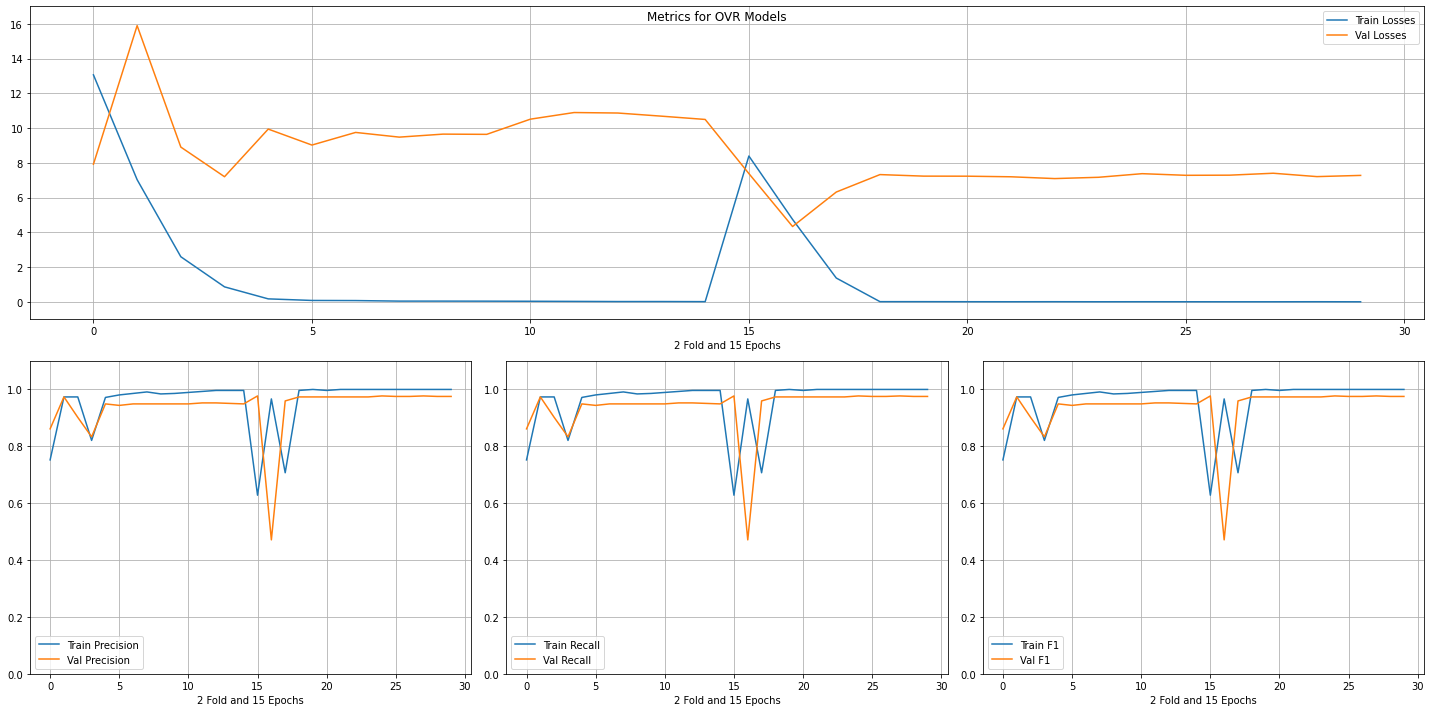

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.628070       0.977153  ...      8.389852           7.380814
9   1.000000       0.977153  ...      0.005404           7.374311
12  1.000000       0.977153  ...      0.002763           7.399306
13  1.000000       0.975395  ...      0.005724           7.205281
11  1.000000       0.975395  ...      0.002568           7.287995
10  1.000000       0.975395  ...      0.004216           7.280282
14  1.000000       0.975395  ...      0.001983           7.274740
1   0.973638       0.973684  ...      7.027902          15.894560
3   0.996491       0.973638  ...      0.009977           7.321871
5   0.996491       0.973638  ...      0.006067           7.229486
8   1.000000       0.973638  ...      0.003712           7.166153
7   1.000000       0.973638  ...      0.006826           7.091752
6   1.000000       0.973638  ...      0.004436           7.195287
4   1.000000       0.973638  ...      0.009394           7.232874
2   0.7070

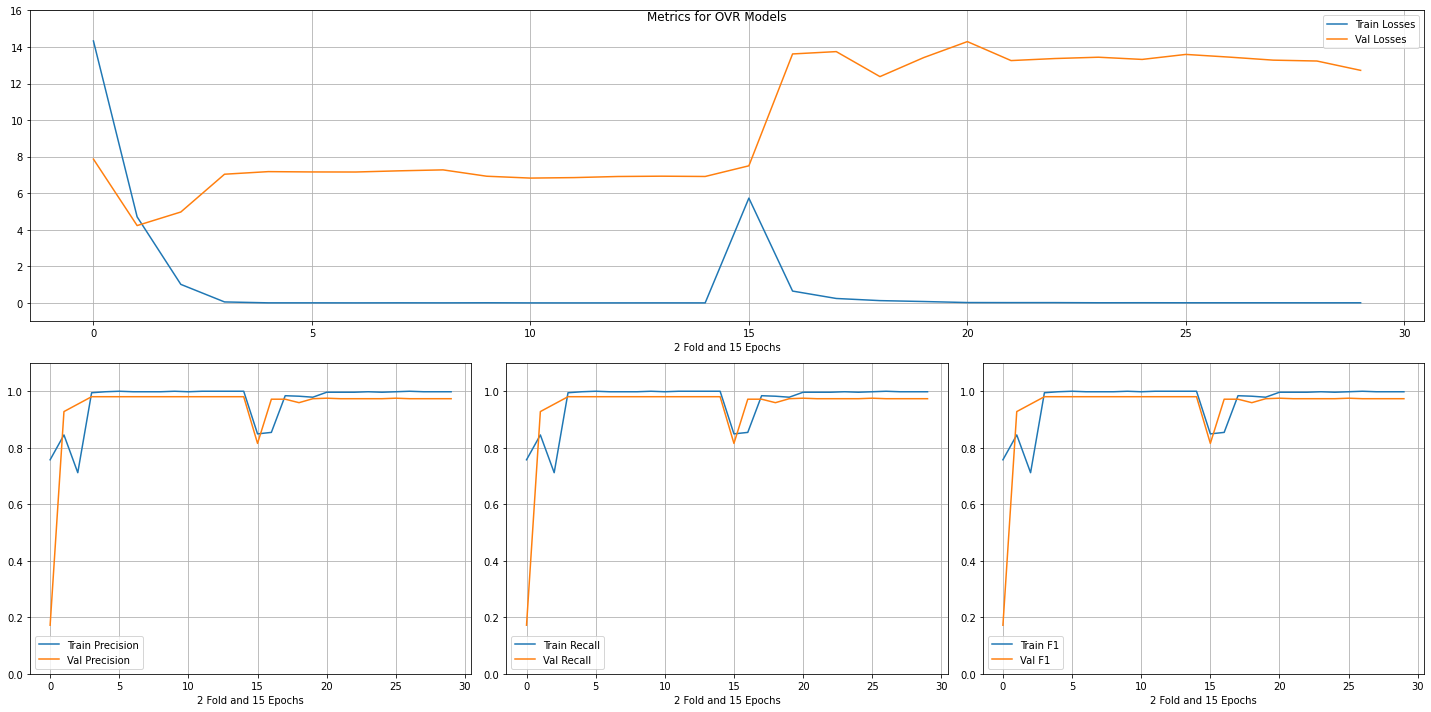

    train_f1  validation_f1  ...  train_losses  validation_losses
14  1.000000       0.980702  ...      0.001719           6.916250
7   0.998243       0.980702  ...      0.005565           7.225363
13  1.000000       0.980702  ...      0.003210           6.931777
12  1.000000       0.980702  ...      0.002026           6.915129
11  1.000000       0.980702  ...      0.001108           6.854725
10  0.998243       0.980702  ...      0.002007           6.827870
8   0.998243       0.980702  ...      0.003460           7.277202
9   1.000000       0.980702  ...      0.008012           6.929596
6   0.998243       0.980702  ...      0.002430           7.160139
5   1.000000       0.980702  ...      0.004704           7.163927
4   0.998243       0.980702  ...      0.004511           7.181323
3   0.994728       0.980702  ...      0.054077           7.039459
5   0.996491       0.975395  ...      0.020347          14.293129
10  0.998246       0.975395  ...      0.008193          13.592250
11  1.0000

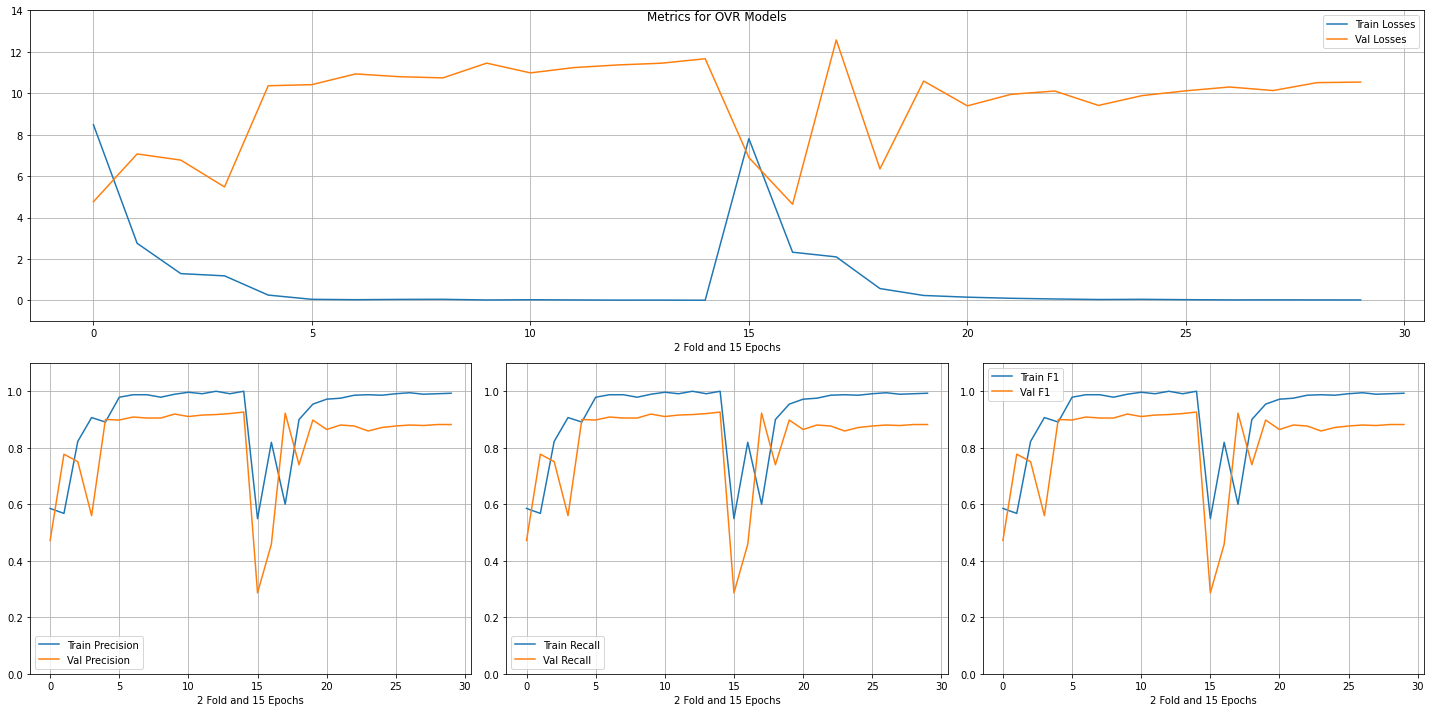

    train_f1  validation_f1  ...  train_losses  validation_losses
14  1.000000       0.926316  ...      0.012386          11.666210
2   0.600000       0.922671  ...      2.103595          12.576169
13  0.991213       0.921053  ...      0.018497          11.451780
9   0.989455       0.919298  ...      0.024369          11.455318
12  1.000000       0.917544  ...      0.017450          11.366892
11  0.991213       0.915789  ...      0.025839          11.240934
10  0.996485       0.910526  ...      0.035615          10.984621
6   0.987698       0.908772  ...      0.037957          10.934685
7   0.987698       0.905263  ...      0.052362          10.800600
8   0.978910       0.905263  ...      0.056243          10.743472
4   0.891037       0.900000  ...      0.260077          10.363048
5   0.978910       0.898246  ...      0.055546          10.416644
4   0.954386       0.898067  ...      0.242000          10.590259
13  0.991228       0.882250  ...      0.027647          10.513836
14  0.9929

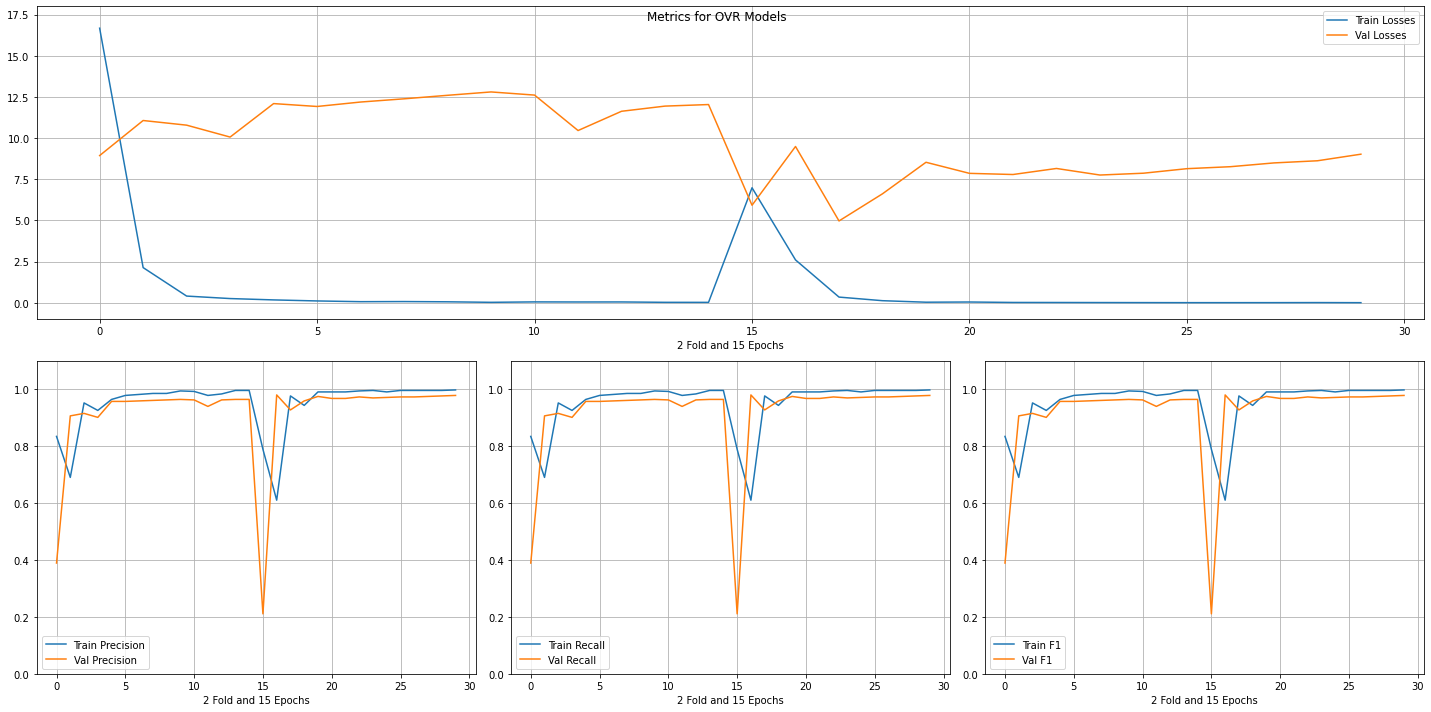

    train_f1  validation_f1  ...  train_losses  validation_losses
1   0.610526       0.980668  ...      2.601167           9.490758
14  0.998246       0.978910  ...      0.003958           9.023434
13  0.996491       0.977153  ...      0.009902           8.623039
4   0.991228       0.975395  ...      0.032209           8.531849
12  0.996491       0.975395  ...      0.006322           8.492846
11  0.996491       0.973638  ...      0.005538           8.263279
10  0.996491       0.973638  ...      0.005348           8.143497
7   0.994737       0.973638  ...      0.014851           8.155768
9   0.991228       0.971880  ...      0.008290           7.867948
8   0.996491       0.970123  ...      0.011047           7.756825
6   0.991228       0.968366  ...      0.017244           7.788836
5   0.991228       0.968366  ...      0.044220           7.858835
14  0.996485       0.964912  ...      0.022609          12.038379
9   0.994728       0.964912  ...      0.025177          12.804007
13  0.9964

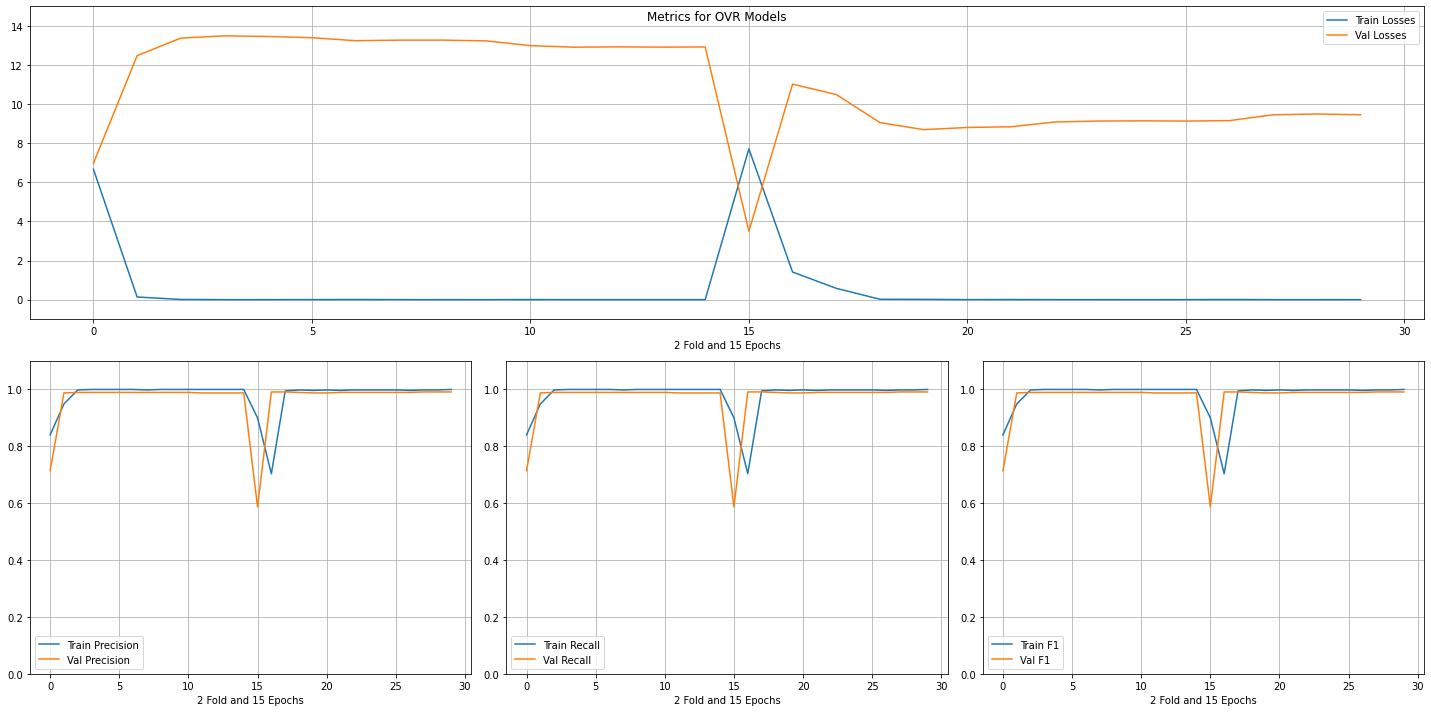

    train_f1  validation_f1  ...  train_losses  validation_losses
14  1.000000       0.991213  ...      0.001778           9.457941
13  0.998246       0.991213  ...      0.001432           9.495881
2   0.994737       0.991213  ...      0.579219          10.491199
1   0.703509       0.991213  ...      1.412727          11.022975
12  0.998246       0.991213  ...      0.001220           9.456861
5   1.000000       0.989474  ...      0.002538          13.398628
10  1.000000       0.989474  ...      0.004118          12.991687
2   0.998243       0.989474  ...      0.009924          13.379148
6   1.000000       0.989474  ...      0.004897          13.245810
4   1.000000       0.989474  ...      0.001585          13.461343
3   1.000000       0.989474  ...      0.001062          13.495043
9   1.000000       0.989474  ...      0.001160          13.234687
8   1.000000       0.989474  ...      0.000747          13.275697
7   0.998243       0.989474  ...      0.002132          13.275002
7   0.9982

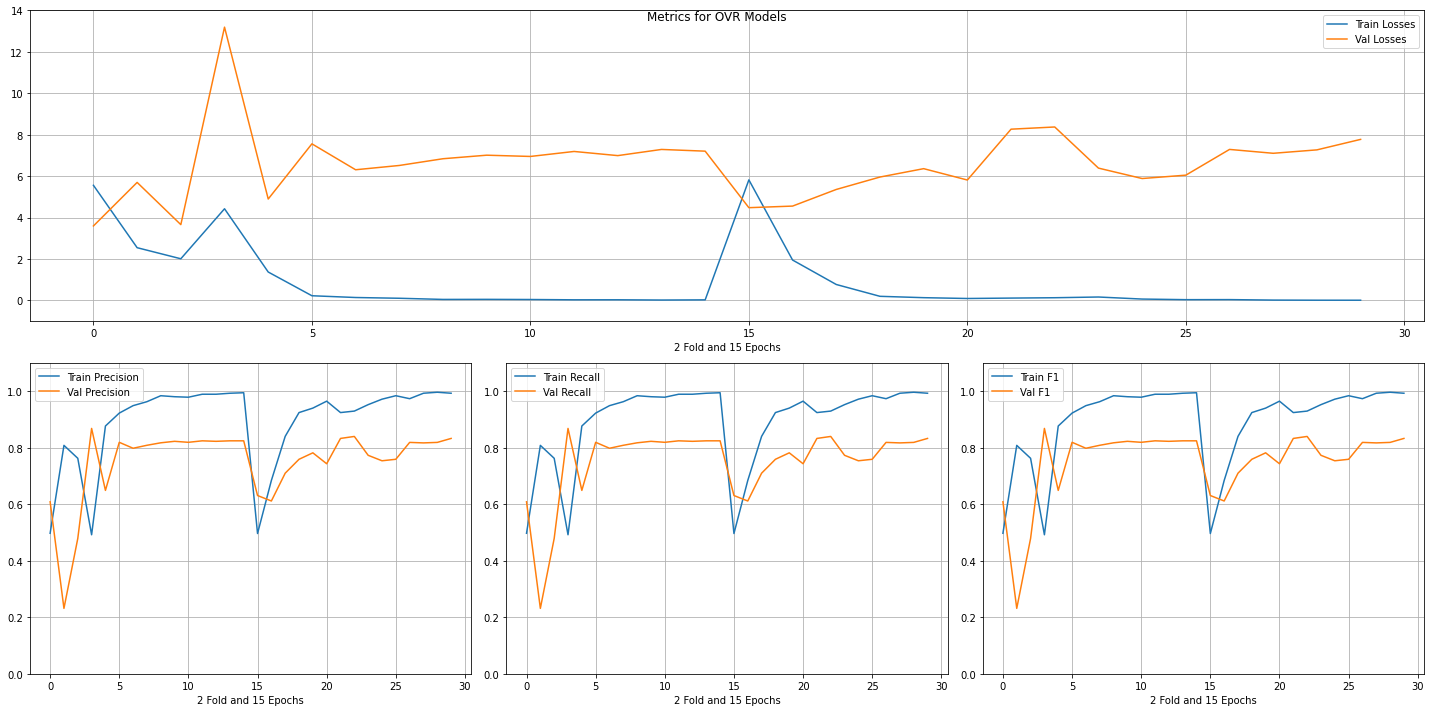

    train_f1  validation_f1  ...  train_losses  validation_losses
3   0.492091       0.868421  ...      4.425982          13.191585
7   0.929825       0.840070  ...      0.132823           8.373323
14  0.992982       0.833040  ...      0.012517           7.774967
6   0.924561       0.833040  ...      0.115516           8.267420
14  0.994728       0.824561  ...      0.029829           7.206524
13  0.992970       0.824561  ...      0.021415           7.289521
11  0.989455       0.824561  ...      0.032148           7.192042
9   0.980668       0.822807  ...      0.054020           7.011883
12  0.989455       0.822807  ...      0.033329           6.991743
10  0.978910       0.819298  ...      0.046659           6.951259
5   0.922671       0.819298  ...      0.228407           7.559927
11  0.973684       0.818981  ...      0.042068           7.290728
13  0.996491       0.818981  ...      0.013443           7.268962
8   0.984183       0.817544  ...      0.051095           6.841035
12  0.9929

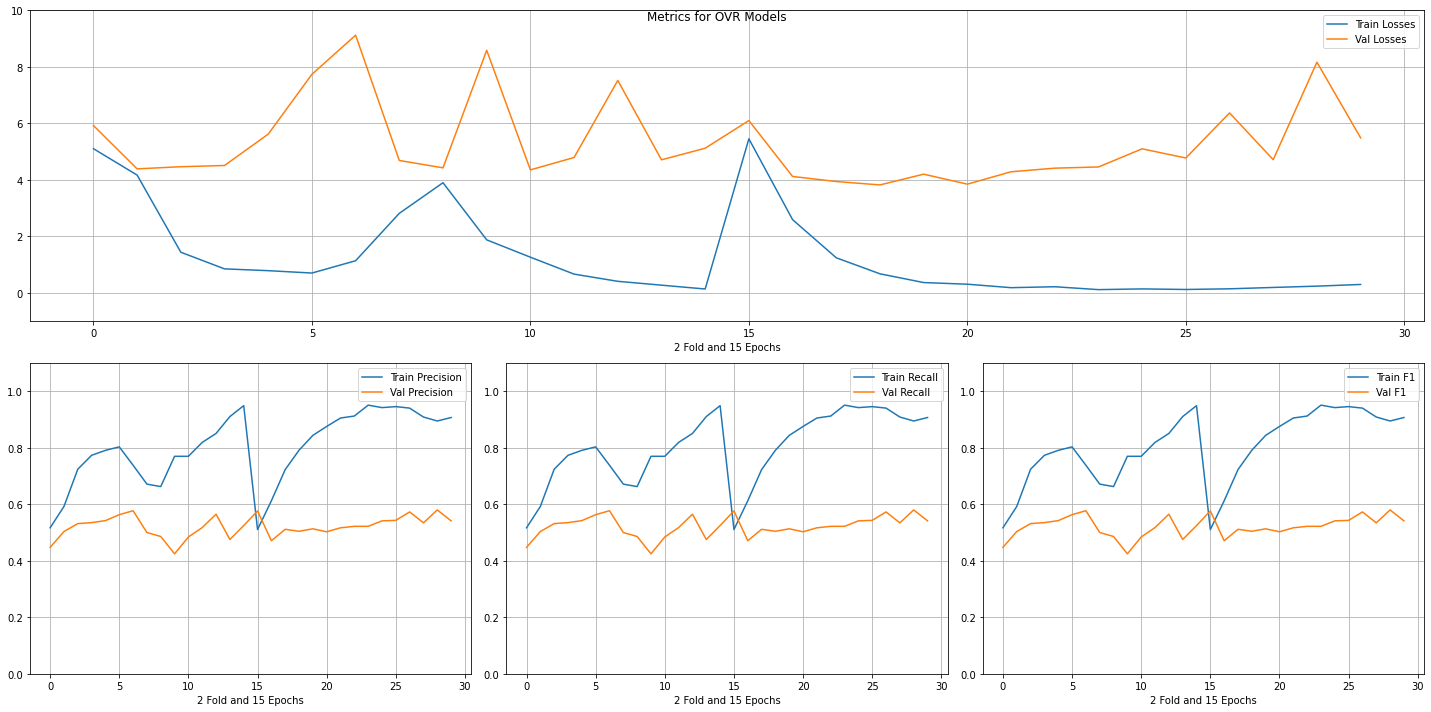

    train_f1  validation_f1  ...  train_losses  validation_losses
13  0.894737       0.579965  ...      0.240715           8.167224
6   0.738137       0.577193  ...      1.139493           9.123269
0   0.510526       0.576450  ...      5.454542           6.101830
11  0.940351       0.572935  ...      0.146357           6.371486
12  0.850615       0.564912  ...      0.411676           7.521187
5   0.803163       0.563158  ...      0.704283           7.737522
10  0.945614       0.543058  ...      0.122563           4.776379
4   0.790861       0.542105  ...      0.788532           5.620515
9   0.942105       0.541301  ...      0.142897           5.100384
14  0.907018       0.541301  ...      0.300300           5.488825
3   0.773286       0.535088  ...      0.852004           4.511318
12  0.908772       0.534271  ...      0.194590           4.716098
2   0.724077       0.531579  ...      1.440832           4.467560
14  0.949033       0.524561  ...      0.139900           5.122126
7   0.9122

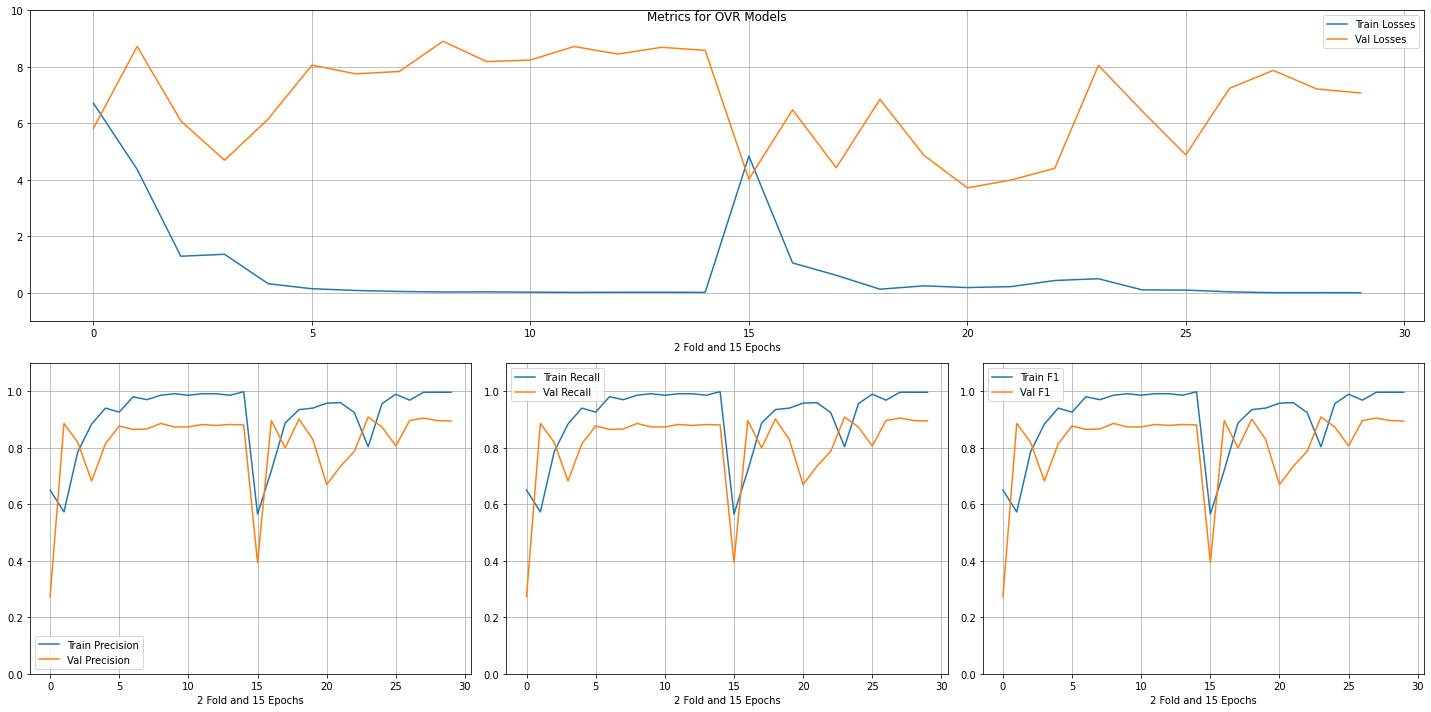

    train_f1  validation_f1  ...  train_losses  validation_losses
8   0.803509       0.908612  ...      0.502985           8.053470
12  0.996491       0.905097  ...      0.011099           7.877319
3   0.935088       0.901582  ...      0.131983           6.855446
13  0.996491       0.896309  ...      0.011646           7.217181
11  0.968421       0.896309  ...      0.039179           7.242147
1   0.719298       0.896309  ...      1.062267           6.480688
14  0.996491       0.894552  ...      0.008596           7.078081
8   0.985940       0.885965  ...      0.033717           8.908438
1   0.572935       0.885965  ...      4.373660           8.727936
11  0.991213       0.882456  ...      0.020272           8.722032
13  0.985940       0.882456  ...      0.024706           8.693010
14  0.998243       0.880702  ...      0.020467           8.587262
12  0.991213       0.878947  ...      0.024008           8.455630
5   0.926186       0.877193  ...      0.149173           8.061823
9   0.9912

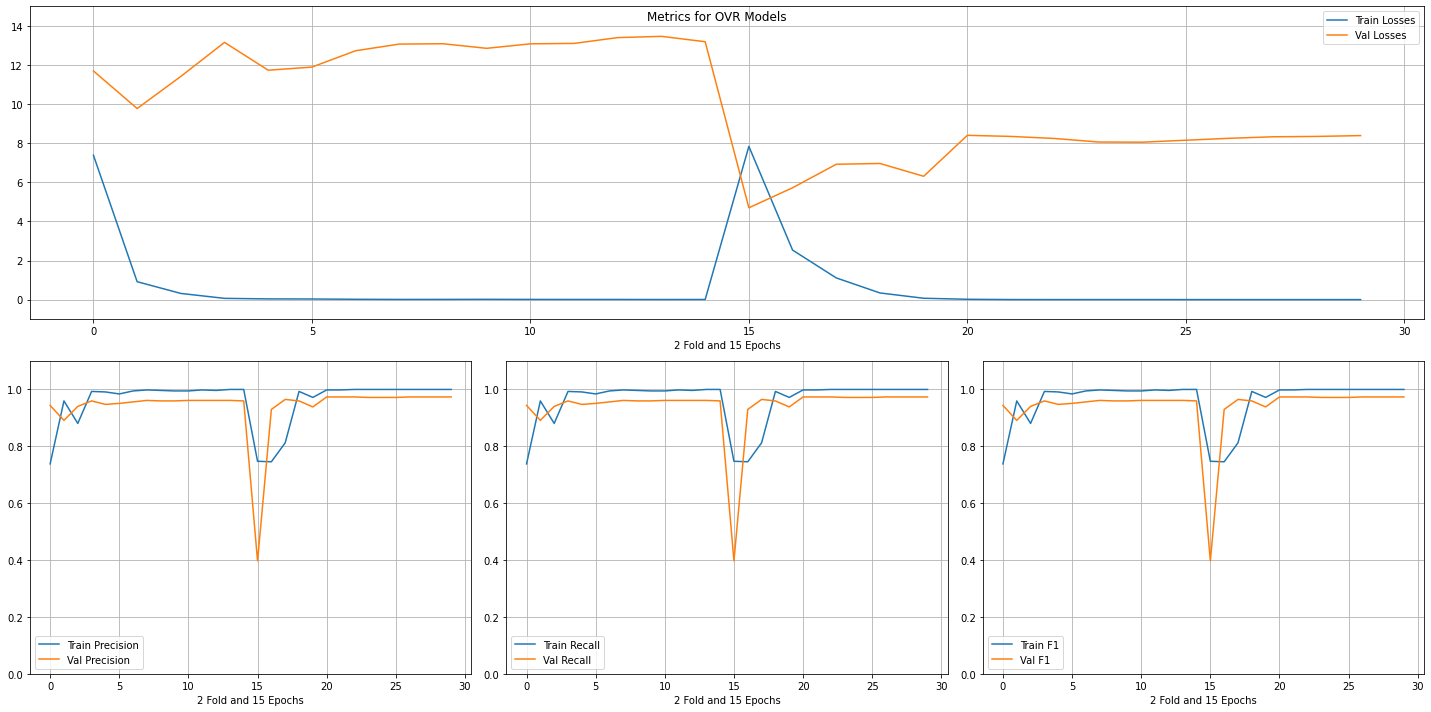

    train_f1  validation_f1  ...  train_losses  validation_losses
14  1.000000       0.973638  ...      0.002478           8.391949
13  1.000000       0.973638  ...      0.001926           8.348971
7   1.000000       0.973638  ...      0.002737           8.243456
6   0.998246       0.973638  ...      0.004667           8.349131
5   0.998246       0.973638  ...      0.018913           8.405248
11  1.000000       0.973638  ...      0.002277           8.252977
12  1.000000       0.973638  ...      0.002377           8.331171
9   1.000000       0.971880  ...      0.003547           8.054361
10  1.000000       0.971880  ...      0.002520           8.155125
8   1.000000       0.971880  ...      0.003565           8.063560
2   0.812281       0.964851  ...      1.111430           6.925329
10  0.994728       0.961404  ...      0.011963          13.085889
11  0.998243       0.961404  ...      0.009632          13.106513
13  1.000000       0.961404  ...      0.006744          13.467584
7   0.9982

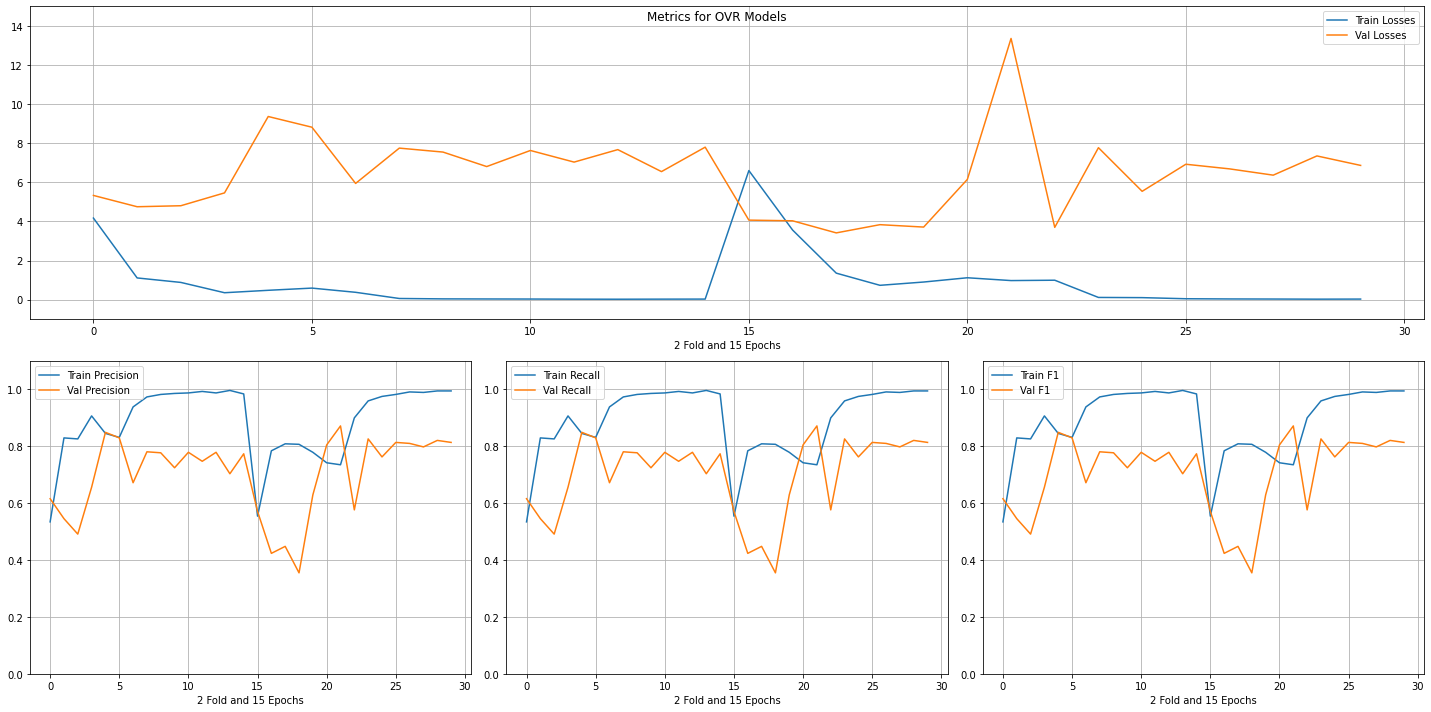

    train_f1  validation_f1  ...  train_losses  validation_losses
6   0.735088       0.871705  ...      0.975693          13.360426
4   0.845343       0.849123  ...      0.478170           9.367955
5   0.831283       0.829825  ...      0.590748           8.820751
8   0.959649       0.826011  ...      0.112981           7.772179
13  0.994737       0.820738  ...      0.024422           7.351212
10  0.982456       0.813708  ...      0.046728           6.925930
14  0.994737       0.813708  ...      0.029194           6.866656
11  0.991228       0.810193  ...      0.035664           6.689416
5   0.742105       0.804921  ...      1.119725           6.150428
12  0.989474       0.797891  ...      0.031093           6.368070
7   0.973638       0.780702  ...      0.059375           7.751340
10  0.987698       0.778947  ...      0.031006           7.630247
12  0.987698       0.778947  ...      0.021707           7.674042
8   0.982425       0.777193  ...      0.039418           7.548653
14  0.9841

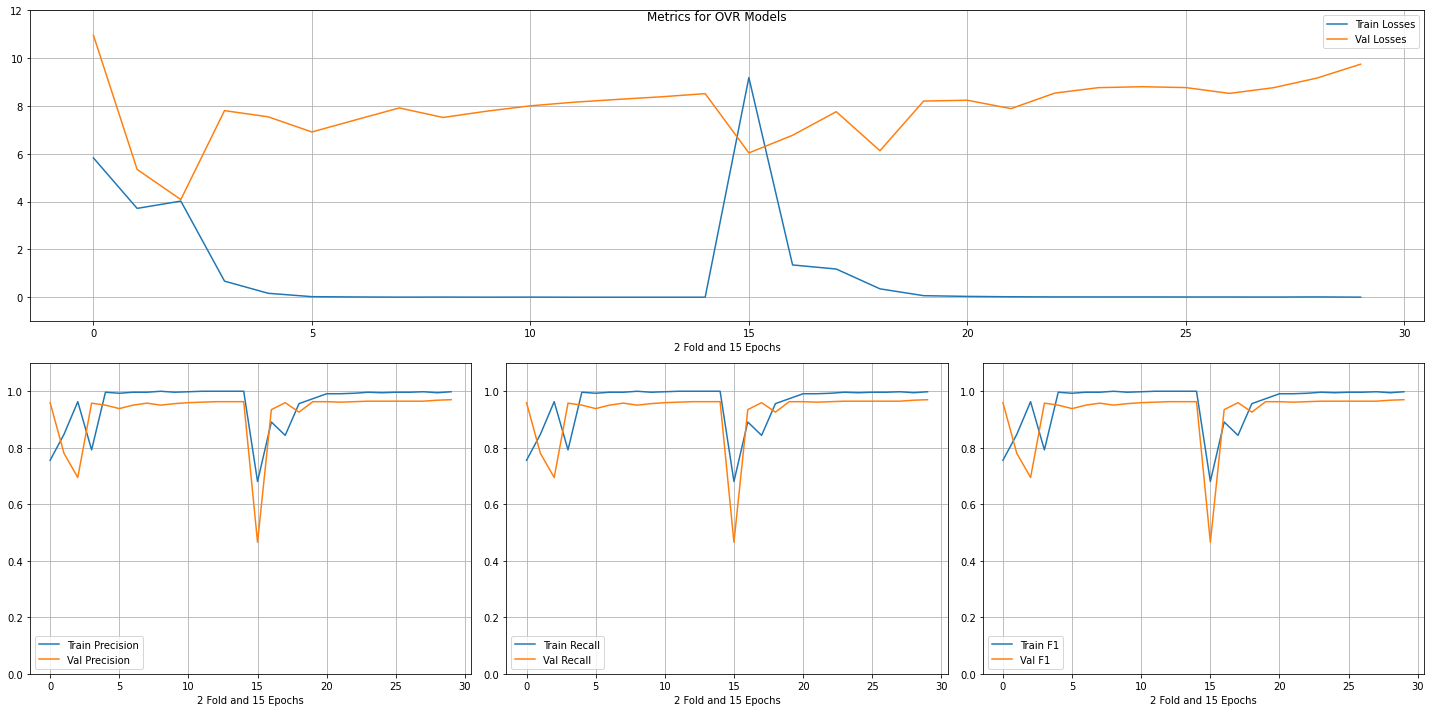

    train_f1  validation_f1  ...  train_losses  validation_losses
14  0.998246       0.970123  ...      0.005798           9.749511
13  0.994737       0.968366  ...      0.015394           9.168667
12  0.998246       0.964851  ...      0.010473           8.765144
11  0.996491       0.964851  ...      0.012497           8.528548
10  0.996491       0.964851  ...      0.012725           8.771542
9   0.994737       0.964851  ...      0.014684           8.807601
8   0.996491       0.964851  ...      0.014987           8.768822
12  1.000000       0.963158  ...      0.003326           8.277571
13  1.000000       0.963158  ...      0.002730           8.386380
14  1.000000       0.963158  ...      0.002539           8.518543
4   0.973684       0.963093  ...      0.067381           8.207911
7   0.992982       0.963093  ...      0.015986           8.540342
5   0.991228       0.963093  ...      0.037320           8.242506
11  1.000000       0.961404  ...      0.002718           8.159837
6   0.9912

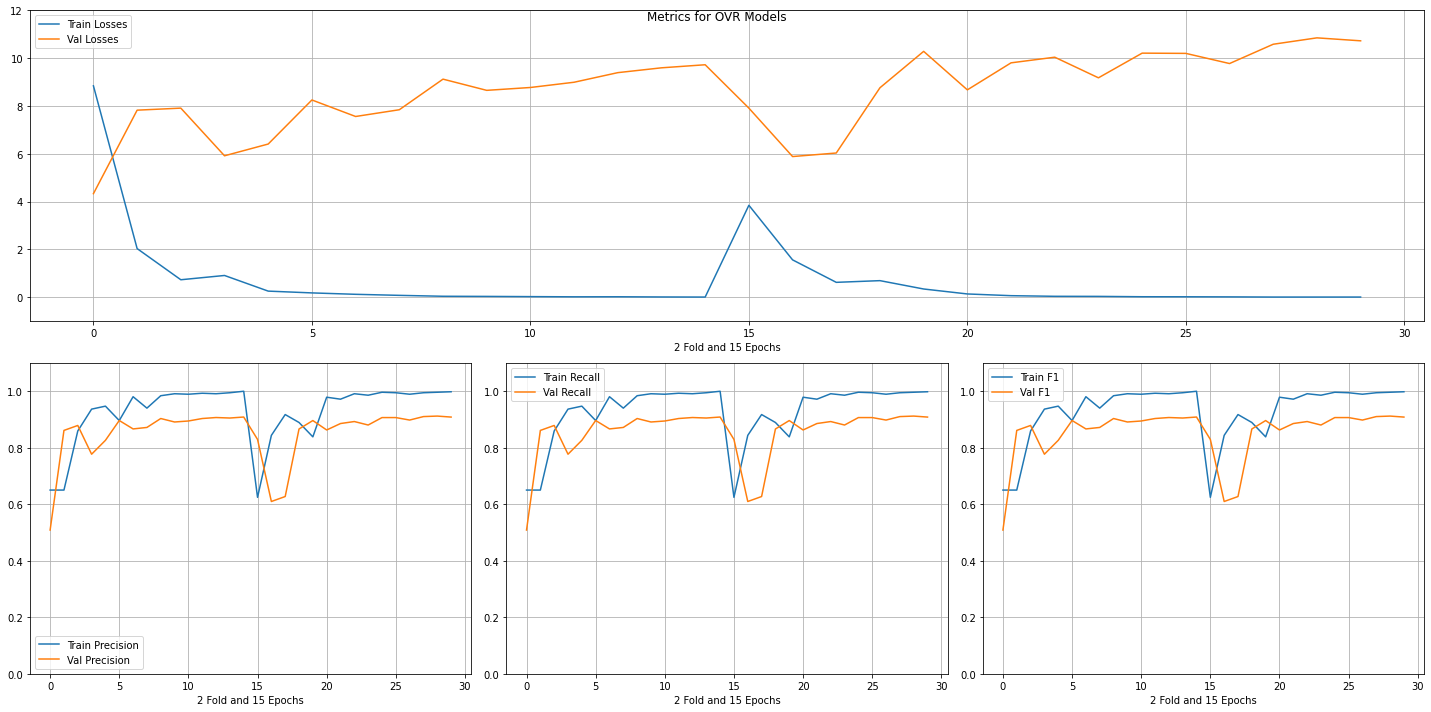

    train_f1  validation_f1  ...  train_losses  validation_losses
13  0.996491       0.912127  ...      0.009710          10.851596
12  0.994737       0.910369  ...      0.009756          10.584457
14  1.000000       0.908772  ...      0.009473           9.726502
14  0.998246       0.908612  ...      0.010127          10.727822
12  0.991213       0.907018  ...      0.021806           9.396275
10  0.994737       0.906854  ...      0.021436          10.201916
9   0.996491       0.906854  ...      0.023173          10.212215
13  0.994728       0.905263  ...      0.013736           9.598381
8   0.984183       0.903509  ...      0.042842           9.124708
11  0.992970       0.903509  ...      0.019958           8.994992
11  0.989474       0.898067  ...      0.017074           9.777147
5   0.896309       0.896491  ...      0.183502           8.253254
4   0.838596       0.896309  ...      0.346900          10.286659
10  0.989455       0.894737  ...      0.028031           8.775522
7   0.9912

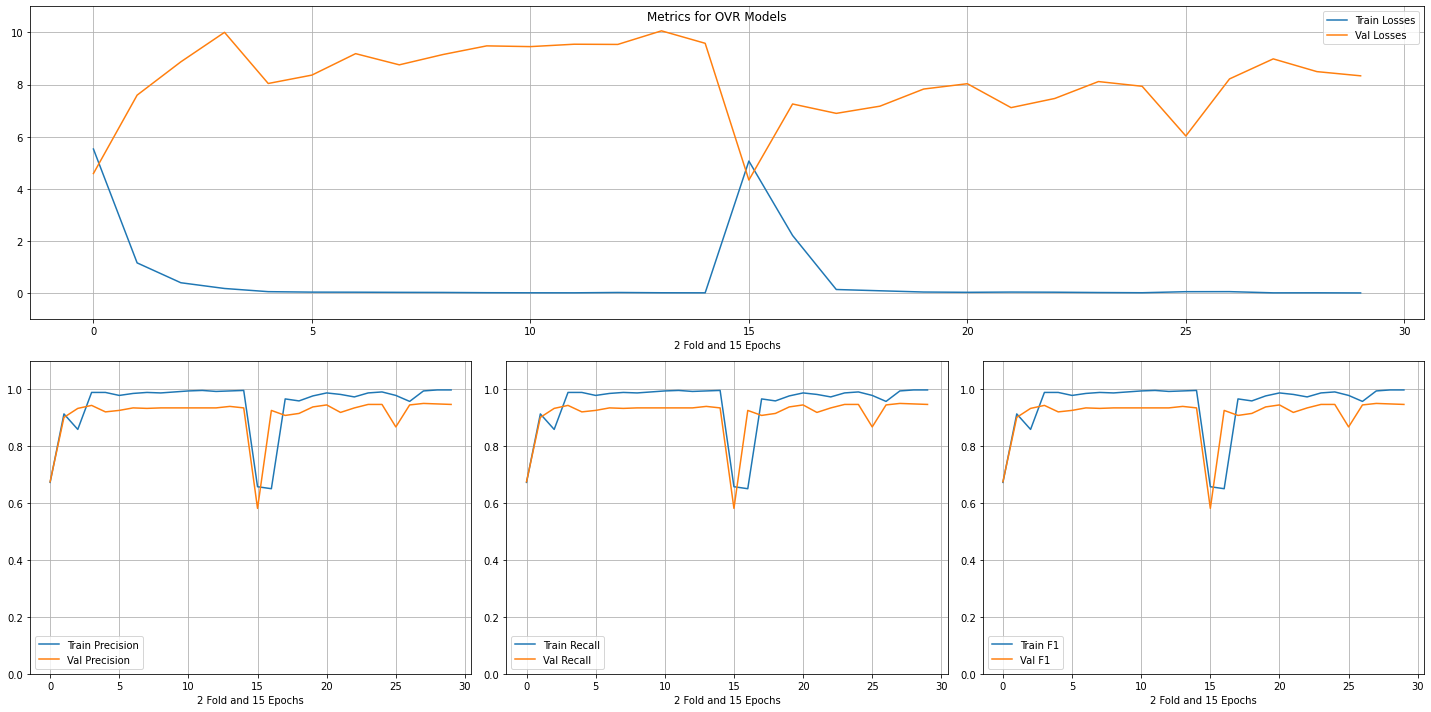

    train_f1  validation_f1  ...  train_losses  validation_losses
12  0.994737       0.950791  ...      0.011338           8.986722
13  0.998246       0.949033  ...      0.013055           8.497849
9   0.991228       0.947276  ...      0.015551           7.935640
8   0.987719       0.947276  ...      0.023448           8.116536
14  0.998246       0.947276  ...      0.007614           8.336782
5   0.987719       0.945518  ...      0.031432           8.034119
11  0.957895       0.945518  ...      0.057397           8.218308
3   0.989455       0.943860  ...      0.178349          10.005053
13  0.994728       0.940351  ...      0.014580          10.062387
4   0.977193       0.938489  ...      0.042344           7.829802
14  0.996485       0.935088  ...      0.012022           9.584495
8   0.987698       0.935088  ...      0.026553           9.154032
9   0.991213       0.935088  ...      0.016909           9.485564
10  0.994728       0.935088  ...      0.013291           9.457323
11  0.9964

In [46]:
jlabels = jle.transform(jle.classes_)
jovr_res = ovr_train_model(data, MelsJanakaRagaDataset, MelRaga, "OVR Models", jlabels, 
                           jle.classes_, lbl_encoder=jle, target='JanakaRagamCode', lr=1e-5, epochs=15, n_folds=2, 
                           feature='mel_spec')

In [47]:
for k in jovr_res:
  print(jle.inverse_transform([k]))
  print(results_to_df(jovr_res[k]).head())

['Chalanata']
    train_f1  validation_f1  ...  train_losses  validation_losses
0    0.62807       0.977153  ...      8.389852           7.380814
9    1.00000       0.977153  ...      0.005404           7.374311
12   1.00000       0.977153  ...      0.002763           7.399306
13   1.00000       0.975395  ...      0.005724           7.205281
11   1.00000       0.975395  ...      0.002568           7.287995

[5 rows x 8 columns]
['Hanumatodi']
    train_f1  validation_f1  ...  train_losses  validation_losses
14  1.000000       0.980702  ...      0.001719           6.916250
7   0.998243       0.980702  ...      0.005565           7.225363
13  1.000000       0.980702  ...      0.003210           6.931777
12  1.000000       0.980702  ...      0.002026           6.915129
11  1.000000       0.980702  ...      0.001108           6.854725

[5 rows x 8 columns]
['Harikambhoji']
    train_f1  validation_f1  ...  train_losses  validation_losses
14  1.000000       0.926316  ...      0.012386      

# OVR Experiment without Mayamalavagowla Raga

In [48]:
cl = jle.classes_
mc = jle.transform(['Mayamalavagowla','Unknown'])
rdata = data[data['JanakaRagamCode']!=mc[0]]
rdata = rdata[rdata['JanakaRagamCode']!=mc[1]]
cl = [x for x in cl if not x in ['Mayamalavagowla','Unknown'] ]
jlabels1 = jle.transform(cl)

Training for ['Chalanata'] with 25 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 569/570
Class Weights : [ 0.51122083 22.78      ]
Epoch 1/15 : Training Loss: 13.061 / Validation Loss : 7.919 [Time Taken : 2.719058 seconds]
Epoch 2/15 : Training Loss: 7.028 / Validation Loss : 15.895 [Time Taken : 2.722266 seconds]
Epoch 3/15 : Training Loss: 2.594 / Validation Loss : 8.904 [Time Taken : 2.697124 seconds]
Epoch 4/15 : Training Loss: 0.861 / Validation Loss : 7.199 [Time Taken : 2.710221 seconds]
Epoch 5/15 : Training Loss: 0.170 / Validation Loss : 9.940 [Time Taken : 2.682743 seconds]
Epoch 6/15 : Training Loss: 0.079 / Validation Loss : 9.021 [Time Taken : 2.703605 seconds]
Epoch 7/15 : Training Loss: 0.073 / Validation Loss : 9.747 [Time Taken : 2.703131 seconds]
Epoch 8/15 : Training Loss: 0.041 / Validation Loss : 9.477 [Time Taken : 2.718392 seconds]
Epoch 9/15 : Training Loss: 0.040 / Validation Loss : 9.650 [Time Taken : 2.737571 seconds]
Epoch 10/15 : Training Loss: 0.03

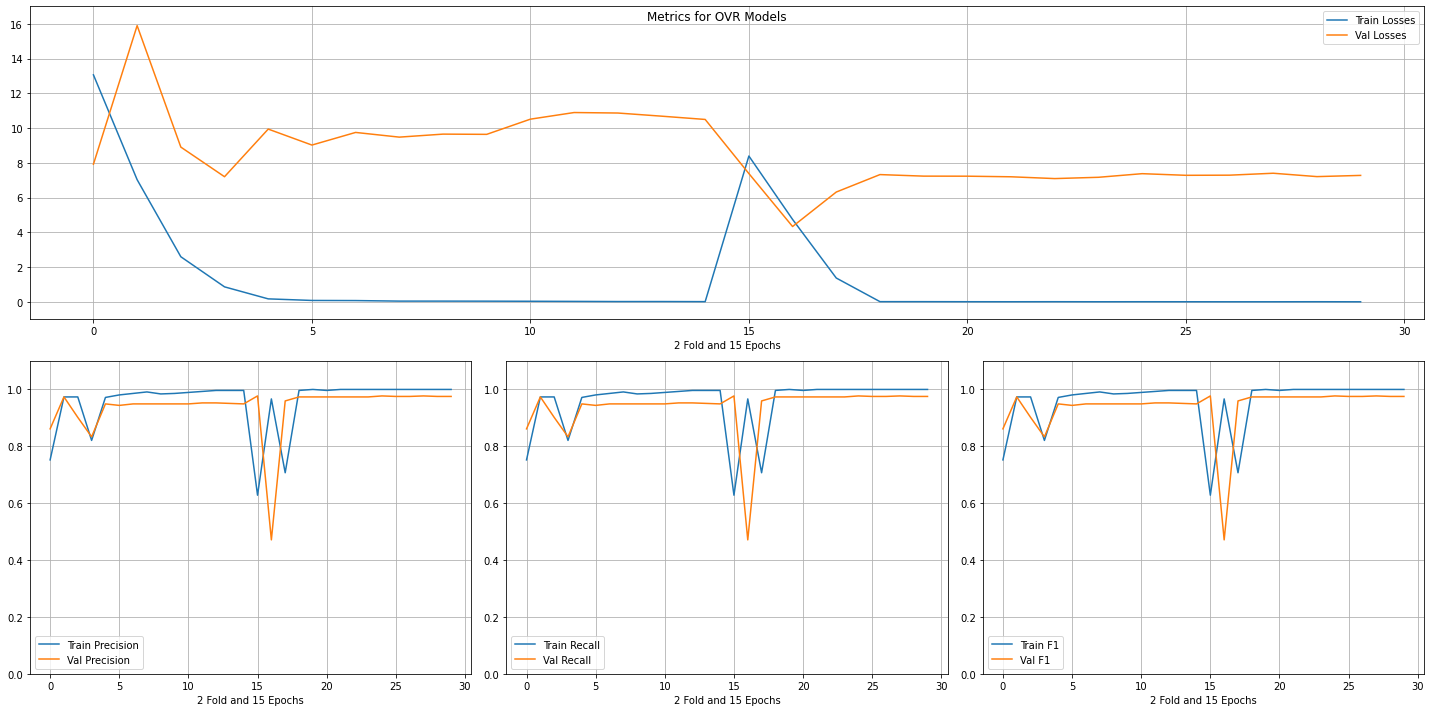

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.628070       0.977153  ...      8.389852           7.380814
9   1.000000       0.977153  ...      0.005404           7.374311
12  1.000000       0.977153  ...      0.002763           7.399307
13  1.000000       0.975395  ...      0.005724           7.205282
11  1.000000       0.975395  ...      0.002568           7.287995
10  1.000000       0.975395  ...      0.004216           7.280282
14  1.000000       0.975395  ...      0.001983           7.274740
1   0.973638       0.973684  ...      7.027902          15.894560
3   0.996491       0.973638  ...      0.009977           7.321871
5   0.996491       0.973638  ...      0.006067           7.229486
8   1.000000       0.973638  ...      0.003712           7.166153
7   1.000000       0.973638  ...      0.006826           7.091752
6   1.000000       0.973638  ...      0.004436           7.195287
4   1.000000       0.973638  ...      0.009394           7.232874
2   0.7070

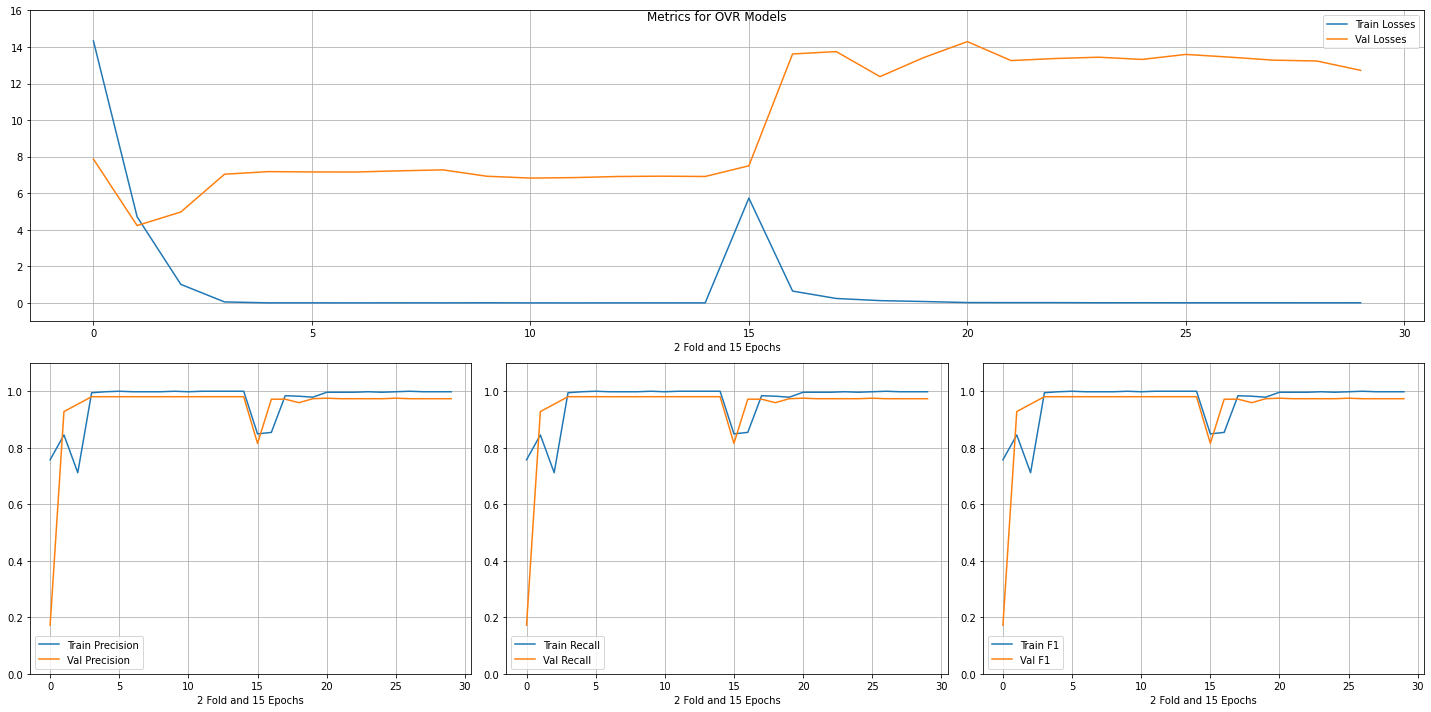

    train_f1  validation_f1  ...  train_losses  validation_losses
14  1.000000       0.980702  ...      0.001719           6.916250
7   0.998243       0.980702  ...      0.005565           7.225363
13  1.000000       0.980702  ...      0.003210           6.931777
12  1.000000       0.980702  ...      0.002026           6.915130
11  1.000000       0.980702  ...      0.001108           6.854725
10  0.998243       0.980702  ...      0.002007           6.827872
8   0.998243       0.980702  ...      0.003460           7.277202
9   1.000000       0.980702  ...      0.008012           6.929597
6   0.998243       0.980702  ...      0.002430           7.160139
5   1.000000       0.980702  ...      0.004704           7.163927
4   0.998243       0.980702  ...      0.004511           7.181323
3   0.994728       0.980702  ...      0.054077           7.039459
5   0.996491       0.975395  ...      0.020347          14.293129
10  0.998246       0.975395  ...      0.008193          13.592251
11  1.0000

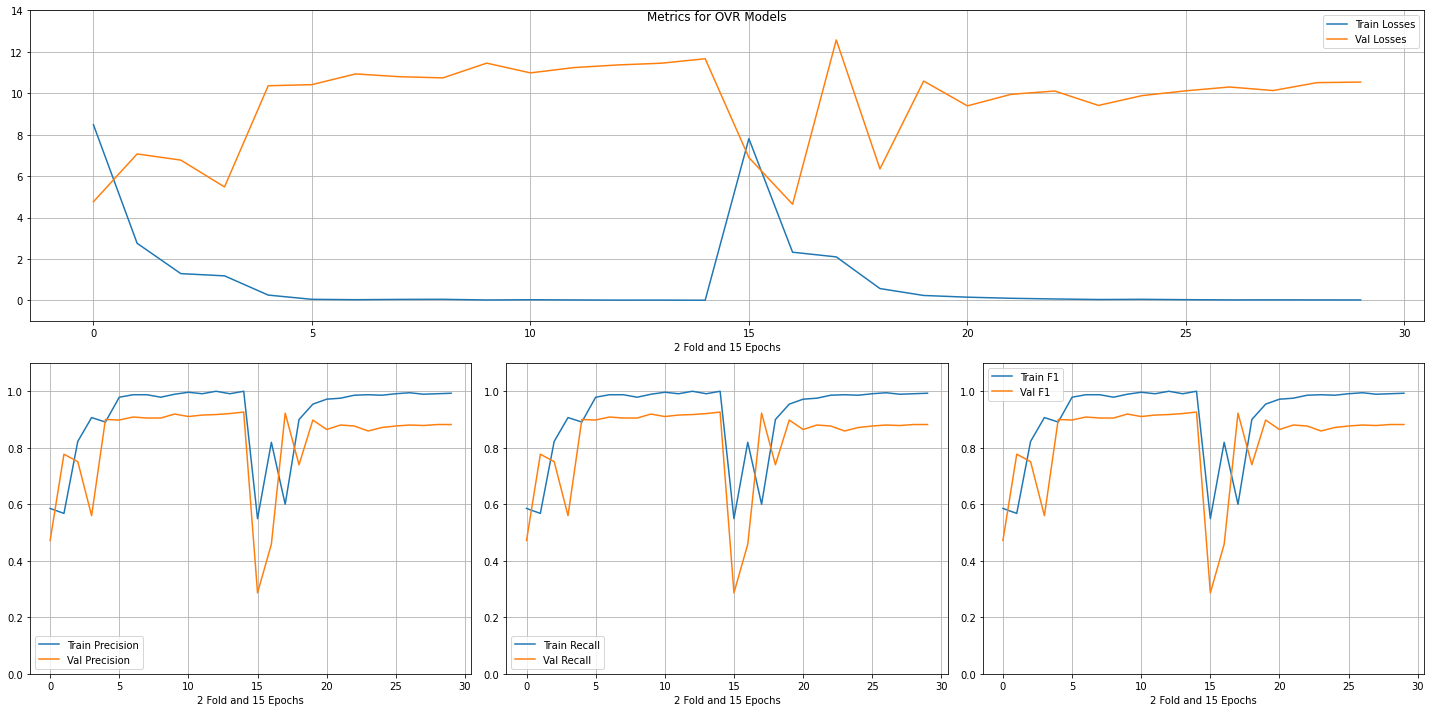

    train_f1  validation_f1  ...  train_losses  validation_losses
14  1.000000       0.926316  ...      0.012386          11.666210
2   0.600000       0.922671  ...      2.103595          12.576168
13  0.991213       0.921053  ...      0.018497          11.451781
9   0.989455       0.919298  ...      0.024369          11.455317
12  1.000000       0.917544  ...      0.017450          11.366892
11  0.991213       0.915789  ...      0.025839          11.240934
10  0.996485       0.910526  ...      0.035615          10.984621
6   0.987698       0.908772  ...      0.037957          10.934687
7   0.987698       0.905263  ...      0.052362          10.800601
8   0.978910       0.905263  ...      0.056243          10.743471
4   0.891037       0.900000  ...      0.260077          10.363042
5   0.978910       0.898246  ...      0.055546          10.416641
4   0.954386       0.898067  ...      0.242000          10.590259
13  0.991228       0.882250  ...      0.027647          10.513836
14  0.9929

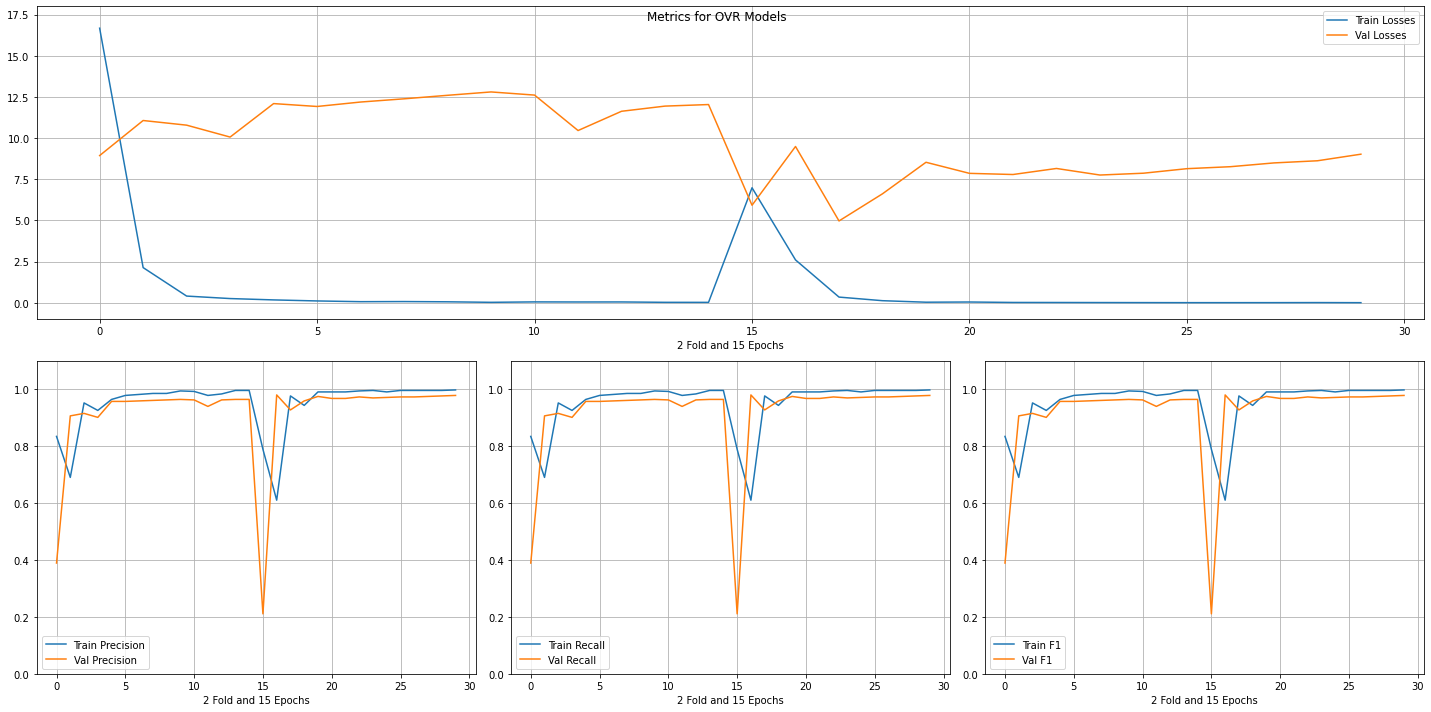

    train_f1  validation_f1  ...  train_losses  validation_losses
1   0.610526       0.980668  ...      2.601167           9.490758
14  0.998246       0.978910  ...      0.003958           9.023435
13  0.996491       0.977153  ...      0.009902           8.623039
4   0.991228       0.975395  ...      0.032209           8.531848
12  0.996491       0.975395  ...      0.006322           8.492845
11  0.996491       0.973638  ...      0.005538           8.263280
10  0.996491       0.973638  ...      0.005348           8.143497
7   0.994737       0.973638  ...      0.014851           8.155767
9   0.991228       0.971880  ...      0.008290           7.867948
8   0.996491       0.970123  ...      0.011047           7.756825
6   0.991228       0.968366  ...      0.017244           7.788836
5   0.991228       0.968366  ...      0.044220           7.858834
14  0.996485       0.964912  ...      0.022609          12.038379
9   0.994728       0.964912  ...      0.025177          12.804007
13  0.9964

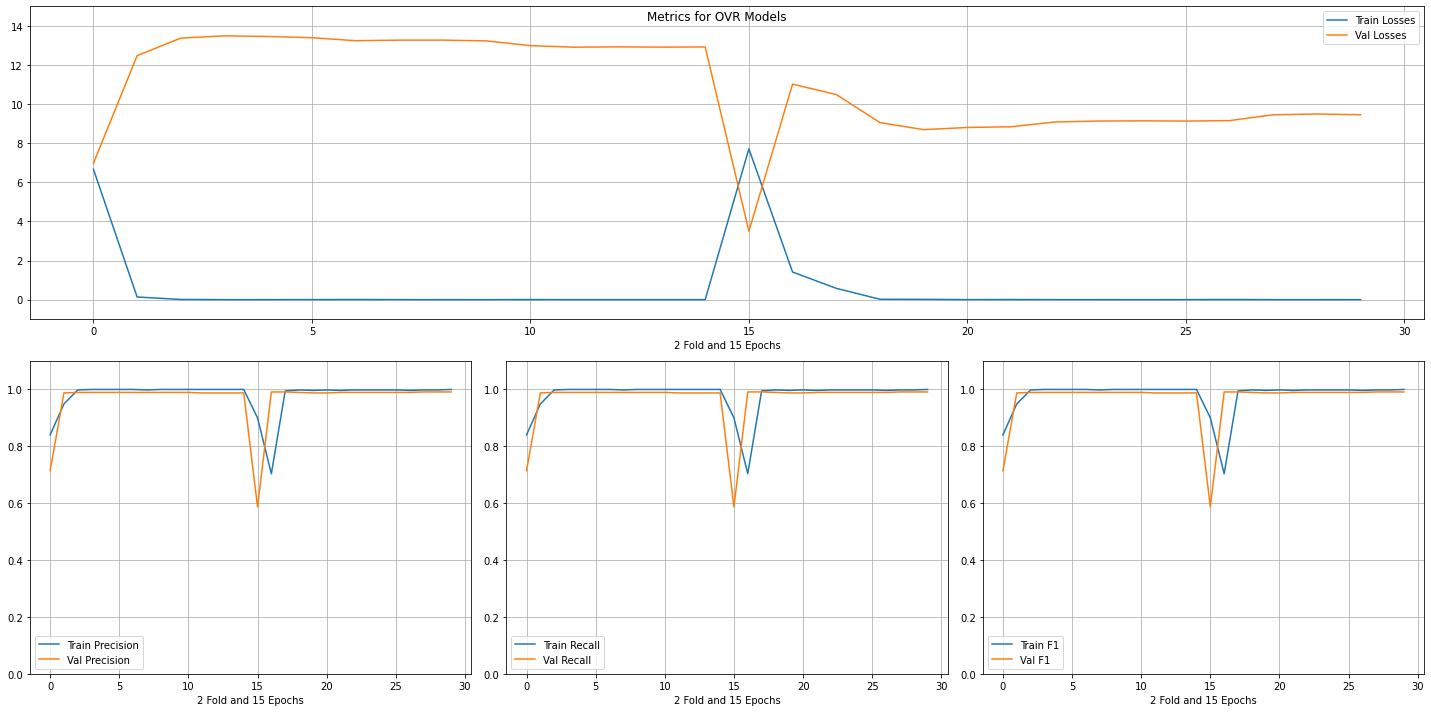

    train_f1  validation_f1  ...  train_losses  validation_losses
14  1.000000       0.991213  ...      0.001778           9.457942
13  0.998246       0.991213  ...      0.001432           9.495880
2   0.994737       0.991213  ...      0.579219          10.491199
1   0.703509       0.991213  ...      1.412727          11.022976
12  0.998246       0.991213  ...      0.001220           9.456862
5   1.000000       0.989474  ...      0.002538          13.398628
10  1.000000       0.989474  ...      0.004118          12.991686
2   0.998243       0.989474  ...      0.009924          13.379148
6   1.000000       0.989474  ...      0.004897          13.245809
4   1.000000       0.989474  ...      0.001585          13.461343
3   1.000000       0.989474  ...      0.001062          13.495042
9   1.000000       0.989474  ...      0.001160          13.234687
8   1.000000       0.989474  ...      0.000747          13.275696
7   0.998243       0.989474  ...      0.002132          13.275002
7   0.9982

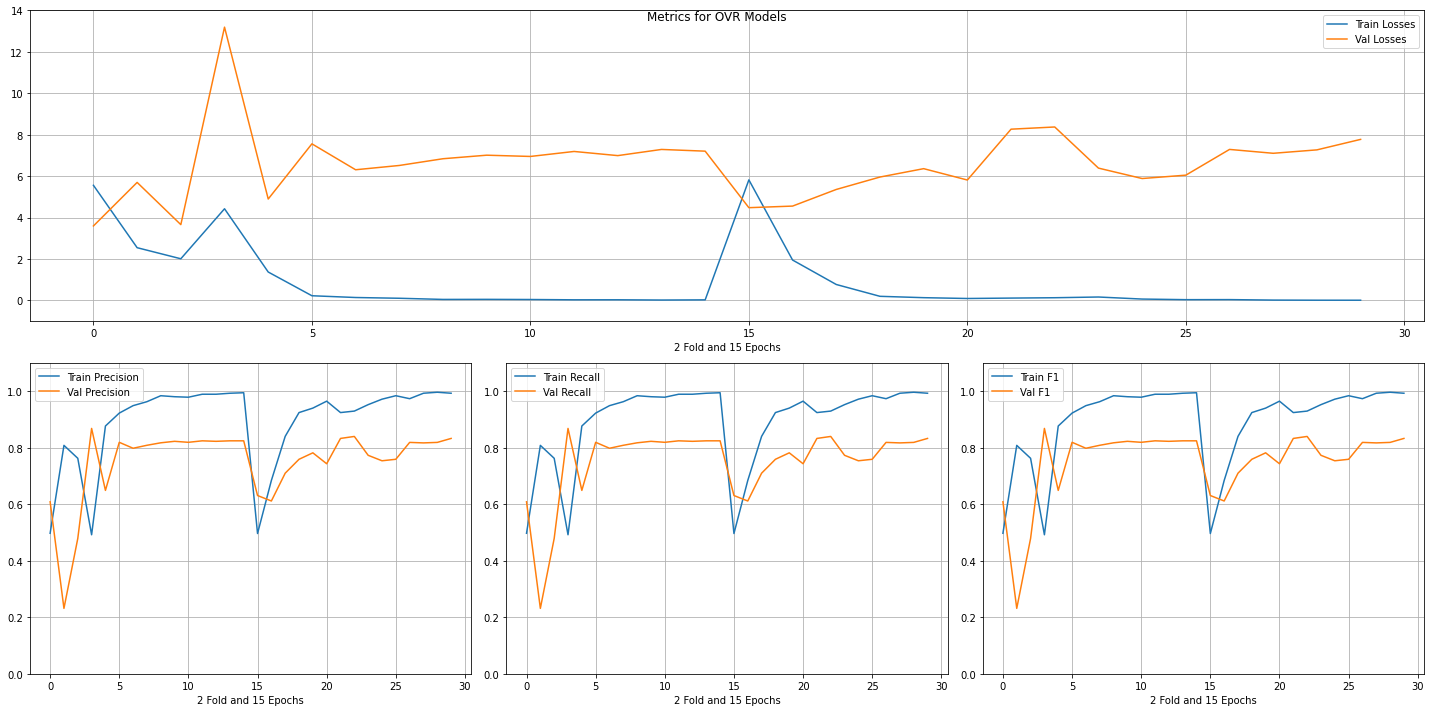

    train_f1  validation_f1  ...  train_losses  validation_losses
3   0.492091       0.868421  ...      4.425982          13.191584
7   0.929825       0.840070  ...      0.132823           8.373330
14  0.992982       0.833040  ...      0.012517           7.774970
6   0.924561       0.833040  ...      0.115516           8.267416
14  0.994728       0.824561  ...      0.029829           7.206524
13  0.992970       0.824561  ...      0.021415           7.289521
11  0.989455       0.824561  ...      0.032148           7.192042
9   0.980668       0.822807  ...      0.054020           7.011884
12  0.989455       0.822807  ...      0.033329           6.991743
10  0.978910       0.819298  ...      0.046659           6.951259
5   0.922671       0.819298  ...      0.228407           7.559927
11  0.973684       0.818981  ...      0.042069           7.290738
13  0.996491       0.818981  ...      0.013443           7.268963
8   0.984183       0.817544  ...      0.051095           6.841035
12  0.9929

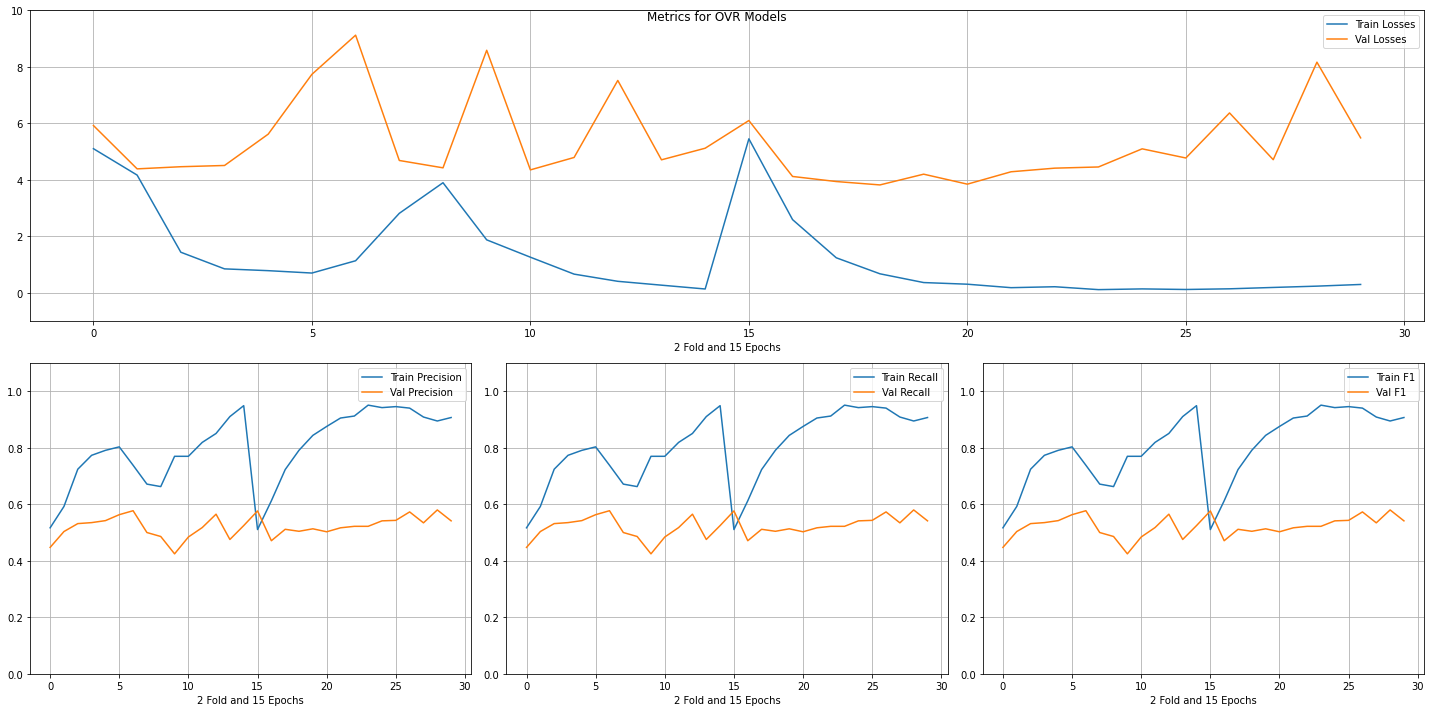

    train_f1  validation_f1  ...  train_losses  validation_losses
13  0.894737       0.579965  ...      0.240715           8.167178
6   0.738137       0.577193  ...      1.139493           9.123281
0   0.510526       0.576450  ...      5.454541           6.101830
11  0.940351       0.572935  ...      0.146357           6.371478
12  0.850615       0.564912  ...      0.411655           7.520946
5   0.803163       0.563158  ...      0.704282           7.737521
10  0.945614       0.543058  ...      0.122563           4.776380
4   0.790861       0.542105  ...      0.788531           5.620517
9   0.942105       0.541301  ...      0.142897           5.100379
14  0.907018       0.541301  ...      0.300296           5.488833
3   0.773286       0.535088  ...      0.852004           4.511318
12  0.908772       0.534271  ...      0.194590           4.716096
2   0.724077       0.531579  ...      1.440832           4.467561
14  0.949033       0.524561  ...      0.139899           5.122127
7   0.9122

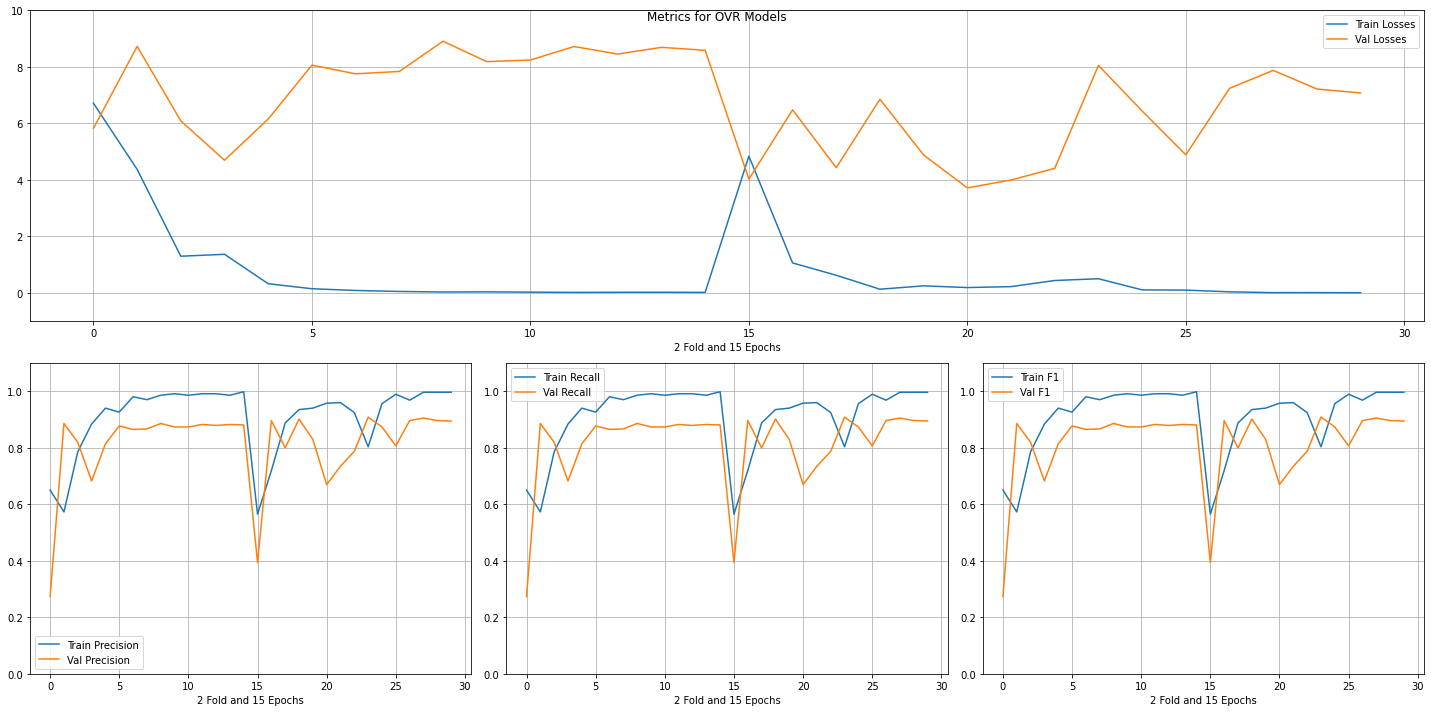

    train_f1  validation_f1  ...  train_losses  validation_losses
8   0.803509       0.908612  ...      0.502978           8.053516
12  0.996491       0.905097  ...      0.011099           7.877347
3   0.935088       0.901582  ...      0.131983           6.855445
13  0.996491       0.896309  ...      0.011646           7.217196
11  0.968421       0.896309  ...      0.039179           7.242176
1   0.719298       0.896309  ...      1.062267           6.480687
14  0.996491       0.894552  ...      0.008596           7.078095
8   0.985940       0.885965  ...      0.033717           8.908438
1   0.572935       0.885965  ...      4.373660           8.727936
11  0.991213       0.882456  ...      0.020272           8.722033
13  0.985940       0.882456  ...      0.024706           8.693011
14  0.998243       0.880702  ...      0.020467           8.587262
12  0.991213       0.878947  ...      0.024008           8.455630
5   0.926186       0.877193  ...      0.149173           8.061824
9   0.9912

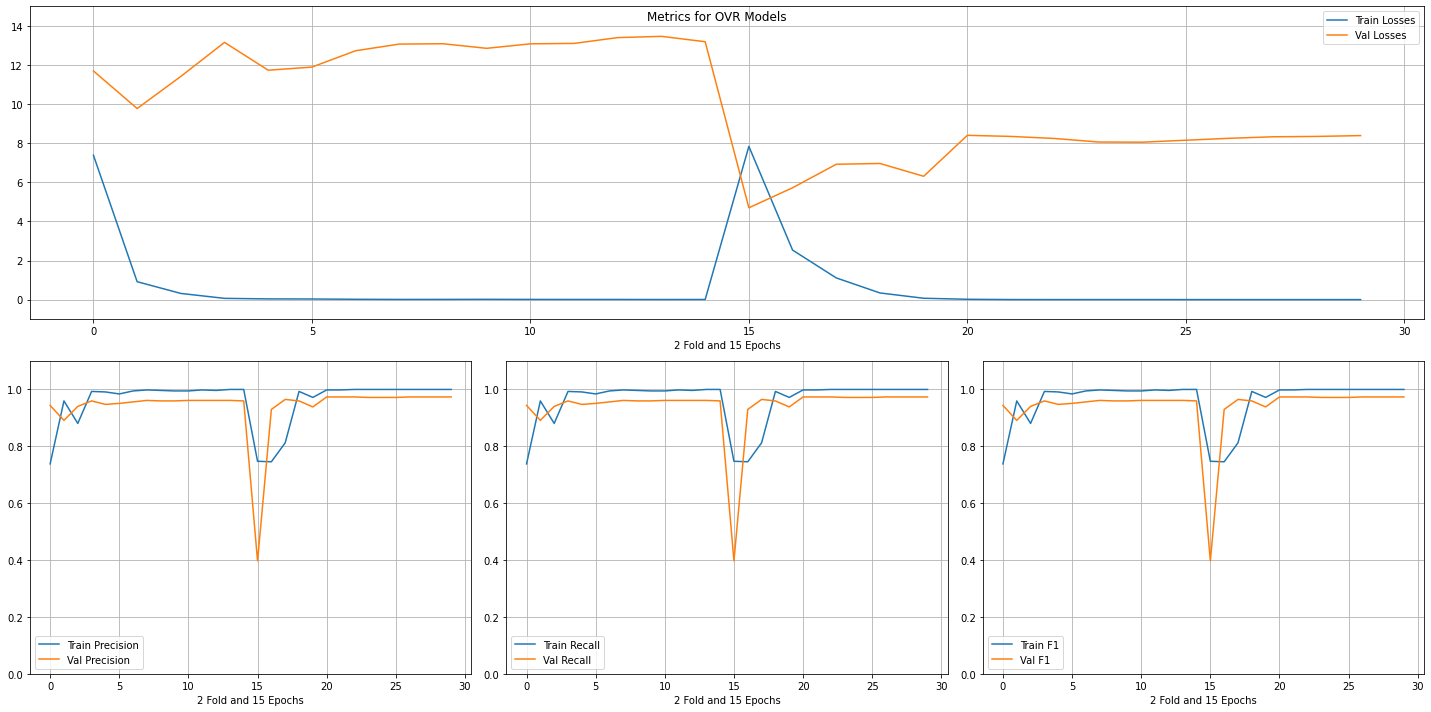

    train_f1  validation_f1  ...  train_losses  validation_losses
14  1.000000       0.973638  ...      0.002478           8.391949
13  1.000000       0.973638  ...      0.001926           8.348971
7   1.000000       0.973638  ...      0.002737           8.243457
6   0.998246       0.973638  ...      0.004667           8.349131
5   0.998246       0.973638  ...      0.018913           8.405249
11  1.000000       0.973638  ...      0.002277           8.252977
12  1.000000       0.973638  ...      0.002377           8.331171
9   1.000000       0.971880  ...      0.003547           8.054361
10  1.000000       0.971880  ...      0.002520           8.155125
8   1.000000       0.971880  ...      0.003565           8.063559
2   0.812281       0.964851  ...      1.111430           6.925329
10  0.994728       0.961404  ...      0.011963          13.085891
11  0.998243       0.961404  ...      0.009632          13.106512
13  1.000000       0.961404  ...      0.006744          13.467581
7   0.9982

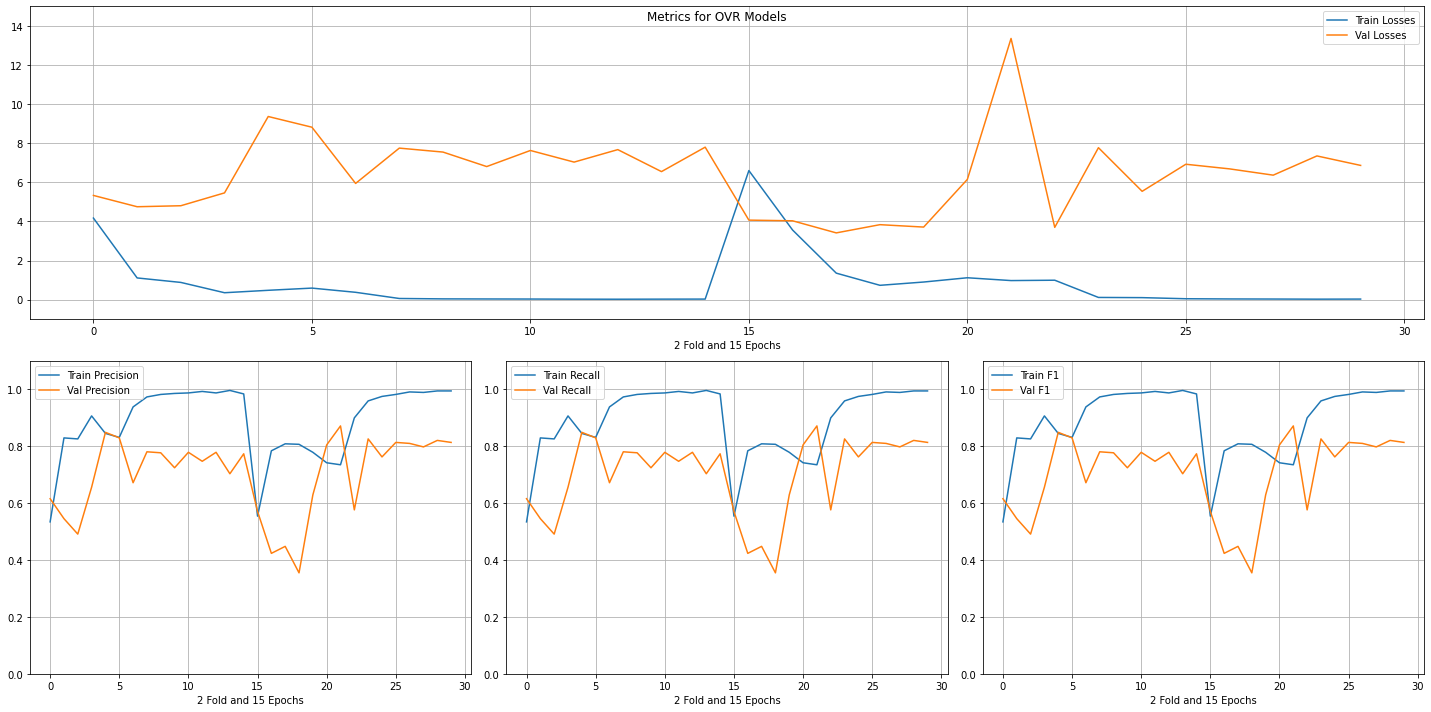

    train_f1  validation_f1  ...  train_losses  validation_losses
6   0.735088       0.871705  ...      0.975694          13.360430
4   0.845343       0.849123  ...      0.478170           9.367954
5   0.831283       0.829825  ...      0.590748           8.820753
8   0.959649       0.826011  ...      0.112981           7.772179
13  0.994737       0.820738  ...      0.024422           7.351210
10  0.982456       0.813708  ...      0.046728           6.925929
14  0.994737       0.813708  ...      0.029194           6.866656
11  0.991228       0.810193  ...      0.035664           6.689415
5   0.742105       0.804921  ...      1.119726           6.150428
12  0.989474       0.797891  ...      0.031093           6.368069
7   0.973638       0.780702  ...      0.059375           7.751341
10  0.987698       0.778947  ...      0.031006           7.630247
12  0.987698       0.778947  ...      0.021707           7.674042
8   0.982425       0.777193  ...      0.039418           7.548654
14  0.9841

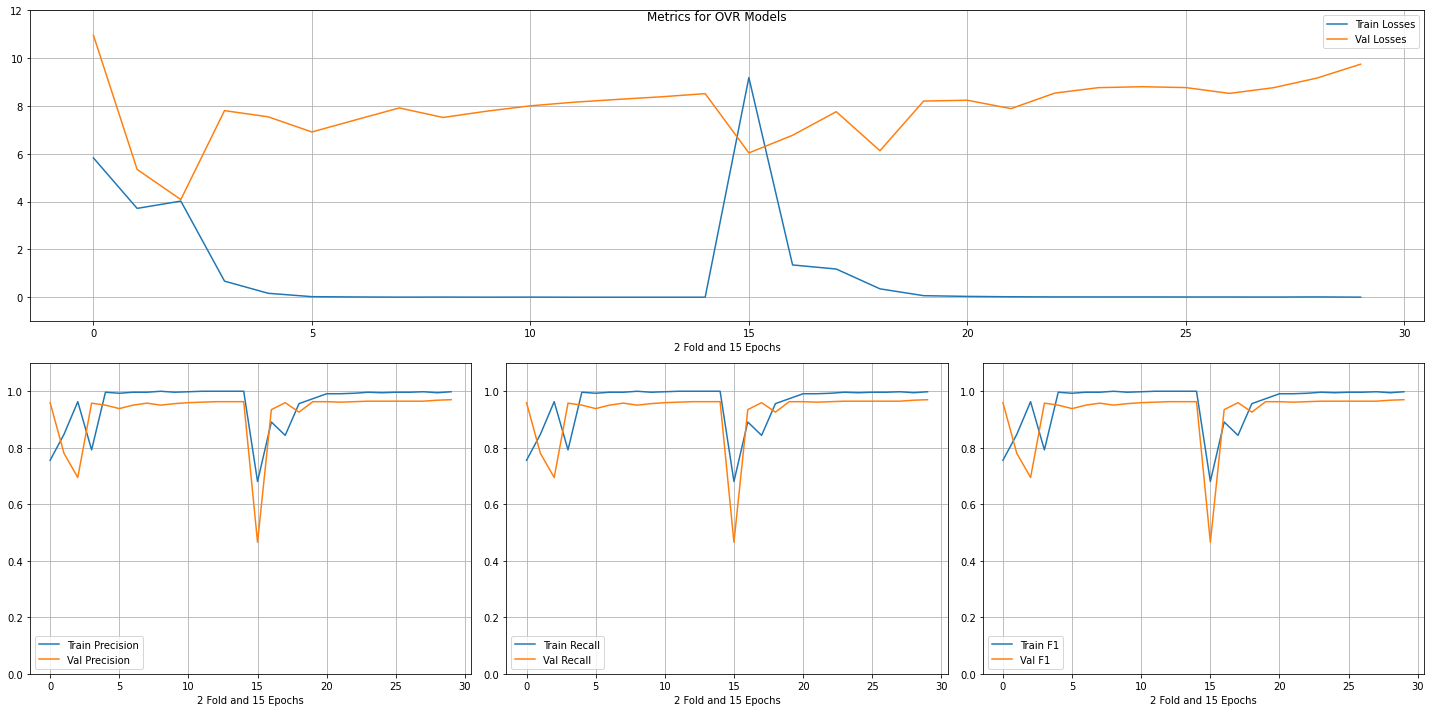

    train_f1  validation_f1  ...  train_losses  validation_losses
14  0.998246       0.970123  ...      0.005798           9.749511
13  0.994737       0.968366  ...      0.015394           9.168667
12  0.998246       0.964851  ...      0.010473           8.765144
11  0.996491       0.964851  ...      0.012497           8.528548
10  0.996491       0.964851  ...      0.012725           8.771542
9   0.994737       0.964851  ...      0.014684           8.807601
8   0.996491       0.964851  ...      0.014987           8.768821
12  1.000000       0.963158  ...      0.003326           8.277573
13  1.000000       0.963158  ...      0.002730           8.386381
14  1.000000       0.963158  ...      0.002539           8.518543
4   0.973684       0.963093  ...      0.067381           8.207911
7   0.992982       0.963093  ...      0.015986           8.540342
5   0.991228       0.963093  ...      0.037320           8.242507
11  1.000000       0.961404  ...      0.002718           8.159838
6   0.9912

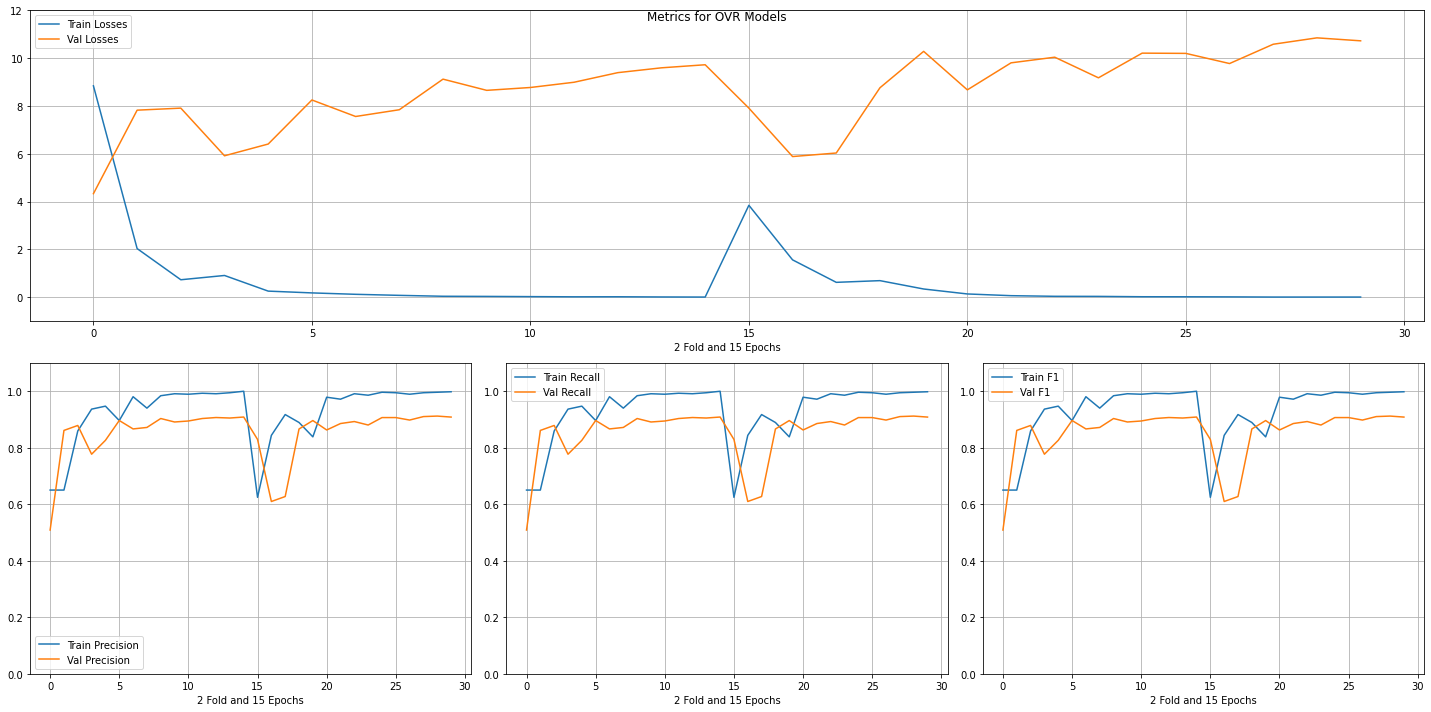

    train_f1  validation_f1  ...  train_losses  validation_losses
13  0.996491       0.912127  ...      0.009710          10.851596
12  0.994737       0.910369  ...      0.009756          10.584457
14  1.000000       0.908772  ...      0.009473           9.726502
14  0.998246       0.908612  ...      0.010127          10.727823
12  0.991213       0.907018  ...      0.021806           9.396274
10  0.994737       0.906854  ...      0.021436          10.201917
9   0.996491       0.906854  ...      0.023173          10.212216
13  0.994728       0.905263  ...      0.013736           9.598381
8   0.984183       0.903509  ...      0.042842           9.124707
11  0.992970       0.903509  ...      0.019958           8.994992
11  0.989474       0.898067  ...      0.017074           9.777148
5   0.896309       0.896491  ...      0.183502           8.253255
4   0.838596       0.896309  ...      0.346900          10.286658
10  0.989455       0.894737  ...      0.028031           8.775520
7   0.9912

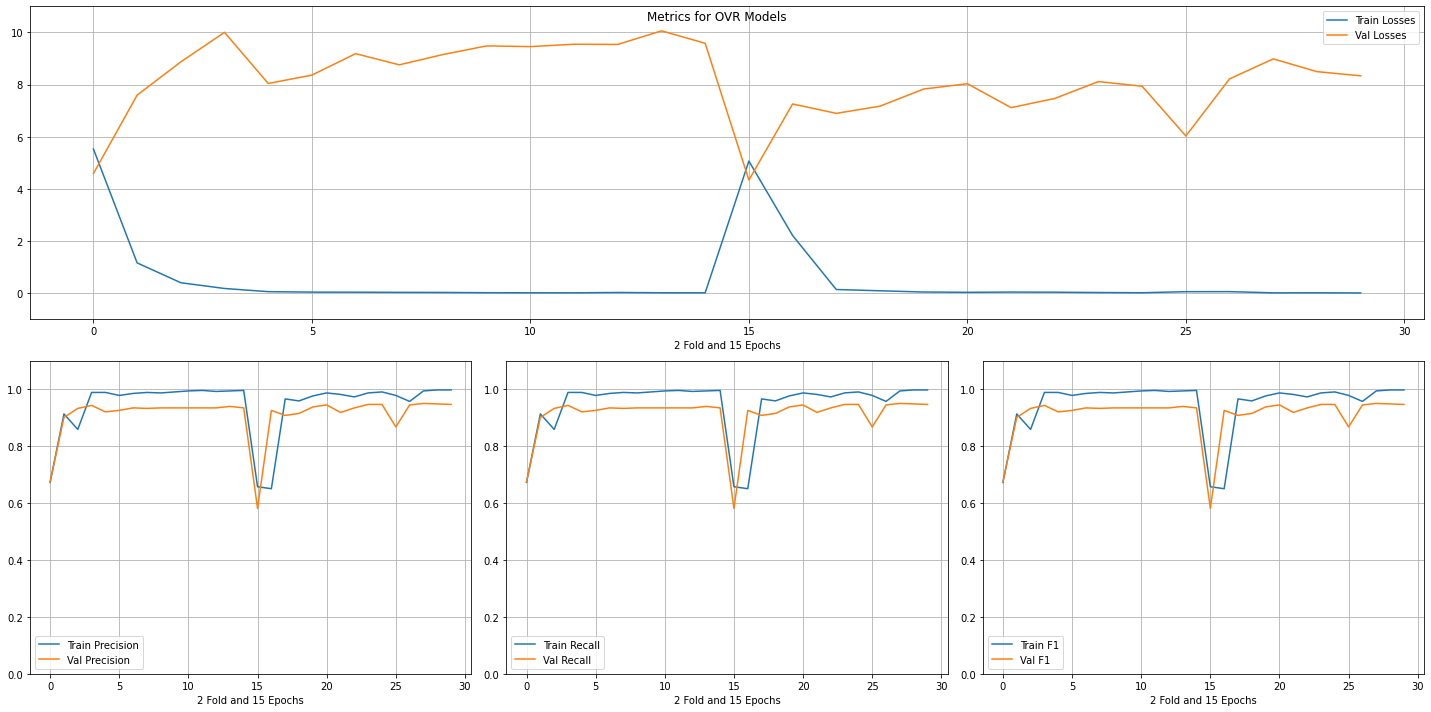

    train_f1  validation_f1  ...  train_losses  validation_losses
12  0.994737       0.950791  ...      0.011338           8.986717
13  0.998246       0.949033  ...      0.013055           8.497847
9   0.991228       0.947276  ...      0.015550           7.935641
8   0.987719       0.947276  ...      0.023448           8.116537
14  0.998246       0.947276  ...      0.007614           8.336781
5   0.987719       0.945518  ...      0.031432           8.034118
11  0.957895       0.945518  ...      0.057397           8.218305
3   0.989455       0.943860  ...      0.178349          10.005054
13  0.994728       0.940351  ...      0.014580          10.062386
4   0.977193       0.938489  ...      0.042344           7.829801
14  0.996485       0.935088  ...      0.012022           9.584496
8   0.987698       0.935088  ...      0.026553           9.154033
9   0.991213       0.935088  ...      0.016909           9.485565
10  0.994728       0.935088  ...      0.013291           9.457324
11  0.9964

In [49]:
jovr_res_reduced = ovr_train_model(data, MelsJanakaRagaDataset, MelRaga,
                                   "OVR Models", jlabels1, jle.classes_, lbl_encoder=jle,
                                   target='JanakaRagamCode', lr=1e-5, epochs=15, n_folds=2, feature='mel_spec')

In [51]:
for k in jovr_res_reduced:
  print(jle.inverse_transform([k]))
  print(results_to_df(jovr_res_reduced[k]).head())

['Chalanata']
    train_f1  validation_f1  ...  train_losses  validation_losses
0    0.62807       0.977153  ...      8.389852           7.380814
9    1.00000       0.977153  ...      0.005404           7.374311
12   1.00000       0.977153  ...      0.002763           7.399307
13   1.00000       0.975395  ...      0.005724           7.205282
11   1.00000       0.975395  ...      0.002568           7.287995

[5 rows x 8 columns]
['Hanumatodi']
    train_f1  validation_f1  ...  train_losses  validation_losses
14  1.000000       0.980702  ...      0.001719           6.916250
7   0.998243       0.980702  ...      0.005565           7.225363
13  1.000000       0.980702  ...      0.003210           6.931777
12  1.000000       0.980702  ...      0.002026           6.915130
11  1.000000       0.980702  ...      0.001108           6.854725

[5 rows x 8 columns]
['Harikambhoji']
    train_f1  validation_f1  ...  train_losses  validation_losses
14  1.000000       0.926316  ...      0.012386      

# OVR Experiment 2 - LSTM Model

In [56]:
class MelsLstmModel(nn.Module):
    def __init__(self, n_labels, dropout=0.25, n_layers=1):
        super().__init__()
        self.input_dim = 40
        self.hidden_dim = self.input_dim
        self.n_layers = n_layers
        self.seq_len = 9601
        self.n_labels = n_labels
        self.rnn = nn.LSTM(self.input_dim, self.hidden_dim, self.n_layers, batch_first=True, bidirectional=True, dropout=dropout)
        self.fc = nn.Sequential(nn.Linear(2*self.hidden_dim,40),
                                nn.GELU(),
                                nn.Linear(40,self.n_labels))

    def forward(self,x,h):
        x = x.reshape((x.shape[0],x.shape[2],x.shape[3]))
        out, (hn, cn) = self.rnn(x.permute(0, 2, 1), h)
        x_forward = out[range(len(out)), self.seq_len - 1, :self.hidden_dim]
        x_reverse = out[:, 0, self.hidden_dim:]
        x = torch.cat((x_forward, x_reverse), 1)
        x = self.fc(x)
        return x
    
    def init_hidden(self, batch_size, target_device):
        weight = next(self.parameters()).data
        # Bi directional LSTM
        hidden = (weight.new(2 * self.n_layers, batch_size, self.hidden_dim).zero_().to(target_device),
                  weight.new(2 * self.n_layers, batch_size, self.hidden_dim).zero_().to(target_device))
        return hidden

In [53]:
def ovr_train_model_lstm(data, dataset, mdl, title, labels, label_classes, lbl_encoder=None, 
                         target='RagamCode', feature='mfcc', epochs=20, lr=1e-3):
  results = {}
  for i in labels:
    # Create new data    
    nsamples = data[data[target]==i].shape[0]
    if lbl_encoder: print(f'Training for {lbl_encoder.inverse_transform([i])} with {nsamples} positive samples')
    ndata = pd.DataFrame()
    ndata[target] = data.apply(lambda x:1 if x[target] == i else 0, axis=1)
    ndata[feature] = data[feature]
    results[i] = train_model(ndata, dataset.prepare_data, gpu, 
                                  **{'n_labels' : 2,
                                   'report' : 50,
                                   'lstm' : True,
                                   'lr' : lr,
                                   'clip_at' : None,
                                   'k_folds' : 2,
                                   'balance_classes' : True,
                                   'dropout' : 0.1,
                                   'title' : title,
                                   'plot' : True,
                                   'epochs' : epochs,
                                   'model' : mdl,
                                   'feature' : feature,
                                   'target' : target})
    print(results_to_df(results[i]))
  return results

Training for ['Chalanata'] with 25 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 304/304
Class Weights : [ 0.52144082 12.16      ]
Epoch 1/15 : Training Loss: 0.689 / Validation Loss : 0.686 [Time Taken : 7.074317 seconds]
Epoch 2/15 : Training Loss: 0.642 / Validation Loss : 0.682 [Time Taken : 6.963848 seconds]
Epoch 3/15 : Training Loss: 0.600 / Validation Loss : 0.671 [Time Taken : 6.935611 seconds]
Epoch 4/15 : Training Loss: 0.542 / Validation Loss : 0.674 [Time Taken : 6.945 seconds]
Epoch 5/15 : Training Loss: 0.463 / Validation Loss : 0.693 [Time Taken : 6.931054 seconds]
Epoch 6/15 : Training Loss: 0.368 / Validation Loss : 0.752 [Time Taken : 6.934213 seconds]
Epoch 7/15 : Training Loss: 0.263 / Validation Loss : 0.858 [Time Taken : 6.933794 seconds]
Epoch 8/15 : Training Loss: 0.172 / Validation Loss : 0.991 [Time Taken : 6.961975 seconds]
Epoch 9/15 : Training Loss: 0.110 / Validation Loss : 1.136 [Time Taken : 6.952331 seconds]
Epoch 10/15 : Training Loss: 0.063 / V

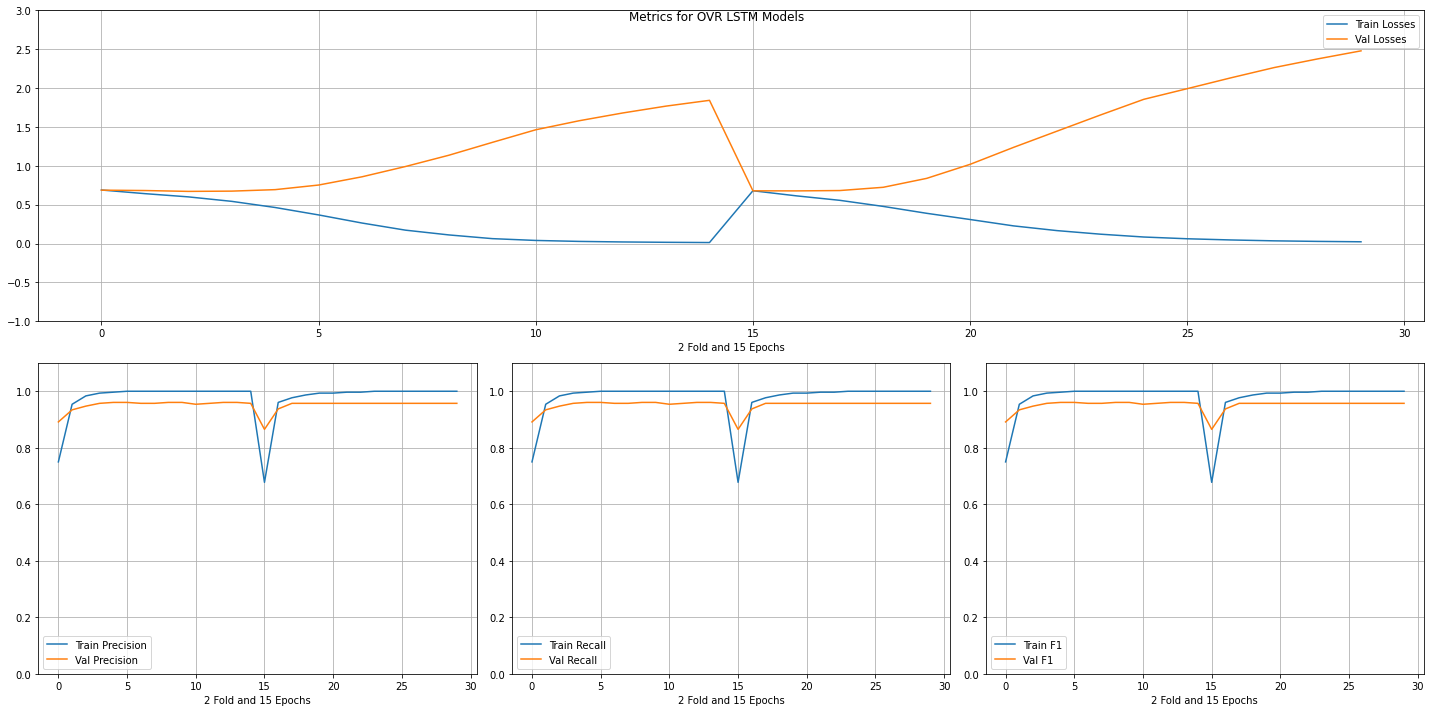

    train_f1  validation_f1  ...  train_losses  validation_losses
8   1.000000       0.960526  ...      0.110331           1.136071
4   0.996711       0.960526  ...      0.463315           0.693156
5   1.000000       0.960526  ...      0.367778           0.752384
13  1.000000       0.960526  ...      0.015420           1.768241
12  1.000000       0.960526  ...      0.019854           1.679688
9   1.000000       0.960526  ...      0.062573           1.301394
7   0.996711       0.957237  ...      0.165967           1.445585
4   0.993421       0.957237  ...      0.388625           0.838179
5   0.993421       0.957237  ...      0.308733           1.018854
6   0.996711       0.957237  ...      0.226699           1.237125
14  1.000000       0.957237  ...      0.022059           2.479360
2   0.976974       0.957237  ...      0.555663           0.681490
8   1.000000       0.957237  ...      0.119997           1.653644
9   1.000000       0.957237  ...      0.083394           1.855735
10  1.0000

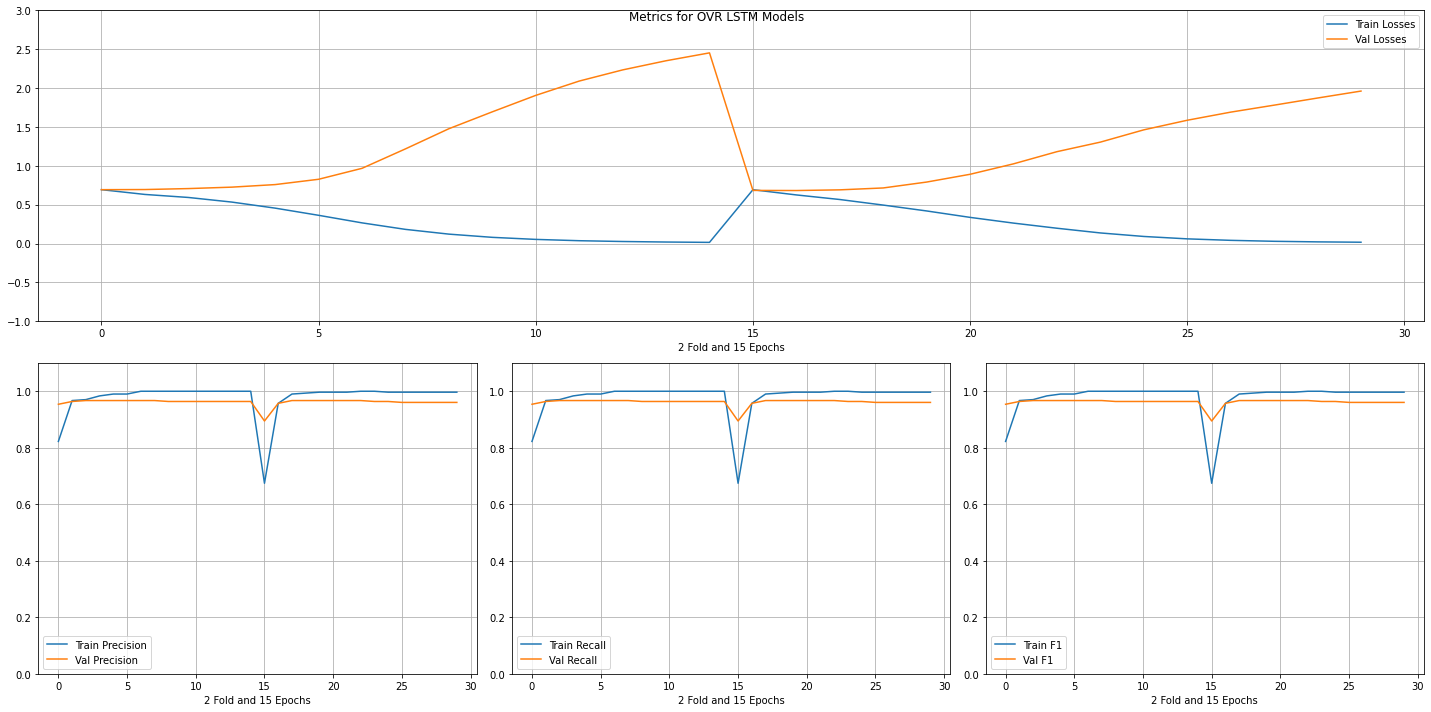

    train_f1  validation_f1  ...  train_losses  validation_losses
2   0.970395       0.967105  ...      0.592602           0.706724
3   0.983553       0.967105  ...      0.533207           0.725238
4   0.990132       0.967105  ...      0.455178           0.758225
5   0.990132       0.967105  ...      0.362871           0.826524
6   1.000000       0.967105  ...      0.265472           0.967529
7   1.000000       0.967105  ...      0.181744           1.217801
7   1.000000       0.967105  ...      0.196430           1.181925
6   0.996711       0.967105  ...      0.262394           1.025269
5   0.996711       0.967105  ...      0.336146           0.890842
4   0.996711       0.967105  ...      0.418855           0.790789
3   0.993421       0.967105  ...      0.494444           0.714941
2   0.990132       0.967105  ...      0.566102           0.690492
14  1.000000       0.963816  ...      0.014559           2.453328
1   0.967105       0.963816  ...      0.631434           0.694493
12  1.0000

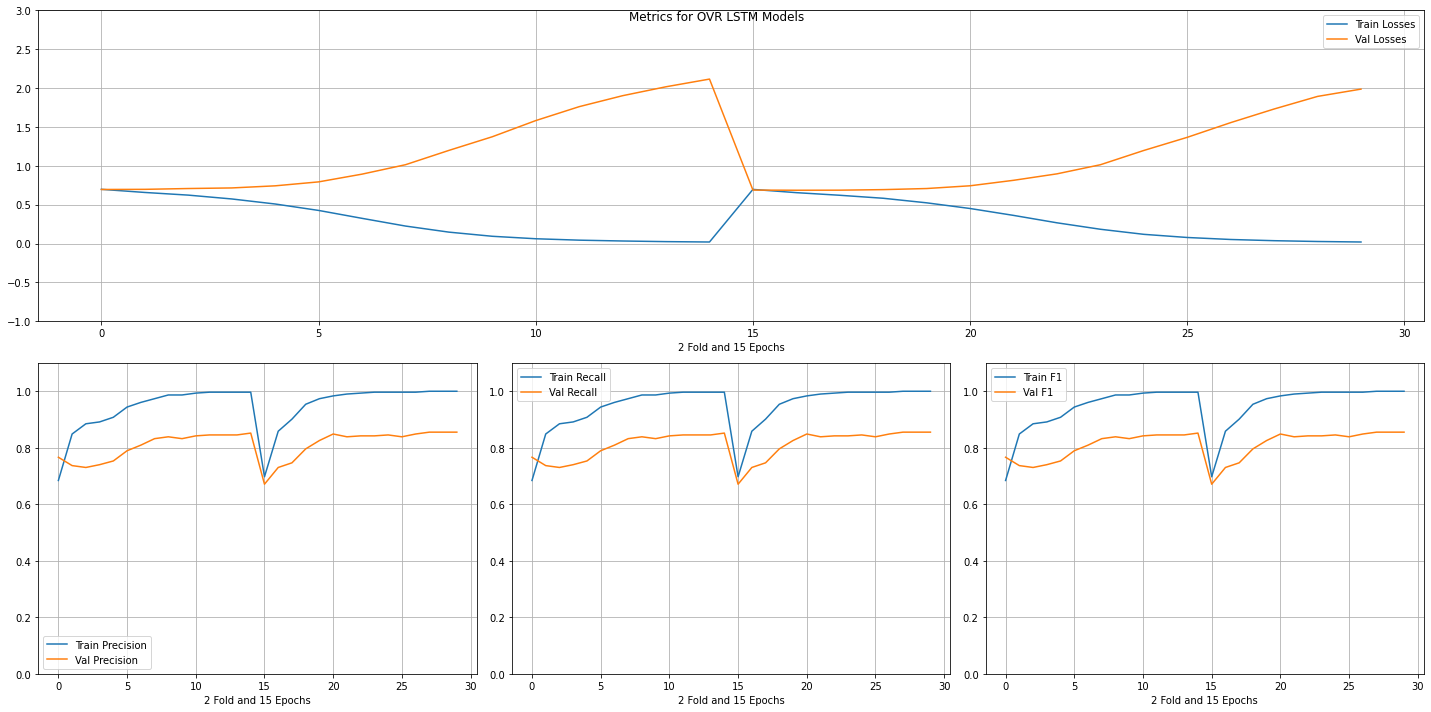

    train_f1  validation_f1  ...  train_losses  validation_losses
14  1.000000       0.855263  ...      0.019359           1.987000
13  1.000000       0.855263  ...      0.025785           1.893144
12  1.000000       0.855263  ...      0.036148           1.731083
14  0.996711       0.851974  ...      0.019260           2.115983
11  0.996711       0.848684  ...      0.051600           1.555722
5   0.983553       0.848684  ...      0.450358           0.742833
12  0.996711       0.845395  ...      0.032200           1.902325
9   0.996711       0.845395  ...      0.117943           1.197398
13  0.996711       0.845395  ...      0.024102           2.017232
11  0.996711       0.845395  ...      0.042919           1.761096
10  0.993421       0.842105  ...      0.061148           1.582011
7   0.993421       0.842105  ...      0.266310           0.896412
8   0.996711       0.842105  ...      0.183273           1.013712
8   0.986842       0.838816  ...      0.146333           1.198158
10  0.9967

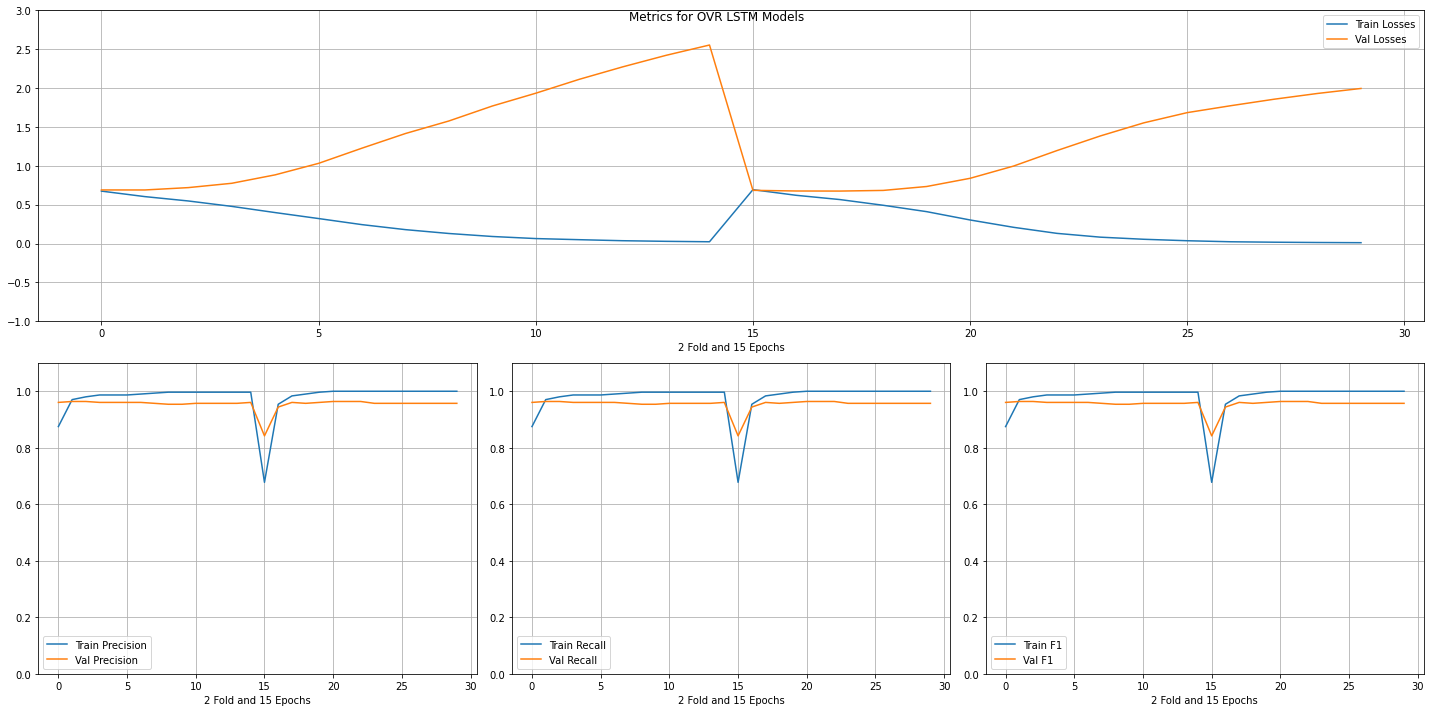

    train_f1  validation_f1  ...  train_losses  validation_losses
5   1.000000       0.963816  ...      0.302742           0.839124
2   0.980263       0.963816  ...      0.547393           0.719299
6   1.000000       0.963816  ...      0.208338           0.996490
1   0.970395       0.963816  ...      0.603495           0.689021
7   1.000000       0.963816  ...      0.130382           1.195982
4   0.996711       0.960526  ...      0.409865           0.733637
2   0.983553       0.960526  ...      0.565610           0.674762
14  0.996711       0.960526  ...      0.022311           2.554391
0   0.875000       0.960526  ...      0.674216           0.689232
6   0.990132       0.960526  ...      0.242769           1.227129
5   0.986842       0.960526  ...      0.321078           1.031537
4   0.986842       0.960526  ...      0.397966           0.883493
3   0.986842       0.960526  ...      0.477752           0.774895
12  1.000000       0.957237  ...      0.016626           1.856966
10  1.0000

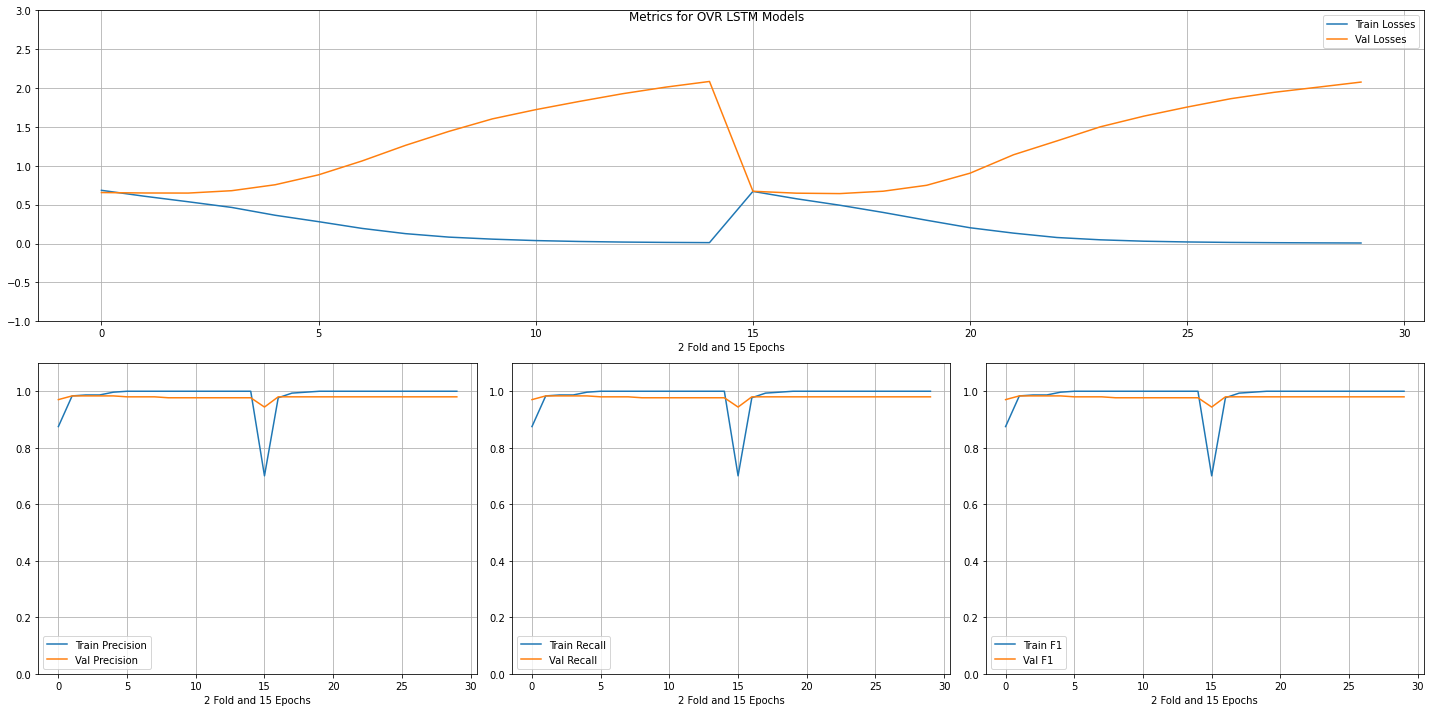

    train_f1  validation_f1  ...  train_losses  validation_losses
2   0.986842       0.983553  ...      0.537119           0.649030
3   0.986842       0.983553  ...      0.464122           0.679634
4   0.996711       0.983553  ...      0.363384           0.756119
1   0.983553       0.983553  ...      0.607500           0.650098
14  1.000000       0.980263  ...      0.006370           2.077524
1   0.976974       0.980263  ...      0.575828           0.647695
11  1.000000       0.980263  ...      0.013948           1.863456
10  1.000000       0.980263  ...      0.019801           1.756258
9   1.000000       0.980263  ...      0.029626           1.639072
8   1.000000       0.980263  ...      0.047347           1.501900
7   1.000000       0.980263  ...      0.077117           1.320310
6   1.000000       0.980263  ...      0.133468           1.142098
5   1.000000       0.980263  ...      0.202559           0.905150
4   1.000000       0.980263  ...      0.299079           0.749211
3   0.9967

KeyboardInterrupt: ignored

In [57]:
jovr_res_reduced = ovr_train_model_lstm(rdata, MelsJanakaRagaDataset, MelsLstmModel, "OVR LSTM Models", jlabels1, cl, lbl_encoder=jle, 
                                        target='JanakaRagamCode', feature='mel_spec', epochs=15, lr=1e-3)

In [55]:
for k in jovr_res_reduced:
  print(jle.inverse_transform([k]))
  print(results_to_df(jovr_res_reduced[k]).head())

['Chalanata']
    train_f1  validation_f1  ...  train_losses  validation_losses
0    0.62807       0.977153  ...      8.389852           7.380814
9    1.00000       0.977153  ...      0.005404           7.374311
12   1.00000       0.977153  ...      0.002763           7.399307
13   1.00000       0.975395  ...      0.005724           7.205282
11   1.00000       0.975395  ...      0.002568           7.287995

[5 rows x 8 columns]
['Hanumatodi']
    train_f1  validation_f1  ...  train_losses  validation_losses
14  1.000000       0.980702  ...      0.001719           6.916250
7   0.998243       0.980702  ...      0.005565           7.225363
13  1.000000       0.980702  ...      0.003210           6.931777
12  1.000000       0.980702  ...      0.002026           6.915130
11  1.000000       0.980702  ...      0.001108           6.854725

[5 rows x 8 columns]
['Harikambhoji']
    train_f1  validation_f1  ...  train_losses  validation_losses
14  1.000000       0.926316  ...      0.012386      